In [1]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import time
import operator
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,fbeta_score,make_scorer
import time 
from sklearn.model_selection import LearningCurveDisplay
from sklearn.svm import SVC
import tensorflow_addons as tfa
from NNnet_class import NNnet

c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you w

In [2]:
#Global Beta (Used for Ftwo score - not used in assignment)
BETA=2

#Seeting seed
np.random.seed(42)

In [3]:
#Scorer Classes

class ld_accuracy_scorer:
    '''Custom Class to allow for GridSearchCV to work with keras sequential model class'''
    def __init__(self):
        self.__name__='accuracy'

    def __call__(self,estimator,X,y):
        '''Call function necssary for GridSearchCV'''
        return accuracy_score(estimator.predict(X),y)

#Not used in Assigment
from sklearn.metrics import fbeta_score
class ld_ftwo_scorer:
    def __init__(self,beta=2):
        self.beta=beta
        self.__name__='F1_B {} Score'.format(self.beta)

    def __call__(self,estimator,X,y,beta=2):
        return fbeta_score(estimator.predict(X),y,beta=self.beta)

#FBeta Scorer
ftwo_scorer=make_scorer(fbeta_score,beta=BETA)

#Accuracy_scorer
accuracy_scorer=make_scorer(accuracy_score)

In [4]:
#Loading Datasets

#Function to load and prepare the hotel dataset
def load_hotel():

    '''Load Hotel Dataset
    
    Returns:
    X (np.array): X array
    Y (np.array): Y array
    col_index (dict): Dictionary containing the pairing for the column location and it's name'''
    
    #PLEASE CHANGE TO LOCATION OF YOUR HOTEL DATA
    df=pd.read_csv('Data/Hotel_Res/Hotel Reservations.csv')
    df=df.drop('arrival_year',axis=1) #Remove Year
    df['season']=df['arrival_month'].apply(lambda x:1 if (x>=4 and x<=9) else 0) #0-Summer, 1-Winter
    df.drop('arrival_month',inplace=True,axis=1)
    df['point_in_month']=df['arrival_date'].apply(lambda x:1 if (x<=15) else 0) #0-eralier in the month,1-later

    #Removing Booking ID as it not a usefull feature
    df=df.drop('Booking_ID',axis=1)

    #Creating the labels (Y)
    Y=np.array(df['booking_status'].apply(lambda x:0 if x=='Not_Canceled' else 1)) #0 if not canceled, 1 if canceled

    df.drop('booking_status',inplace=True,axis=1)

    #Creating the feature vector, X 
    label_columns=['booking_status']
    categorical_columns=['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']
    non_categorical_variables=list(set(df.columns).difference(set(categorical_columns+label_columns)))
    X=np.array(df[non_categorical_variables])
    columns_categorized=non_categorical_variables

    #Now we need to one hot vectorize the type_of_meal_plan, room_type_reserved and market_segment_type
    label_dict={}
    for i in categorical_columns:
        label_dict[i]=OneHotEncoder()
        res=label_dict[i].fit_transform(np.array(df[i]).reshape(-1,1)).toarray()
        X=np.c_[X,res]
        columns_categorized=columns_categorized+[i+'%'+j for j in ['1','2','3','4','5','6','7'][:res.shape[-1]]]

        col_index={}
        results_corr={}
        for label,col in zip(columns_categorized,range(X.shape[-1])):
            corr=scipy.stats.pearsonr(X[:,col],Y)[0]
            results_corr[label]=corr
            col_index[label]=col
    return X,Y,col_index

#Load Fire Detection Dataset

def load_smoke_data():
    '''Not used in assigmnet'''

    df_c=pd.read_csv('Data/Smoke/data.csv')
    X=np.array(df_c.iloc[:,:-1])
    Y=np.array(df_c.iloc[:,-1])
    return X,Y

#Load Heart Disease Data
def load_heart_data():

    '''Load Heart Disease Dataset
    
    Returns:
    X (np.array): X array
    Y (np.array): Y array
    col_index (dict): Dictionary containing the pairing for the column location and it's name'''

    #PLEASE CHANGE TO LOCATION OF YOUR HEART DATA
    df=pd.read_csv('Data/Heart/heart.csv')
    Y=np.array(df['HeartDisease'])
    df.drop('HeartDisease',axis=1,inplace=True)
    
    label_columns=['HeartDisease']
    categorical_columns=['Sex', 'ChestPainType', 'RestingECG','ExerciseAngina','ST_Slope']

    non_categorical_variables=list(set(df.columns).difference(set(categorical_columns+label_columns)))
    X=np.array(df[non_categorical_variables])
    columns_categorized=non_categorical_variables

    #Now we need to one hot vectorize the type_of_meal_plan, room_type_reserved and market_segment_type
    label_dict={}
    for i in categorical_columns:
        label_dict[i]=OneHotEncoder()
        res=label_dict[i].fit_transform(np.array(df[i]).reshape(-1,1)).toarray()
        X=np.c_[X,res]
        columns_categorized=columns_categorized+[i+'%'+j for j in ['1','2','3','4','5','6','7'][:res.shape[-1]]]

        col_index={}
        results_corr={}
        for label,col in zip(columns_categorized,range(X.shape[-1])):
            corr=scipy.stats.pearsonr(X[:,col],Y)[0]
            results_corr[label]=corr
            col_index[label]=col
    return X,Y,col_index

In [5]:
def split_data(X,Y,valid=True,standardize=False):

    '''
    Split the data between train, test and optional validation dataset

    Parameters:
    X (np.array): X features
    Y (np.rray): Labels
    valid (bool): Split into validation dataset 
    standardize (bool): Whether to standardize the data (introduces bias as Sklearn Standard Scaler is trained only on the train data)

    Returns:
    train (list): np.array list of train
    valid (list): optional np.array list of validation
    test (list): np.array list of test
    '''
    
    #Now let's split the data between test and train, we'll use the standard 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
    
    if valid:
        #We'll also split the data between train and validation, we'll again use the standard 80/20 split
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2,random_state=42)
        
        if standardize:
            sklr=StandardScaler()
            X_train=sklr.fit_transform(X_train)
            X_valid=sklr.transform(X_valid)
            X_test=sklr.transform(X_test)
        return [X_train,y_train],[X_valid,y_valid],[X_test,y_test]

    if standardize:
        sklr=StandardScaler()
        X_train=sklr.fit_transform(X_train)
        X_test=sklr.transform(X_test)
    return [X_train,y_train],[X_test,y_test]

In [6]:
def create_param_curve(data,param,param_vals,ax,algorithim_name,algorithim,metric=accuracy_scorer,metric_name='Accuracy',graph=True,beta=BETA,cv=3):

    '''Function to create parameter curves
    
    Parameters:
    data (list): List of np.arrays containing the features and labels  
    param (str): Parameter to vary
    param_vals (list): Parameter values
    ax (matplotlib.axes): Axis for graph
    algorithim (sklearn.algorithim/NNnet): Algorithim to vary parameter in
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    graph (bool): Bool for validation graph
    beta (int): Beta value for the Ftwo scored 
    cv (int): The number of cross validations folds
    
    Returns:
    None'''


    train_acc=[]
    test_acc=[]
    
    for i in param_vals:
        #Crossvalidating each parameter value
        kf=KFold(n_splits=cv,shuffle=True)

        internal_train_accuracy=0
        internal_test_accuracy=0
        
        for train,test in kf.split(X=data[0]):
            if i!='Default':
                if 'net' in algorithim_name.lower():
                    kwargs={param:i,'input_dims':data[0].shape[-1]}
                    clf=algorithim(**kwargs)
                else:
                    clf=algorithim(**{param:i})
            else:
                clf=algorithim()

            clf.fit(data[0][train],data[1][train])
            internal_train_accuracy+=metric(y_pred=clf.predict(data[0][train]),y_true=data[1][train])
            internal_test_accuracy+=metric(y_pred=clf.predict(data[0][test]),y_true=data[1][test])

        train_acc.append(internal_train_accuracy/cv)
        test_acc.append(internal_test_accuracy/cv)

    best_val=param_vals[np.argmax(test_acc)]

    if type(param_vals[0])==str:
        ax.scatter(param_vals,train_acc,label='Training {}'.format(metric_name))
        ax.scatter(param_vals,test_acc,label='Validation {}'.format(metric_name))
    else:
        ax.plot(param_vals,train_acc,label='Training {}'.format(metric_name))
        ax.plot(param_vals,test_acc,label='Validation {}'.format(metric_name))
    #plt.xscale('log')
    ax.axvline(best_val,label='Best {} Value'.format(param),color='red',linestyle = '--')
    ax.legend()
    ax.set_ylabel('{}'.format(metric_name));
    ax.set_xlabel(param);
    ax.set_title('{} vs {}'.format(param,metric_name));
    if type(best_val)!=str:
        if best_val==max(param_vals):
            ax.text(y=(max(test_acc)+min(test_acc))/2+np.abs(np.std(test_acc)),x=best_val-np.std(param_vals)/12,s=best_val,color='green',weight='bold')
        else:
            ax.text(y=(max(test_acc)+min(test_acc))/2+np.abs(np.std(test_acc)),x=best_val+np.std(param_vals)/12,s=best_val,color='green',weight='bold')

In [7]:
def deal_algorithim(data,param_dicts,dataset,algorithim_name,algorithim,metric=accuracy_score,metric_name='Accuracy',cv=3):
    
    '''Function to deal with algorithim
    
    Parameters:
    data (list): List of np.arrays containing the features and labels
    param_dict (dict): Parameter dictionary to vary
    dataset (str): Dataset name
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim/NNnet): Algorithim to vary parameter in
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    cv (int): The number of cross validations folds 

    Returns:
    None'''
    
    num_classes=len(param_dicts.keys())

    #Getting Fig Size
    fig,axes=plt.subplots(2,int(np.ceil(num_classes/2)))
    fig.set_size_inches(15,15)
    i=-1
    for c,ax in enumerate(fig.axes):
        i+=1
        plt.suptitle('Results for Algorithim: "{}" for "{}" Dataset'.format(algorithim_name,dataset),fontsize=18)
        param=list(param_dicts.keys())[i]
        param_vals=param_dicts[param]
        create_param_curve(data,param,param_vals,ax,algorithim_name,algorithim,metric,metric_name)
    plt.tight_layout()

In [13]:
def find_most_important_feature(X,Y,col_index):
    '''Function to find the most correlated numerical feature, correlated with respect to the label

    Parameters:
    X (np.array): Features
    Y (np.array): Labels
    col_index (dict): Numerical column index and associated name
    
    Returns:
    col_index sorted by correlation'''
    results_corr={}
    for label,col in col_index.items():
        #Removing Categorical Labels
        if '%' in label:
            continue
        corr=scipy.stats.pearsonr(X[:,col],Y)[0]
        results_corr[label]=corr

    #Sorting the dictionary by abs personr value and printing
    sorted_results_corr={k: v for k, v in sorted(results_corr.items(), key=lambda x: np.abs(x[1]))}
    return col_index[list(sorted_results_corr.keys())[-1]],sorted_results_corr

In [9]:
def fix_y(y_scores):
    '''Function to convert the metric scores as a percentage of the highest score 

    Parameters:
    y_scores (np.array): Metric scores

    Returns:
    fixed (np.array): Metric scores fixed as a percentage of max
    '''
    max_score=np.max(y_scores)
    fixed=[100*(1+(i-max_score)/max_score) for i in y_scores]
    return fixed

In [10]:
def experiment_algorithim(data,X,Y,col_index,params,dataset,algorithim_name,algorithim,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer()):
    
    '''Function to experiment with algorithim
    
    Parameters:
    data (list): List of np.arrays containing the features and labels
    X (np.array): All features
    Y (np.array): All labels
    col_index (int): Index for important column
    params (dict): Parameter dictionary for GridSearch
    dataset (str): Dataset name
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim/NNnet): Algorithim being experimented on
    predictor_metric (sklearn.metric): Metric for testing the model
    grid_search_metric (sklearn.metric): Metric used by GridSearchCV
    predictor_metric_name (str): Name of predictor metric
    search (bool): Perform GridSearch to find ideal hyperparameters
    LD_scoring (sklearn.metric): Metric used for the Learning Curves

    Returns:
    None'''

    #Splitting into Train & Validation
    train,test=split_data(data[0],data[1],valid=False,standardize=False)

    ##NOISE IN KEY FEATURE

    fig,axes=plt.subplots(1,4)
    fig.set_size_inches(35,10)
    plt.suptitle('Experimentation on Algorithim: "{}" for the "{}" Dataset'.format(algorithim_name,dataset),fontsize=18)

    #Seeing the effect of noise on the two classifier's

    level_of_noise=[]
    clf_accuracy=[]
    clf_o_accuracy=[]
    most_important_index,_=find_most_important_feature(X,Y,col_index)
    
    if 'NET' in algorithim_name.upper():
        n_jobs=1
    else:
        n_jobs=-1

    if search:
        #GridSearch
        clf=GridSearchCV(algorithim,param_grid=params,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric,refit=True)
        clf.fit(train[0],train[1])
        clf_default=clf.best_estimator_
    else:
        clf_default_ld=algorithim.copy()
        clf_default=algorithim.copy()
        clf_default_ld=clf_default_ld.set_params(**params).copy()
        clf_default=clf_default.set_params(**params).copy()
        clf_default.fit(train[0],train[1])

    #Getting distributions for our two features with the highest predictive power, from our test set
    mp_mean,mp_std=np.mean(test[0][:,most_important_index]),np.std(test[0][:,most_important_index])
    for i in np.linspace(0,.1,10):
        #Creating Distributions to add
        dist=np.random.normal(mp_mean*i,mp_std*i,test[0].shape[0])
        #Now let's add this to our test X data
        X_test_altered=test[0].copy()
        X_test_altered[:,most_important_index]=X_test_altered[:,most_important_index]+dist
        #Appending Level of noise
        level_of_noise.append(i)

        #Scoring
        if 'F' in predictor_metric_name.upper():
            clf_o_accuracy.append(predictor_metric(y_pred=clf_default.predict(X_test_altered),y_true=test[-1],beta=BETA))
        else:
            clf_o_accuracy.append(predictor_metric(y_pred=clf_default.predict(X_test_altered),y_true=test[-1]))

    #Plotting
    axes[0].plot(level_of_noise,fix_y(clf_o_accuracy),label='Test {}'.format(predictor_metric_name),color='orange')
    axes[0].legend()
    axes[0].set_ylabel('{} % of Max'.format(predictor_metric_name));
    axes[0].set_xlabel('Level of Noise in Key Feature');
    axes[0].set_title('Noise in Key Feature and {} {}'.format(algorithim_name,predictor_metric_name));

    ##UNBALANCED DATASETS

    #Converting the balanced dataset into an unbalanced dataset
    ind_1=np.argwhere(train[-1]==1)
    ind_0=np.argwhere(train[-1]==0)
    train_acc=[]
    test_acc=[]
    class_1_size=[]
    #Now let's perform the experiment and create a graph at the end

    for percentage_of_ones_factor in np.linspace(0.1,1,10):
        #Sampling
        selected_ind=np.random.choice(ind_1.ravel(),size=int(len(ind_1)*percentage_of_ones_factor))
        X_train_unbalanced=np.r_[train[0][ind_0.ravel(),:],train[0][selected_ind,:]]
        y_train_unbalanced=np.r_[train[-1][ind_0.ravel()],train[-1][selected_ind]]
        class_1_size.append(len(selected_ind)/(len(selected_ind)+len(ind_0)))

        #Let's now trian and test the dataset
        if search:
            #GridSearch
            clf=GridSearchCV(algorithim,param_grid=params,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric)
            clf.fit(X_train_unbalanced,y_train_unbalanced)
        else:
            clf=algorithim.copy()
            clf=clf.set_params(**params)
            clf.fit(X_train_unbalanced,y_train_unbalanced)
        
        #Testing with validation data not having been 'unbalanced'
        if 'F' in predictor_metric_name.upper():
            train_acc.append(predictor_metric(y_pred=clf.predict(X_train_unbalanced),y_true=y_train_unbalanced,beta=BETA))
            test_acc.append(predictor_metric(y_pred=clf.predict(test[0]),y_true=test[-1],beta=BETA))
        else:
            train_acc.append(f1_score(y_pred=clf.predict(X_train_unbalanced),y_true=y_train_unbalanced))
            test_acc.append(f1_score(y_pred=clf.predict(test[0]),y_true=test[-1]))

    #Plotting
    axes[1].plot(class_1_size,fix_y(train_acc),label='Training score')
    axes[1].plot(class_1_size,fix_y(test_acc),label='Test score')
    #plt.xscale('log')
    axes[1].legend()
    #axes[1].set_ylabel('{} % of Max'.format(predictor_metric_name));
    axes[1].set_ylabel('F1_score % of Max')
    axes[1].set_xlabel('Percentage of Data as Class 1');
    axes[1].set_title('The effect of unbalanced Datasets on {}'.format(algorithim_name));

    ##NOISY FEATURES
    #We'll add features to our training data, that are just noise, and observe the effect on the classifier. This time, we'll let optimize the parameters again, instead of relying with what we calculated earlier, we won't prune the tree though, as finding the ideal pruning value takes some time, and, given the number of rows, coupled with the objective of this exercise, it is not too important. 

    clf_o_accuracy_noisy_train=[]
    clf_o_accuracy_noisy_test=[]
    useless_features=np.linspace(0,15,3)
    standardize=False

    for uf in useless_features:
        X_noisy=X.copy()

        if uf==0:
            pass
        else:
            X_noisy=np.c_[X_noisy,np.random.normal(size=(X.shape[0],int(uf)))]
        
        if 'KNN' in algorithim_name.upper() or 'SVM' in algorithim_name.upper() or 'NET' in algorithim_name.upper():
            standardize=True

        #Same as before splitting the data into train,test & validation data
        train,test=split_data(X_noisy,Y,valid=False,standardize=standardize)

        #If statement to change input shape
        if 'NET' in algorithim_name.upper():
            params_send=params.copy()

            if search:
                params_send['input_dims']=[train[0].shape[-1]]
            else:
                params_send['input_dims']=train[0].shape[-1]
        else:
            params_send=params

        #Let's now trian and test the dataset
        if search:
            clf=GridSearchCV(algorithim,param_grid=params_send,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric)
            clf.fit(train[0],train[1])
        else:
            clf=algorithim.copy()
            clf=clf.set_params(**params_send)
            clf.fit(train[0],train[1])

        if 'F' in predictor_metric_name.upper():
            clf_o_accuracy_noisy_train.append(predictor_metric(y_pred=clf.predict(train[0]),y_true=train[1],beta=BETA))
            clf_o_accuracy_noisy_test.append(predictor_metric(y_pred=clf.predict(test[0]),y_true=test[1],beta=BETA))
        else:
            clf_o_accuracy_noisy_train.append(predictor_metric(y_pred=clf.predict(train[0]),y_true=train[1]))
            clf_o_accuracy_noisy_test.append(predictor_metric(y_pred=clf.predict(test[0]),y_true=test[1]))

    #Plotting
    axes[2].plot(useless_features,fix_y(clf_o_accuracy_noisy_train),label='Train {}'.format(predictor_metric_name))
    axes[2].plot(useless_features,fix_y(clf_o_accuracy_noisy_test),label='Test {}'.format(predictor_metric_name))
    #plt.xscale('log')
    axes[2].legend()
    axes[2].set_ylabel('{} % of Max'.format(predictor_metric_name));
    axes[2].set_xlabel('Number of noisy features');
    axes[2].set_title('The effect of noisy features on {}'.format(algorithim_name));


    ##Training Datasize and Score
    axes[3].set_title('The effect of training size on {}'.format(algorithim_name));

    if 'KNN' in algorithim_name.upper() or 'SVM' in algorithim_name.upper() or 'NET' in algorithim_name.upper():
        sklr=StandardScaler()
        X_std=sklr.fit_transform(X)
    else:
        X_std=X      
        
    
    if 'NET' in algorithim_name.upper():
        LearningCurveDisplay.from_estimator(clf_default_ld,X_std,Y,cv=3,scoring=LD_scoring,ax=axes[3])
    else:
        LearningCurveDisplay.from_estimator(clf_default,X_std,Y,train_sizes=[0.05,0.1,0.25,0.5,0.75,1],ax=axes[3],scoring=LD_scoring)
    axes[3].set_ylabel('{}'.format(predictor_metric_name))

In [11]:
def score_algorithim(X,Y,dataset_name,algorithim_name,algorithim,params,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy',return_needed=False):

    '''Function to score algorithim
    
    Parameters:
    X (np.array): All features
    Y (np.array): All labels
    dataset_name (str): Dataset name
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim/NNnet): Algorithim being experimented on
    params (dict): Parameter dictionary for GridSearch
    predictor_metric (sklearn.metric): Metric to score algorotihim on
    grid_search_metric (sklearn.metric): Metric used by GridSearchCV
    predictor_metric_name (str): Metric Name for predictor metric
    return_needed (bool): Bool if fit model needed to be returned    

    Returns:
    glf (sklearn.model/NNnet): Fit model'''

    standardize=False
    if 'KNN' in algorithim_name.upper() or 'SVM' in algorithim_name.upper() or 'NET' in algorithim_name.upper():
        standardize=True
    
    if 'NET' in algorithim_name.upper():
        n_jobs=1
    else:
        n_jobs=-1


    train,test=split_data(X,Y,valid=False,standardize=standardize)

    glf_cv=GridSearchCV(algorithim,param_grid=params,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric,refit=True)

    rep=10
    start_time=time.time()
    glf_cv.fit(train[0],train[1])

    glf=glf_cv.best_estimator_
    
    for i in range(rep):
        glf.fit(train[0],train[1])
    time_delay_train=(time.time()-start_time)/rep

    y_train_pred=glf.predict(train[0])
    
    if 'F' in predictor_metric_name.upper():
        train_score = predictor_metric(y_pred=glf.predict(train[0]),y_true=train[1],beta=BETA)
        test_score = predictor_metric(y_pred=glf.predict(test[0]),y_true=test[1],beta=BETA)
    else:
        train_score = predictor_metric(y_pred=glf.predict(train[0]),y_true=train[1])
        test_score = predictor_metric(y_pred=glf.predict(test[0]),y_true=test[1])

    start_time=time.time()
    for i in range(rep):
        y_test_pred=glf.predict(test[0])
    time_delay_infer=(time.time()-start_time)/rep

    print('{} Final Results'.format(dataset_name))
    print('\n')
    print(glf_cv.best_params_)
    print('\n')
    print('Average time to train the ideal {} was {:.3f} seconds'.format(algorithim_name,time_delay_train))
    print('Average time to infer the ideal {} was {:.3f} seconds'.format(algorithim_name,time_delay_infer))
    print('\n')
    print('The result on the training data for the ideal {} algorithim is a {} {} score'.format(algorithim_name,train_score,predictor_metric_name))
    print('The result on the test data for the ideal {} algorithim is a {} {} score'.format(algorithim_name,test_score,predictor_metric_name))
    
    if return_needed:
        return glf

# LOADING DATASETS

In [12]:
#Hotel
X_hotel,Y_hotel,col_index_hotel=load_hotel()
train_hotel,test_hotel=split_data(X_hotel,Y_hotel,valid=False)

#Heart
X_heart,Y_heart,col_index_heart=load_heart_data()
train_heart,test_heart=split_data(X_heart,Y_heart,valid=False)

In [14]:
_,imp=find_most_important_feature(X_heart,Y_heart,col_index_heart) 

In [15]:
imp

{'RestingBP': 0.1075889803714039,
 'Cholesterol': -0.23274063892701105,
 'FastingBS': 0.2672911861102979,
 'Age': 0.28203850581899687,
 'MaxHR': -0.4004207694631898,
 'Oldpeak': 0.40395072206288607}

In [13]:
#Base
sklr_hotel=StandardScaler()
sklr_heart=StandardScaler()

#Hotel
train_hotel_standardized=train_hotel.copy()
train_hotel_unstandardized=train_hotel.copy()

test_hotel_standardized=test_hotel.copy()

train_hotel_standardized[0]=sklr_hotel.fit_transform(train_hotel[0])
test_hotel_standardized[0]=sklr_hotel.transform(test_hotel[0])

#Heart
train_heart_standardized=train_heart.copy()

test_heart_standardized=test_heart.copy()

train_heart_standardized[0]=sklr_heart.fit_transform(train_heart[0])
test_heart_standardized[0]=sklr_heart.transform(test_heart[0])

# DECISION TREES

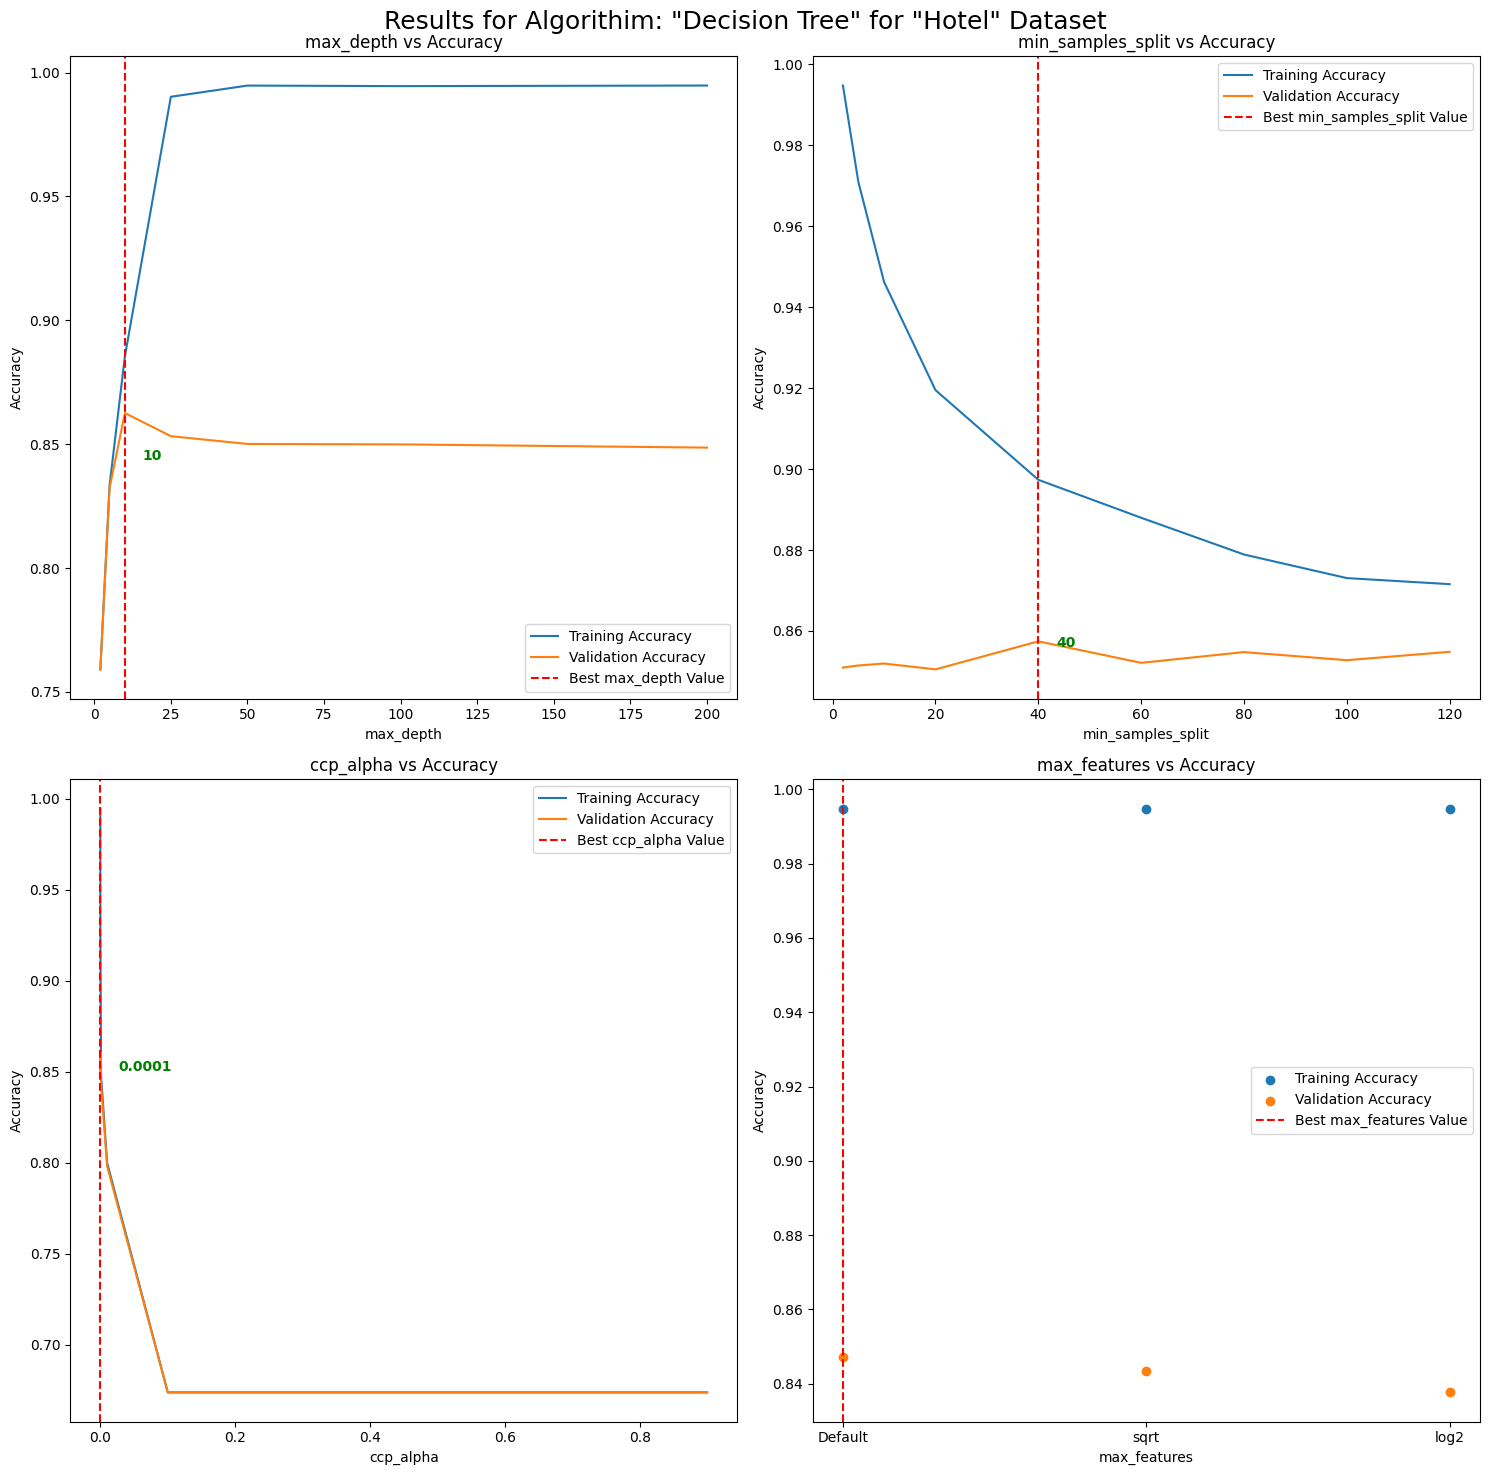

In [14]:
#Hotel Data Accuracy
param_dicts={'max_depth':[2,5,10,25,50,100,200],'min_samples_split':[2,5,10,20,40,60,80,100,120],'ccp_alpha':[0,0.0001,0.001,0.01,0.1,0.5,0.9],'max_features':['Default','sqrt','log2']}
deal_algorithim(train_hotel,param_dicts,'Hotel','Decision Tree',DecisionTreeClassifier)

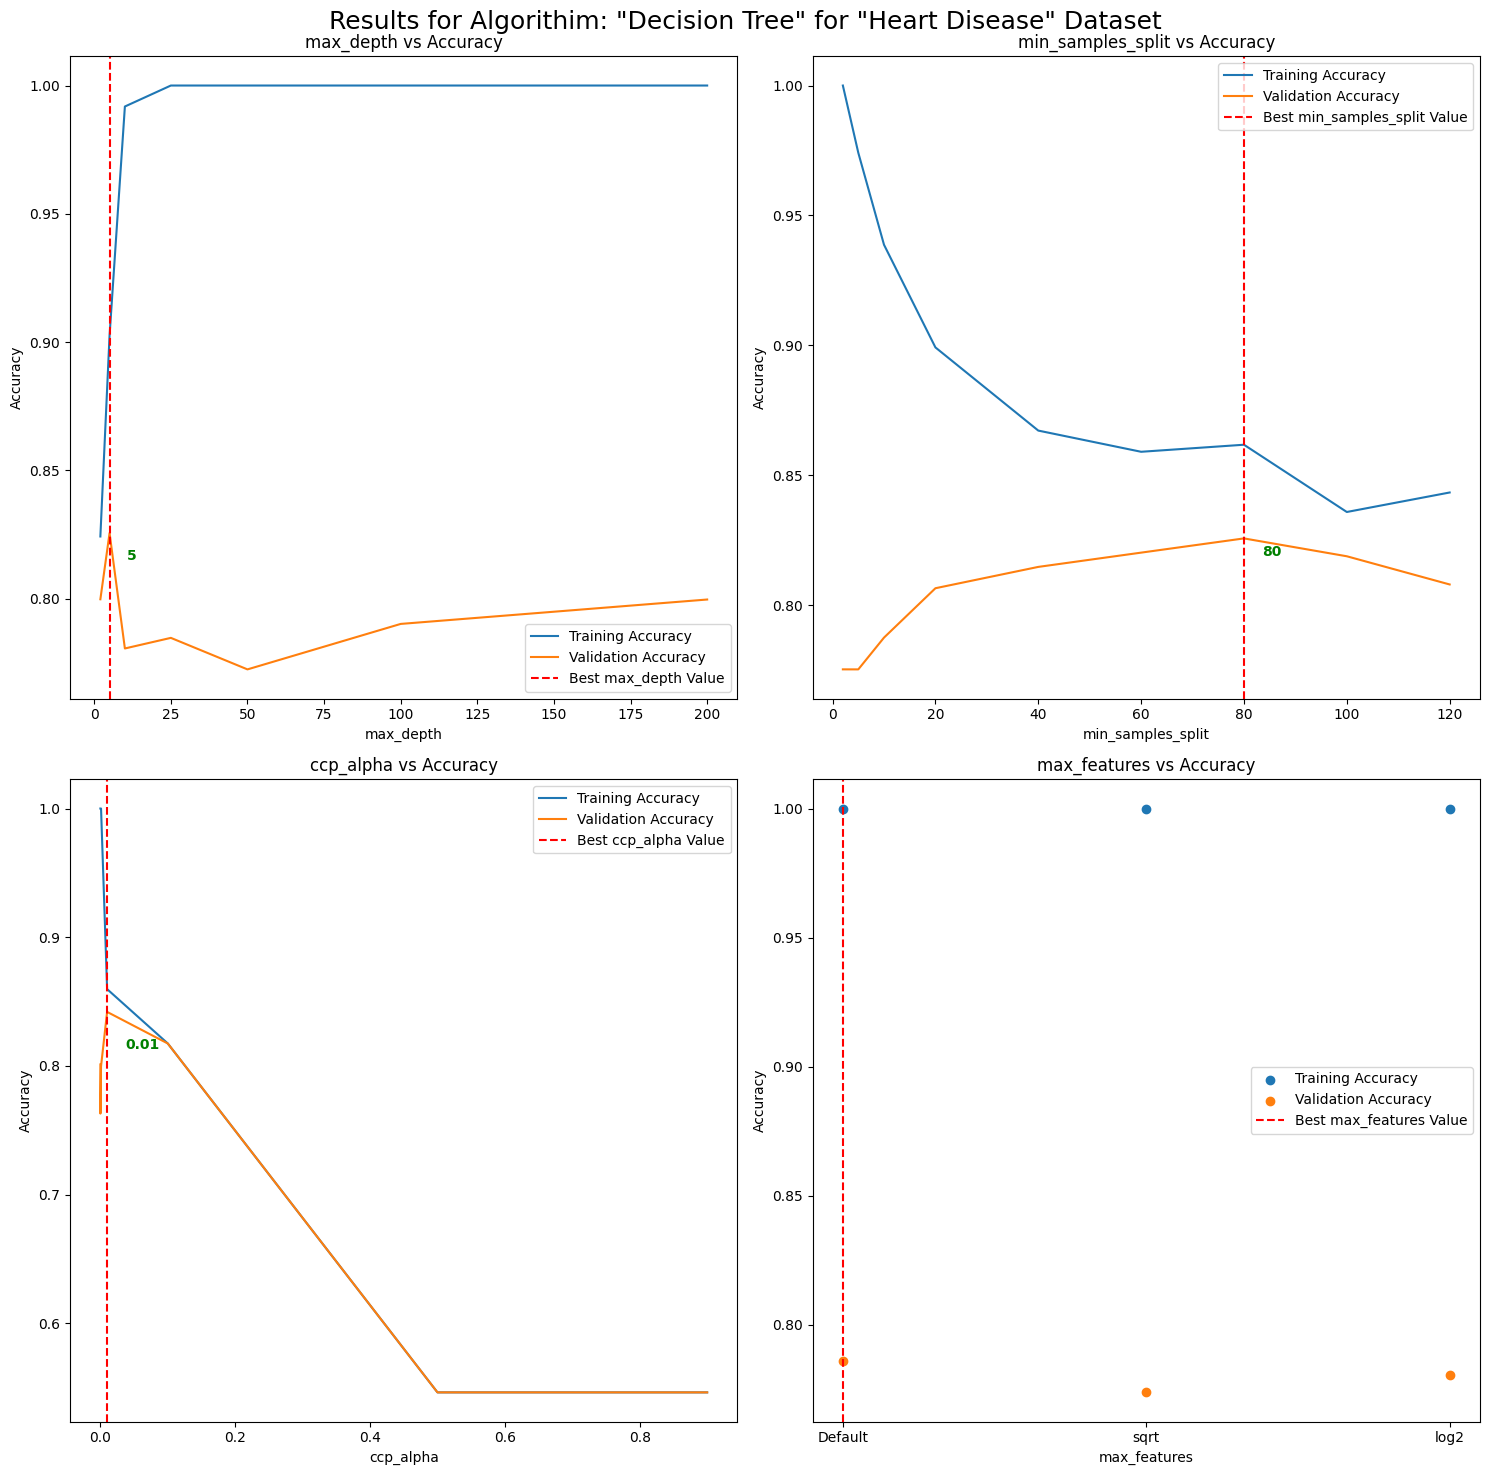

In [16]:
#Heart Data Accuracy
param_dicts={'max_depth':[2,5,10,25,50,100,200],'min_samples_split':[2,5,10,20,40,60,80,100,120],'ccp_alpha':[0,0.0001,0.001,0.01,0.1,0.5,0.9],'max_features':['Default','sqrt','log2']}
deal_algorithim(train_heart,param_dicts,'Heart Disease','Decision Tree',DecisionTreeClassifier)

### Final Results

In [ ]:
#Hotel
param_dicts={'max_depth':[5,10,25],'min_samples_split':[20,40,60],'ccp_alpha':[0.0001,0.001]}
score_algorithim(X=X_hotel,Y=Y_hotel,dataset_name='Hotel Dataset',algorithim_name='Decision Tree Classifier',algorithim=DecisionTreeClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Hotel Dataset Final Results


{'ccp_alpha': 0.0001, 'max_depth': 10, 'min_samples_split': 20}


Average time to train the ideal Decision Tree Classifier was 0.109 seconds
Average time to infer the ideal Decision Tree Classifier was 0.001 seconds


The result on the training data for the ideal Decision Tree Classifier algorithim is a 0.8763611302549965 accuracy score
The result on the test data for the ideal Decision Tree Classifier algorithim is a 0.8665747760165403 accuracy score


In [ ]:
#Heart
param_dicts={'max_depth':[5,10],'min_samples_split':[40,100],'ccp_alpha':[0.001,0.01]}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='Decision Tree Classifier',algorithim=DecisionTreeClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Heart Disease Dataset Final Results


{'ccp_alpha': 0.001, 'max_depth': 5, 'min_samples_split': 40}


Average time to train the ideal Decision Tree Classifier was 0.005 seconds
Average time to infer the ideal Decision Tree Classifier was 0.000 seconds


The result on the training data for the ideal Decision Tree Classifier algorithim is a 0.8637602179836512 accuracy score
The result on the test data for the ideal Decision Tree Classifier algorithim is a 0.8478260869565217 accuracy score


### Experimentation

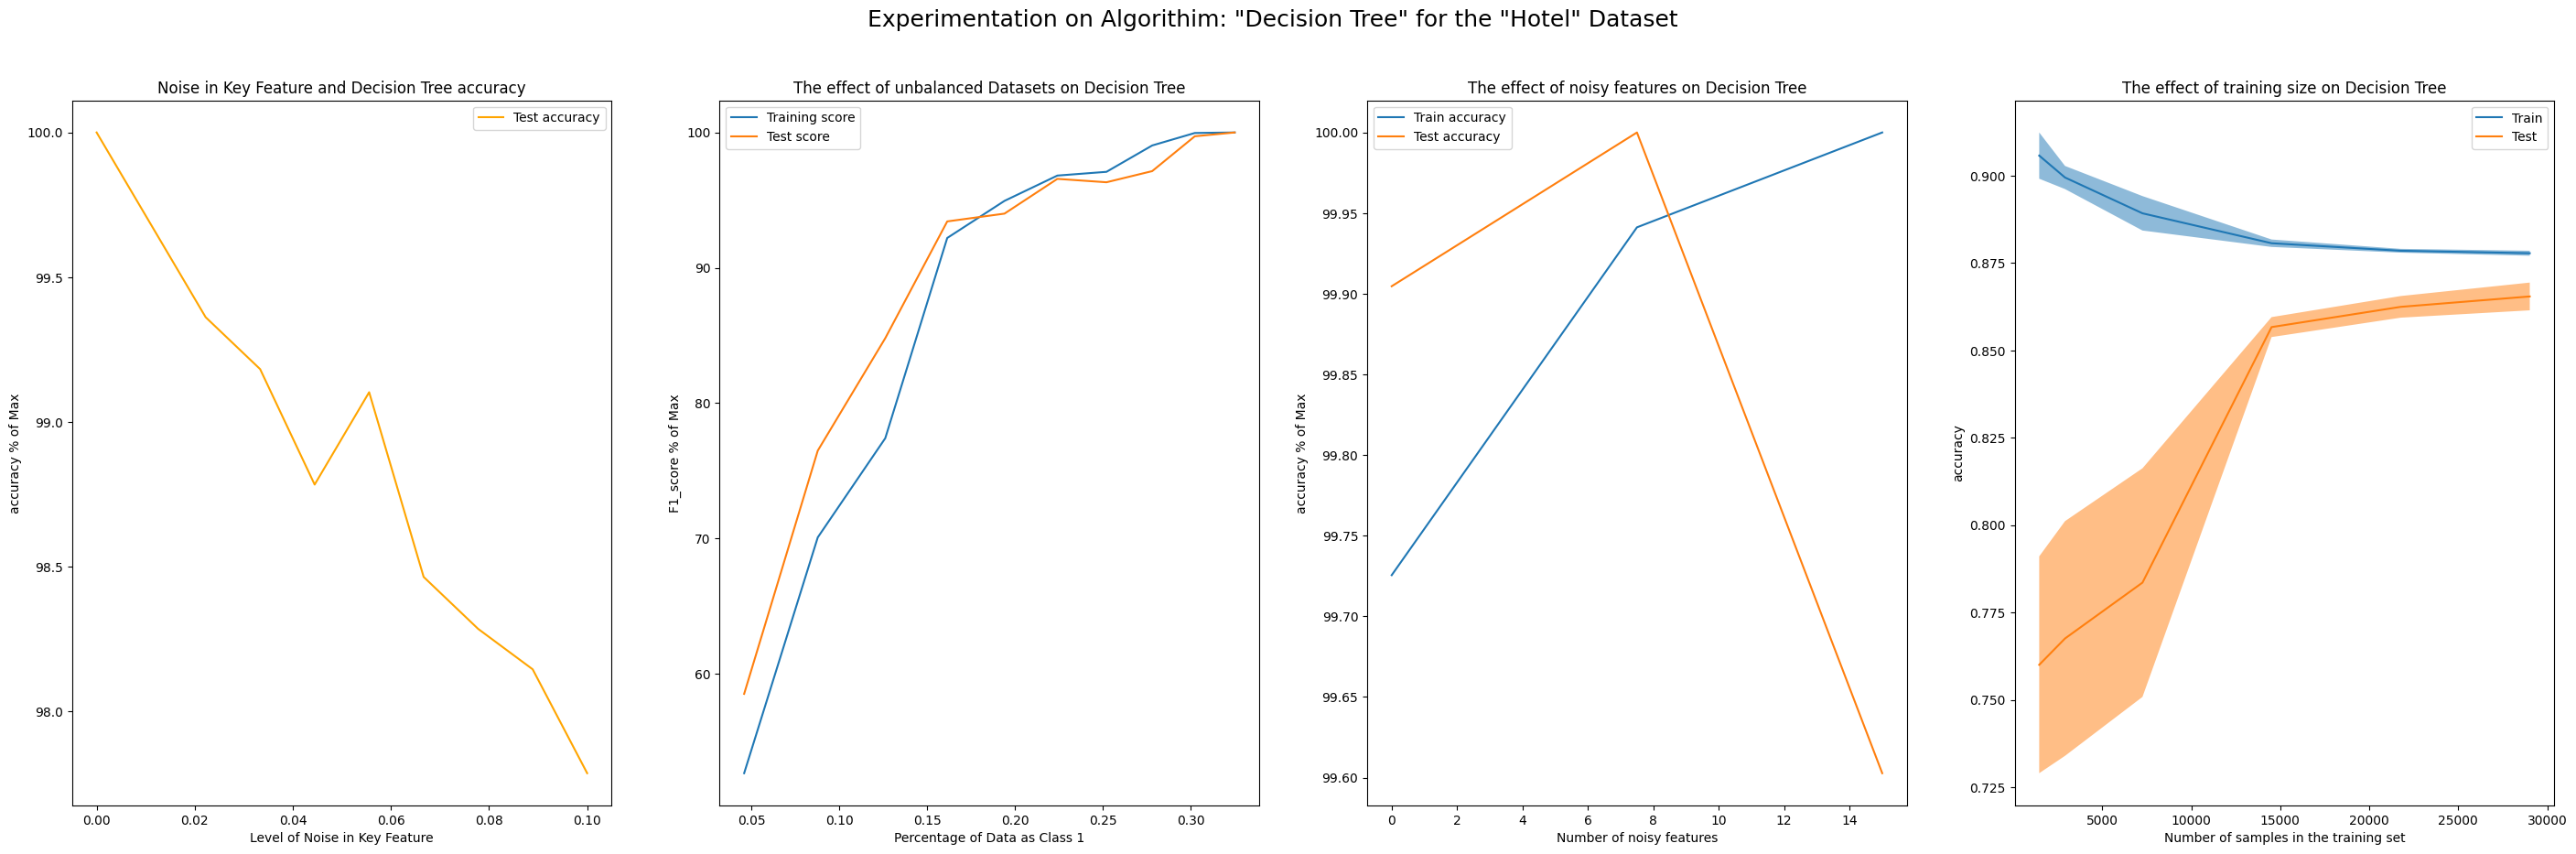

In [81]:
#Experimenting on Hotel Dataset
param_dicts={'max_depth':[5,10,25],'min_samples_split':[20,40,60],'ccp_alpha':[0.0001,0.001]}
experiment_algorithim(data=train_hotel,X=X_hotel,Y=Y_hotel,params=param_dicts,dataset='Hotel',col_index=col_index_hotel,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Decision Tree',algorithim=DecisionTreeClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

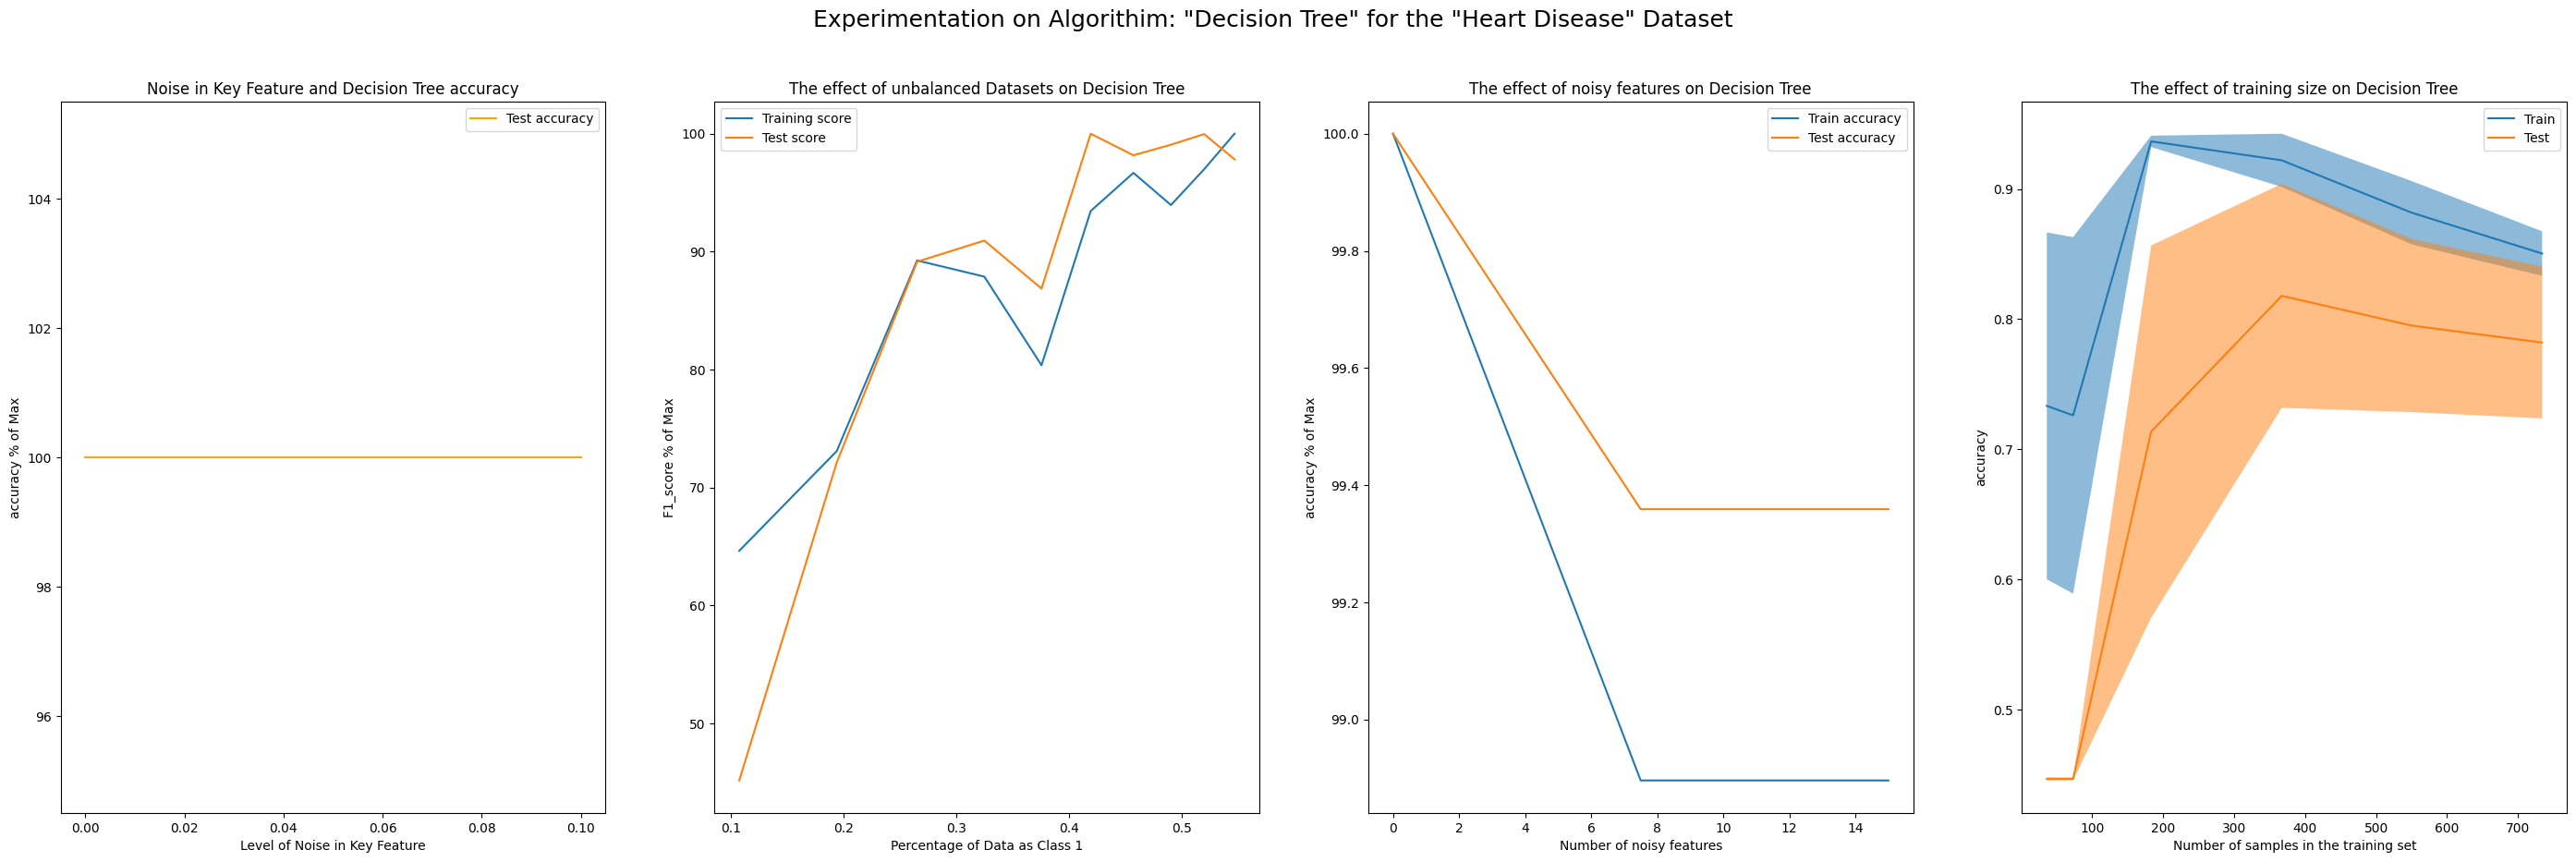

In [95]:
#Experimenting on Heart Dataset
param_dicts={'max_depth':[5,10],'min_samples_split':[40,100],'ccp_alpha':[0.001,0.01]}
experiment_algorithim(data=train_heart,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Decision Tree',algorithim=DecisionTreeClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

# Gradient Boosted Classifier

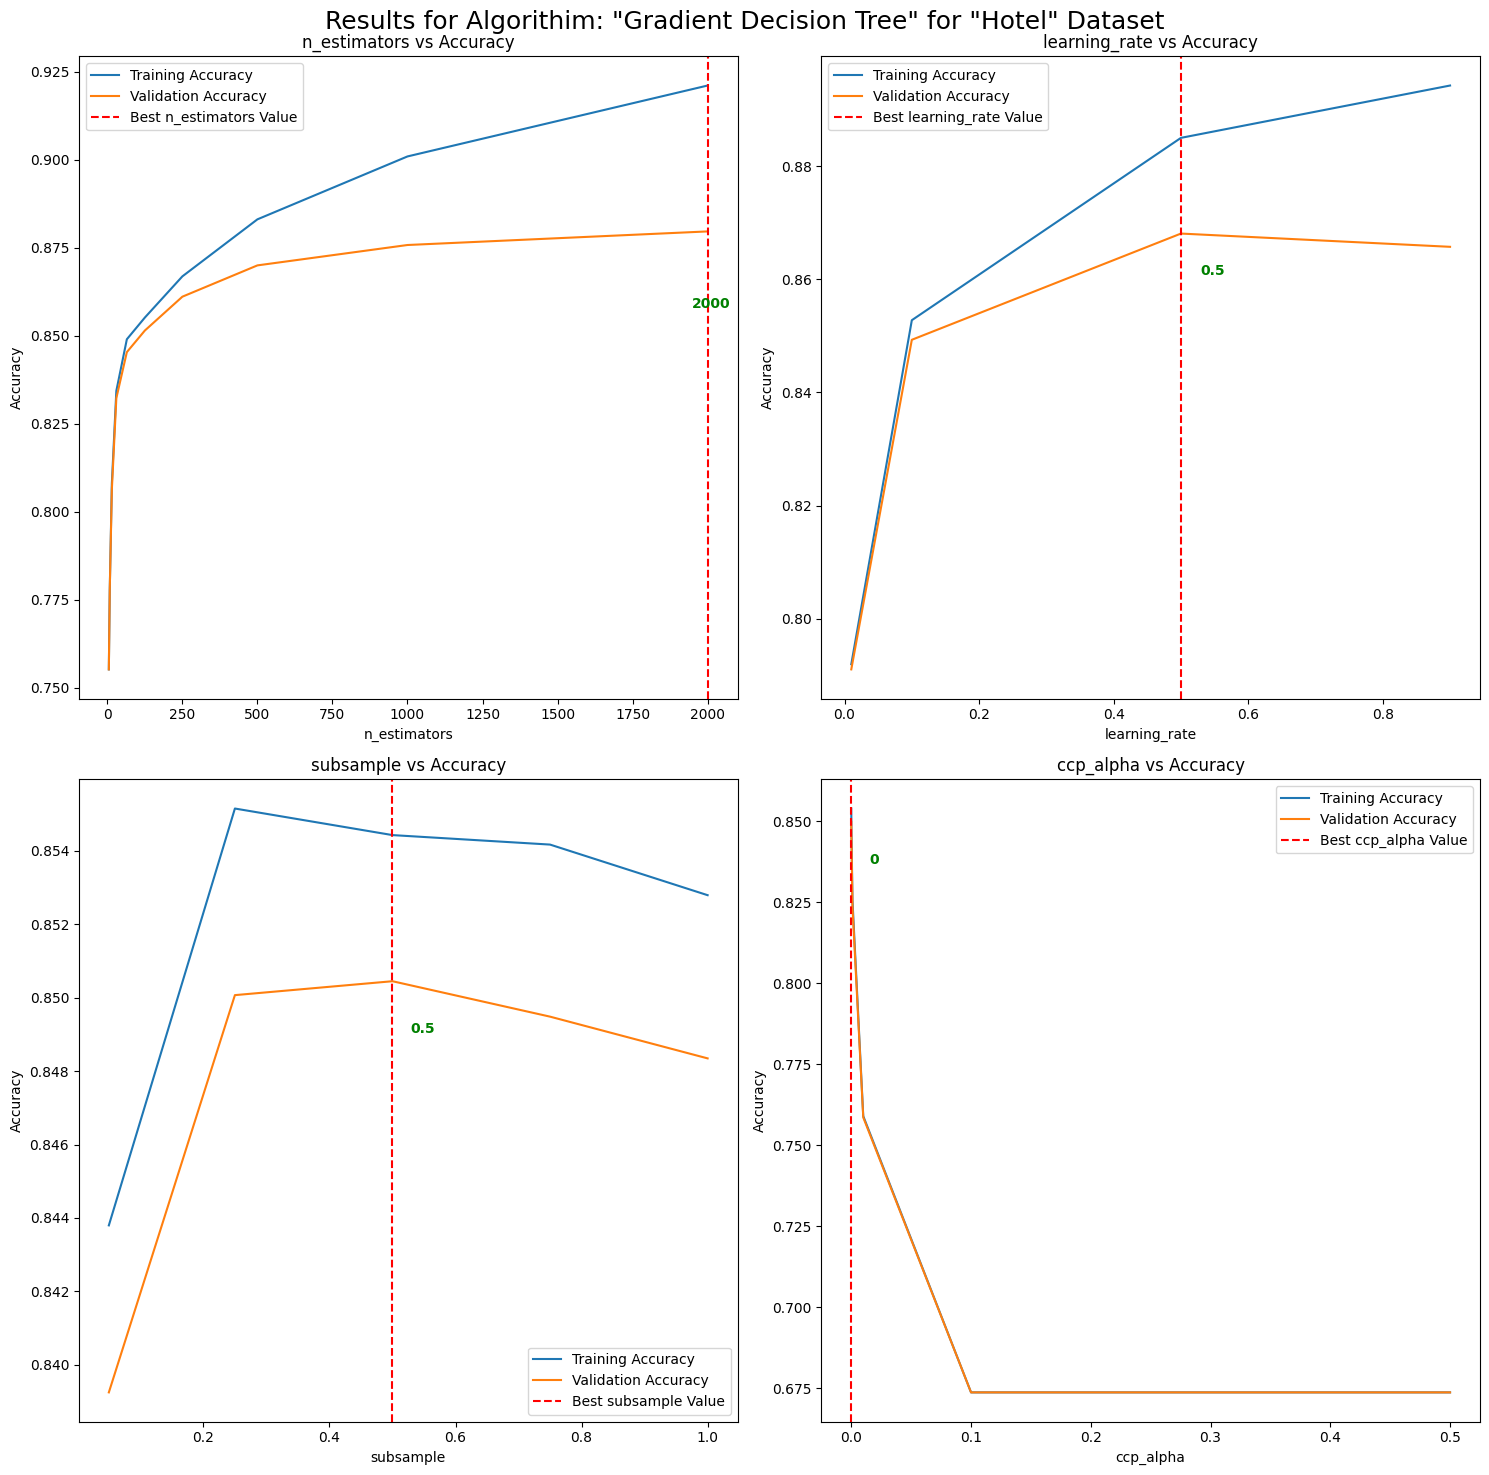

In [171]:
#Hotel
n_estimators_log=[2000,1000,500,250,125,65,30,15,8,5]
learning_rates=[0.9,0.5,0.1,0.01]
subsample_vals=[0.05,0.25,0.5,0.75,1.0]
ccp_alphas=[0,0.0001,0.001,0.01,0.1,0.5]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
deal_algorithim(train_hotel,param_dicts,'Hotel','Gradient Decision Tree',GradientBoostingClassifier)

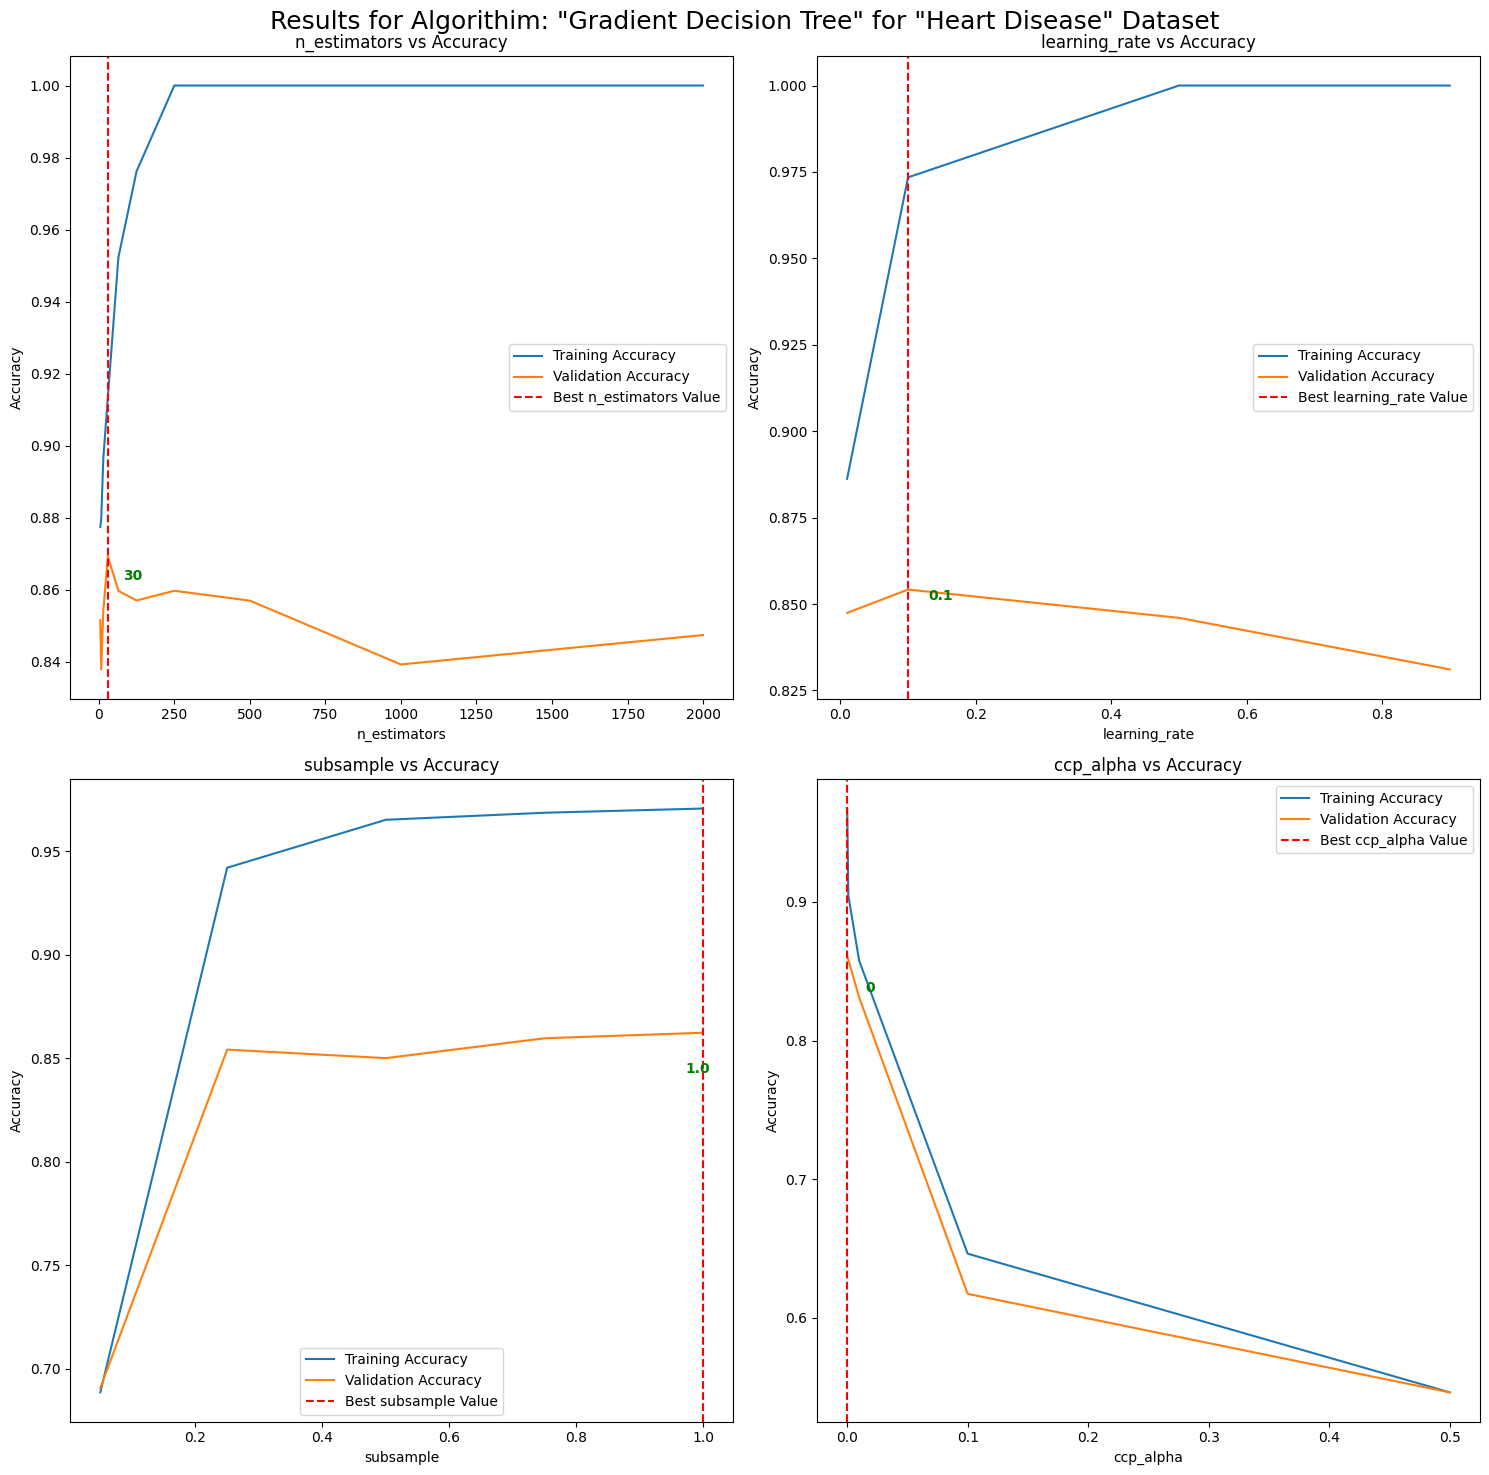

In [172]:
#Gradient Boosted Heart Accuracy
n_estimators_log=[2000,1000,500,250,125,65,30,15,8,5]
learning_rates=[0.9,0.5,0.1,0.01]
subsample_vals=[0.05,0.25,0.5,0.75,1.0]
ccp_alphas=[0,0.0001,0.001,0.01,0.1,0.5]


param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
deal_algorithim(train_heart,param_dicts,'Heart Disease','Gradient Decision Tree',GradientBoostingClassifier)

### Final Results

In [ ]:
#Hotel Scoring
n_estimators_log=[2500,2000]
learning_rates=[0.5,0.25]
subsample_vals=[0.25,0.5]
ccp_alphas=[0,0.0001]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
score_algorithim(X=X_hotel,Y=Y_hotel,dataset_name='Hotel Dataset',algorithim_name='Gradient Decision Tree Classifier',algorithim=GradientBoostingClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Hotel Dataset Final Results


{'ccp_alpha': 0, 'learning_rate': 0.25, 'n_estimators': 2500, 'subsample': 0.5}


Average time to train the ideal Gradient Decision Tree Classifier was 49.762 seconds
Average time to infer the ideal Gradient Decision Tree Classifier was 0.181 seconds


The result on the training data for the ideal Gradient Decision Tree Classifier algorithim is a 0.943039283252929 accuracy score
The result on the test data for the ideal Gradient Decision Tree Classifier algorithim is a 0.875947622329428 accuracy score


In [ ]:
#Heart Disease Scoring Accuracy
n_estimators_log=[25,50]
learning_rates=[0.1,0.25]
subsample_vals=[0.5,1]
ccp_alphas=[0,0.0001]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='Gradient Decision Tree',algorithim=GradientBoostingClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Heart Disease Dataset Final Results


{'ccp_alpha': 0.0001, 'learning_rate': 0.1, 'n_estimators': 50, 'subsample': 1}


Average time to train the ideal Gradient Decision Tree was 0.456 seconds
Average time to infer the ideal Gradient Decision Tree was 0.000 seconds


The result on the training data for the ideal Gradient Decision Tree algorithim is a 0.9223433242506812 accuracy score
The result on the test data for the ideal Gradient Decision Tree algorithim is a 0.8695652173913043 accuracy score


### Experimentation

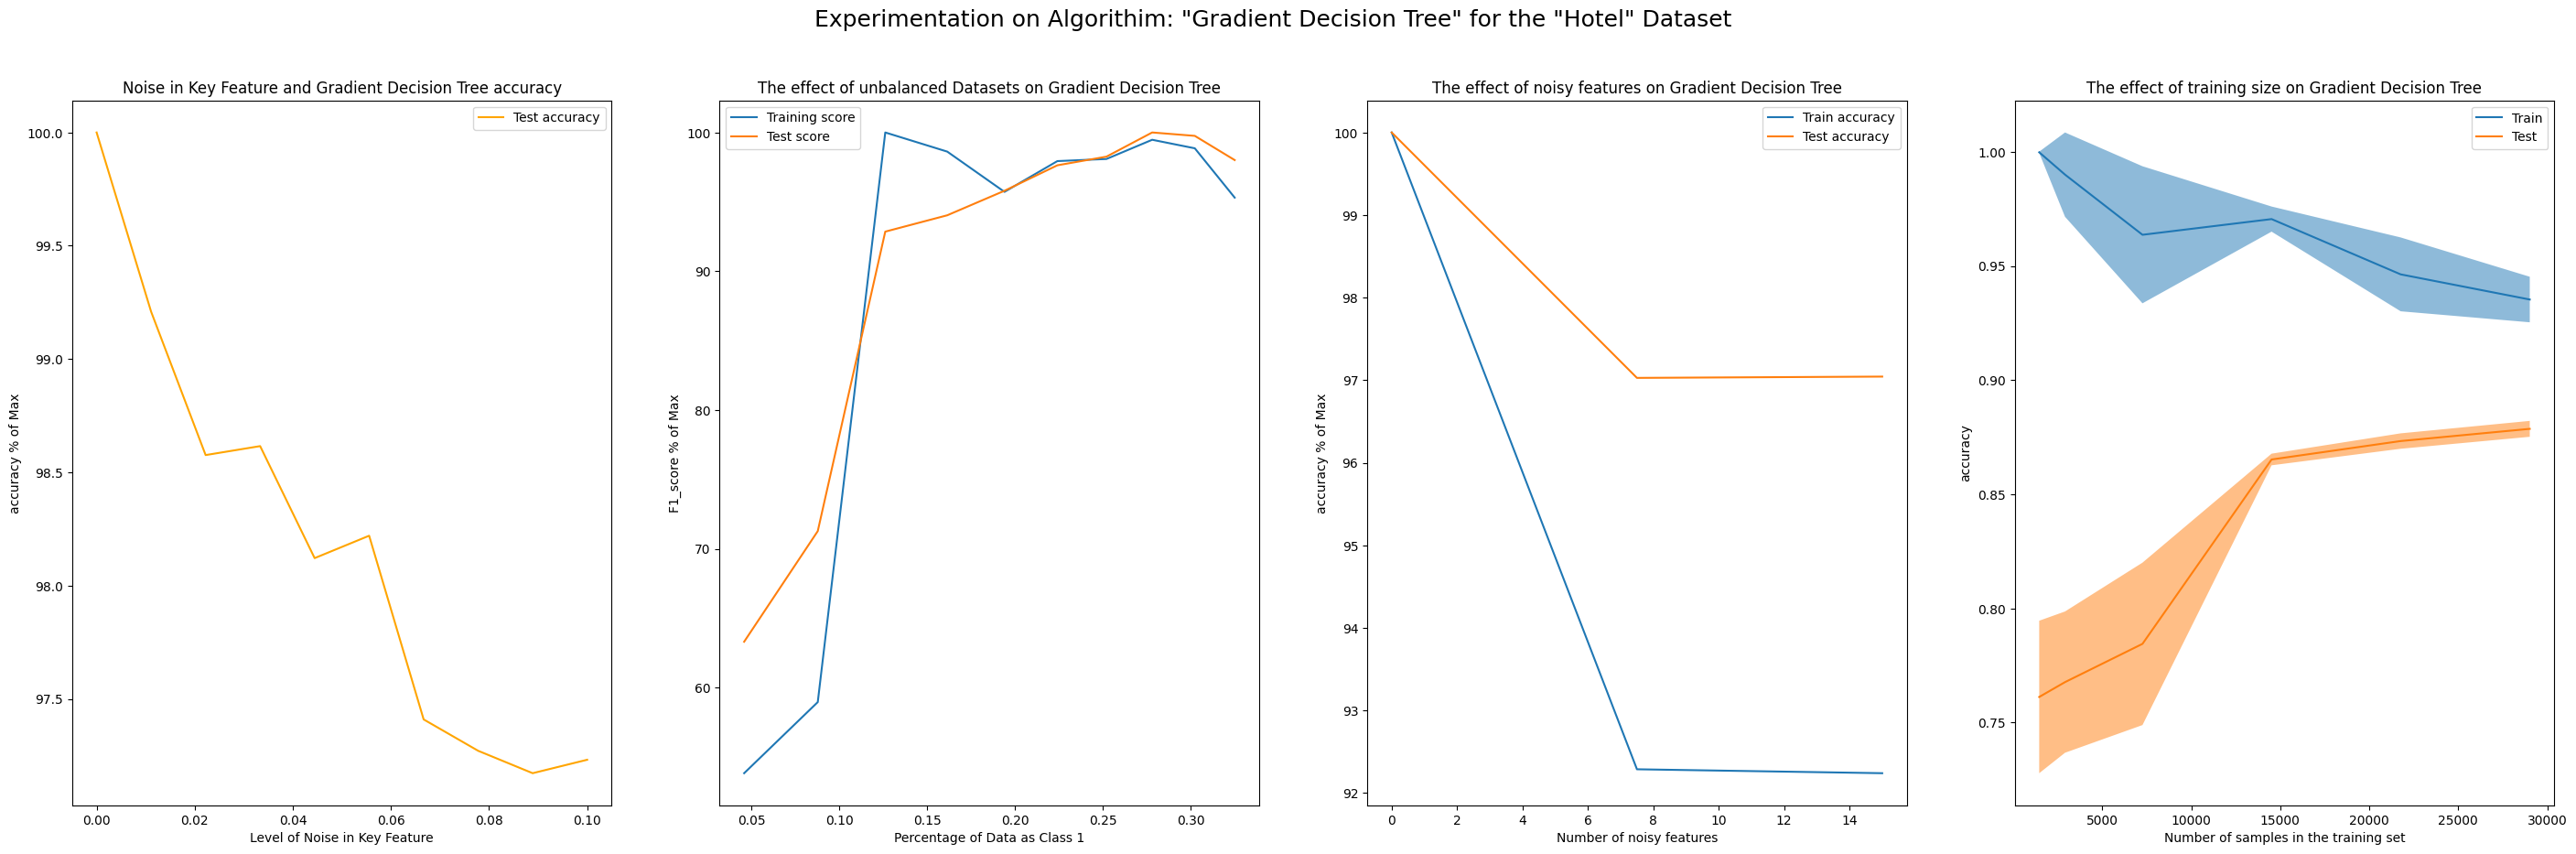

In [92]:
#Gradient Boosted Hotel Experimentation
n_estimators_log=[2500,2000]
learning_rates=[0.5,0.25]
subsample_vals=[0.25,0.5]
ccp_alphas=[0,0.0001]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
experiment_algorithim(data=train_hotel,X=X_hotel,Y=Y_hotel,params=param_dicts,dataset='Hotel',col_index=col_index_hotel,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Gradient Decision Tree',algorithim=GradientBoostingClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

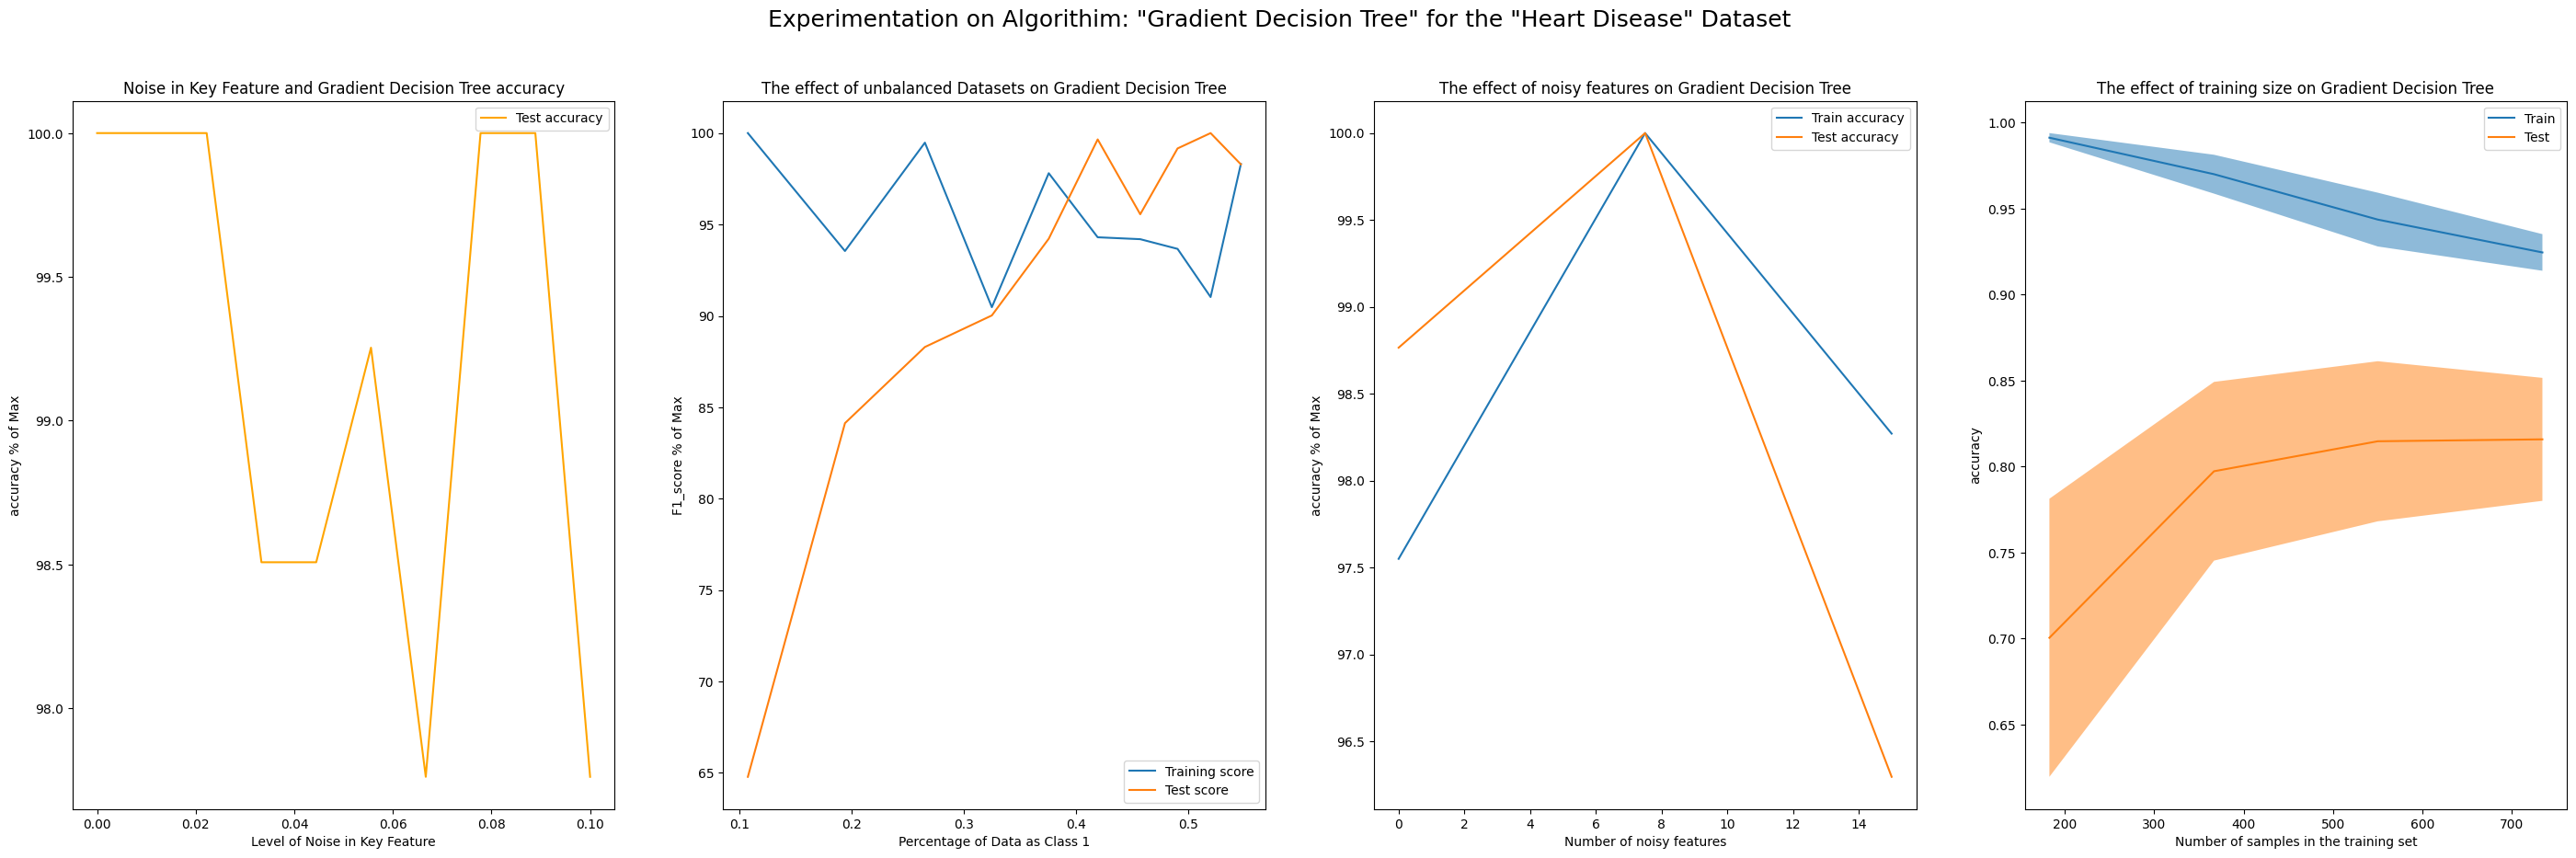

In [83]:
#Heart Accuracy Score Experimentation
n_estimators_log=[25,50]
learning_rates=[0.1,0.25]
subsample_vals=[0.5,1]
ccp_alphas=[0,0.0001]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
experiment_algorithim(data=train_heart,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Gradient Decision Tree',algorithim=GradientBoostingClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

# KNN

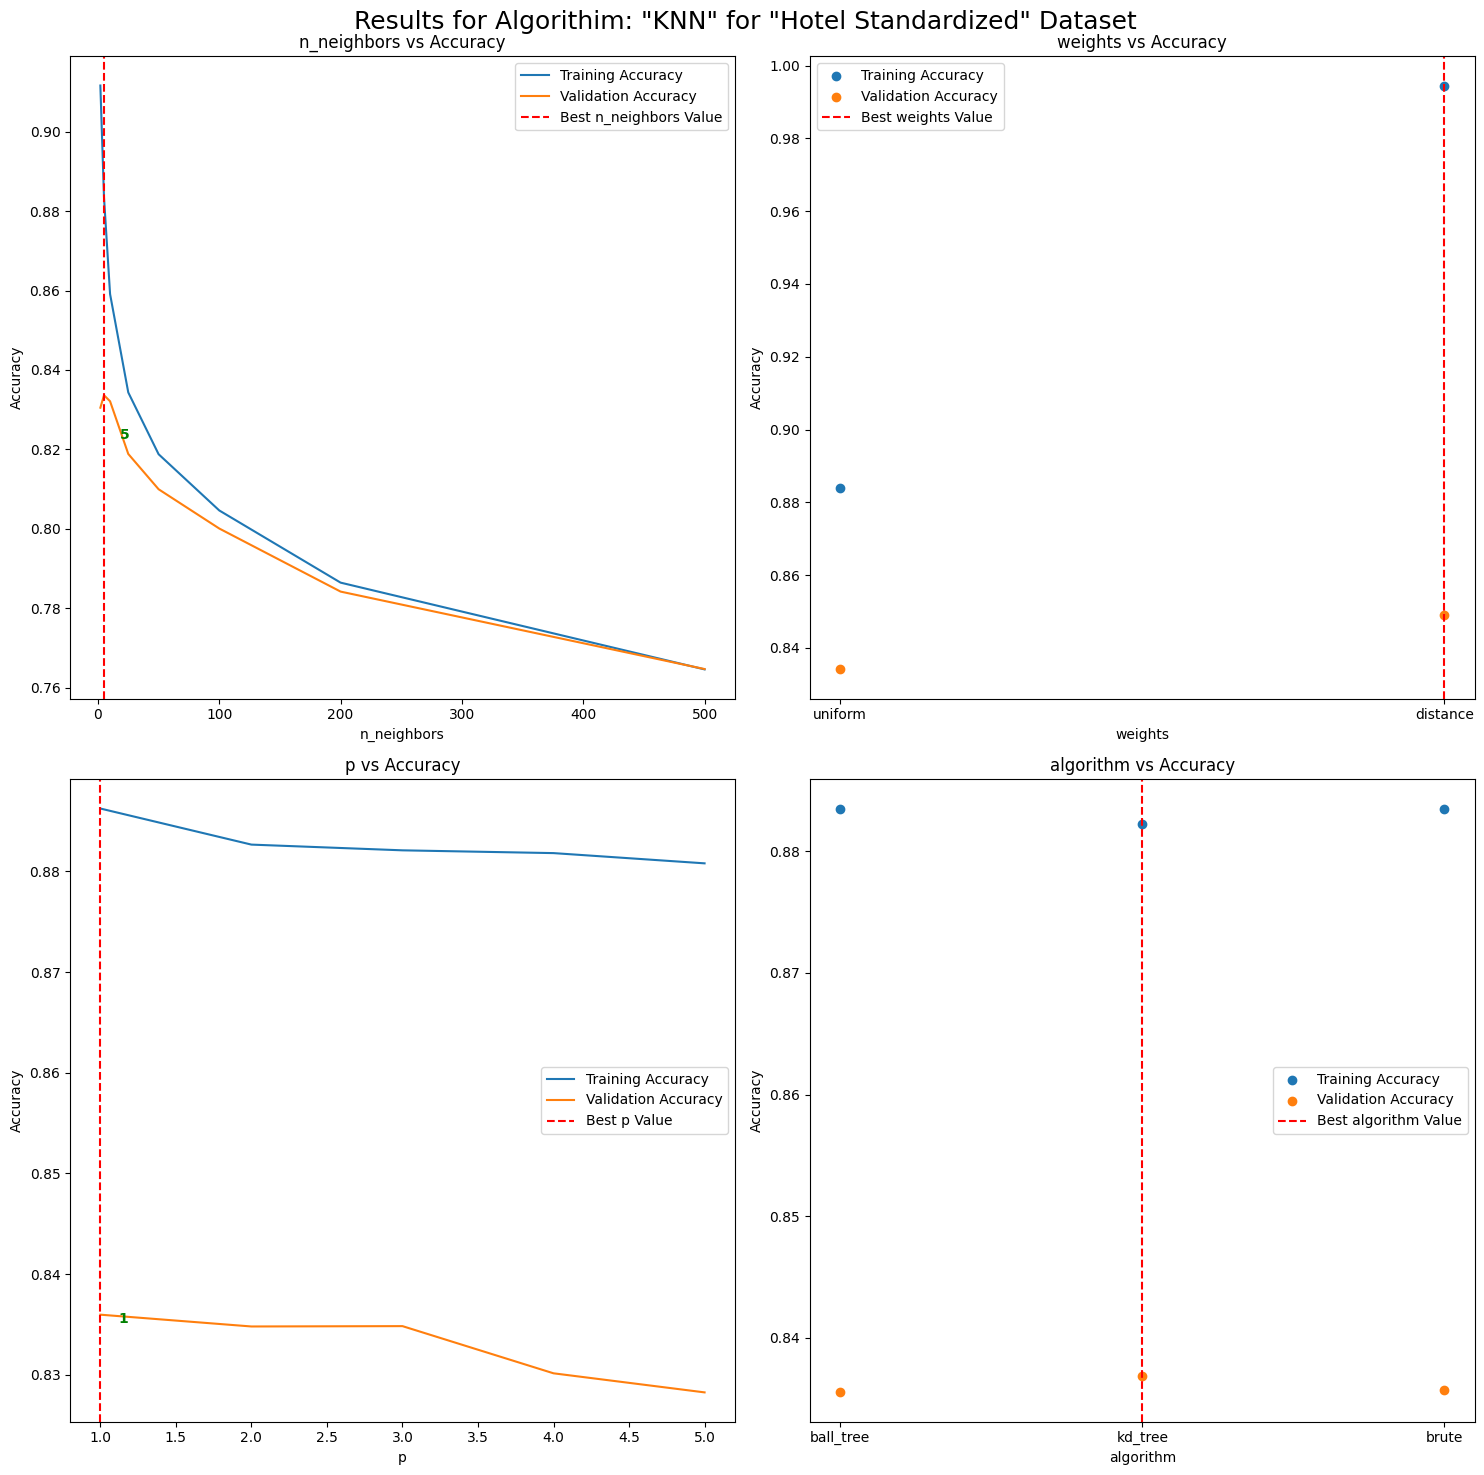

In [84]:
#Hotel Standardize
param_dicts={'n_neighbors':[2,5,10,25,50,100,200,500],'weights':['uniform','distance'],'p':[1,2,3,4,5],'algorithm':['ball_tree','kd_tree','brute']}
deal_algorithim(train_hotel_standardized,param_dicts,'Hotel Standardized','KNN',KNeighborsClassifier)

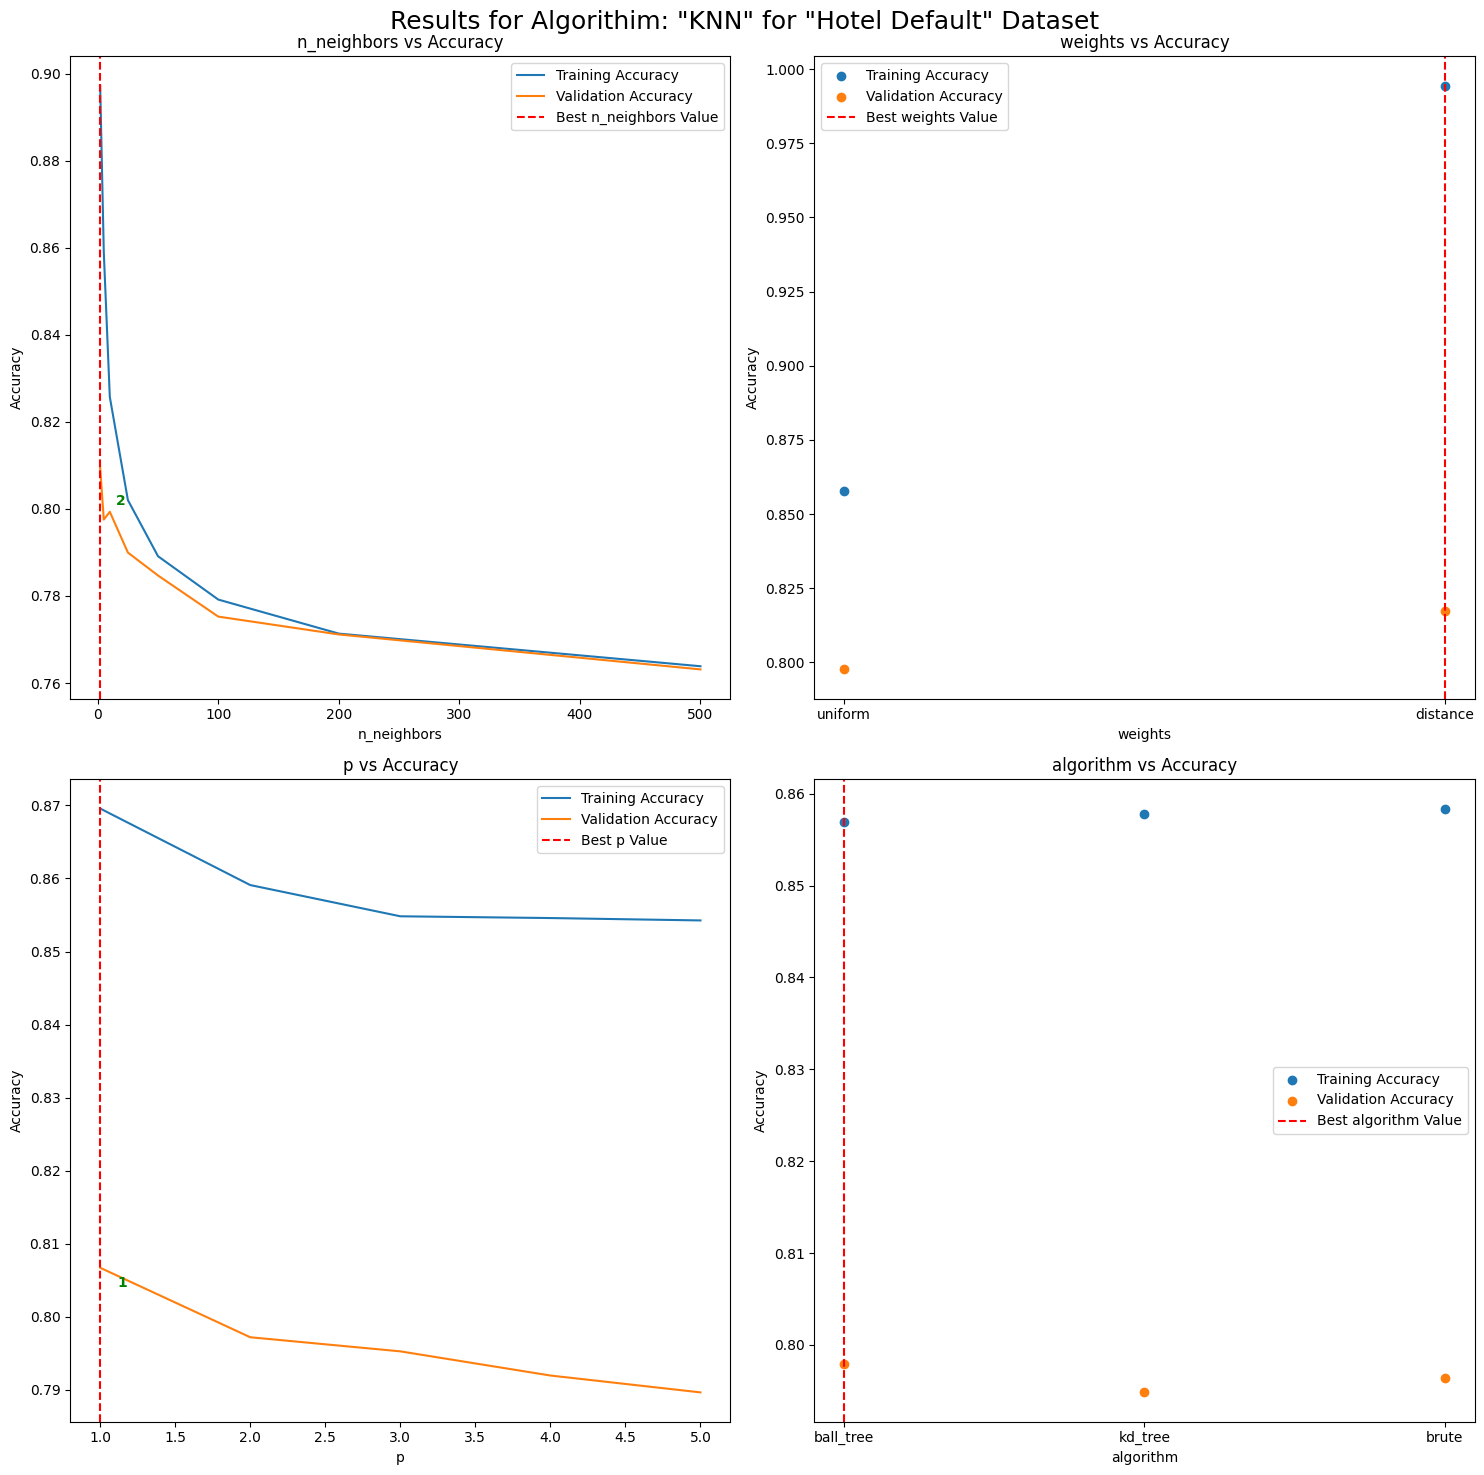

In [85]:
#Unstandarized
param_dicts={'n_neighbors':[2,5,10,25,50,100,200,500],'weights':['uniform','distance'],'p':[1,2,3,4,5],'algorithm':['ball_tree','kd_tree','brute']}
deal_algorithim(train_hotel_unstandardized,param_dicts,'Hotel Default','KNN',KNeighborsClassifier)

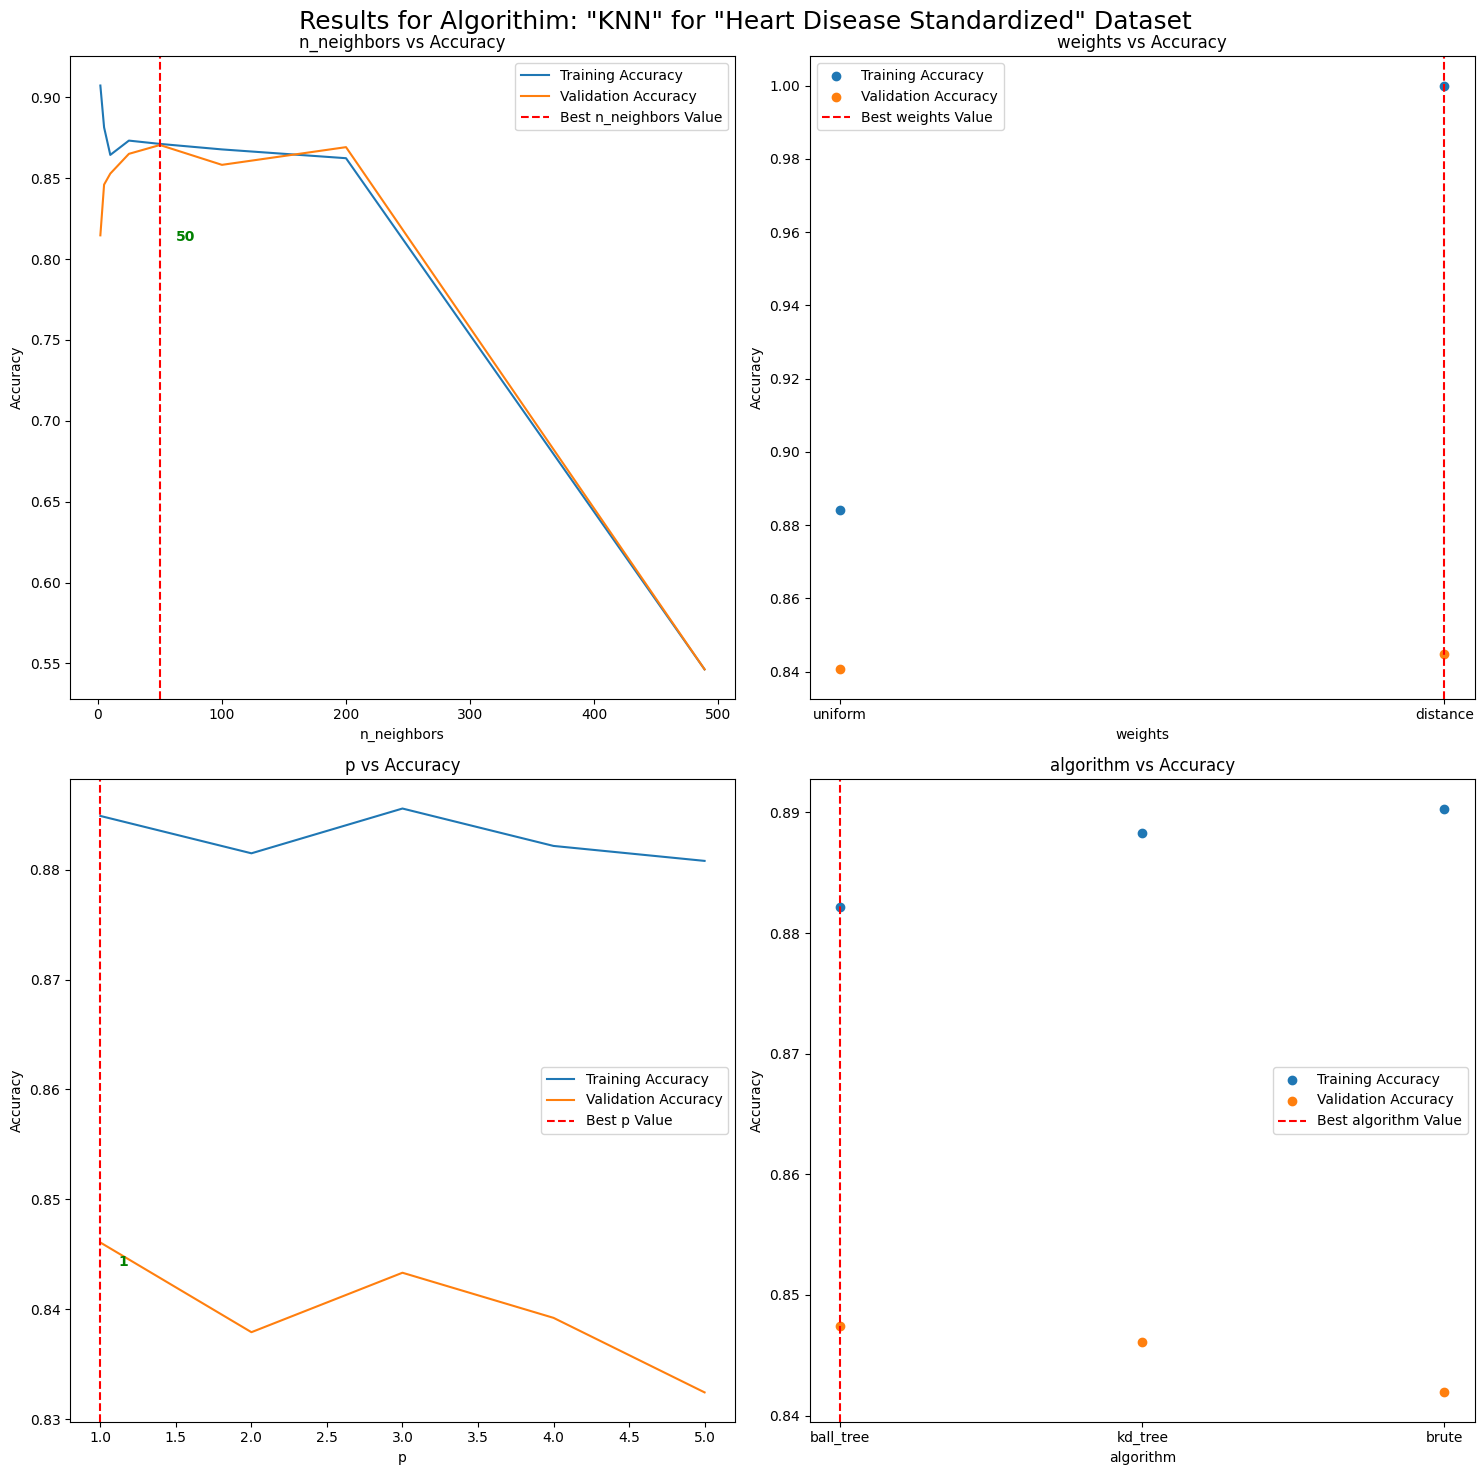

In [19]:
#Heart Standardized
param_dicts={'n_neighbors':[2,5,10,25,50,100,200,489],'weights':['uniform','distance'],'p':[1,2,3,4,5],'algorithm':['ball_tree','kd_tree','brute']}
deal_algorithim(train_heart_standardized,param_dicts,'Heart Disease Standardized','KNN',KNeighborsClassifier)

### Final Results

In [185]:
#Final Hotel Dataset Results
param_dicts={'n_neighbors':[5,10],'weights':['distance'],'p':[1]}
score_algorithim(X=X_hotel,Y=Y_hotel,dataset_name='Hotel Dataset',algorithim_name='KNN',algorithim=KNeighborsClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Hotel Dataset Final Results


{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


Average time to train the ideal KNN was 0.352 seconds
Average time to infer the ideal KNN was 0.594 seconds


The result on the training data for the ideal KNN algorithim is a 0.9939007580978635 accuracy score
The result on the test data for the ideal KNN algorithim is a 0.8698828394210889 accuracy score


In [186]:
#Final Heart Disease Dataset Results Accuracy

param_dicts={'n_neighbors':[10,25],'weights':['distance'],'p':[1,2,4]}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='KNN',algorithim=KNeighborsClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Heart Disease Dataset Final Results


{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}


Average time to train the ideal KNN was 0.007 seconds
Average time to infer the ideal KNN was 0.013 seconds


The result on the training data for the ideal KNN algorithim is a 1.0 accuracy score
The result on the test data for the ideal KNN algorithim is a 0.8641304347826086 accuracy score


### Experimentation

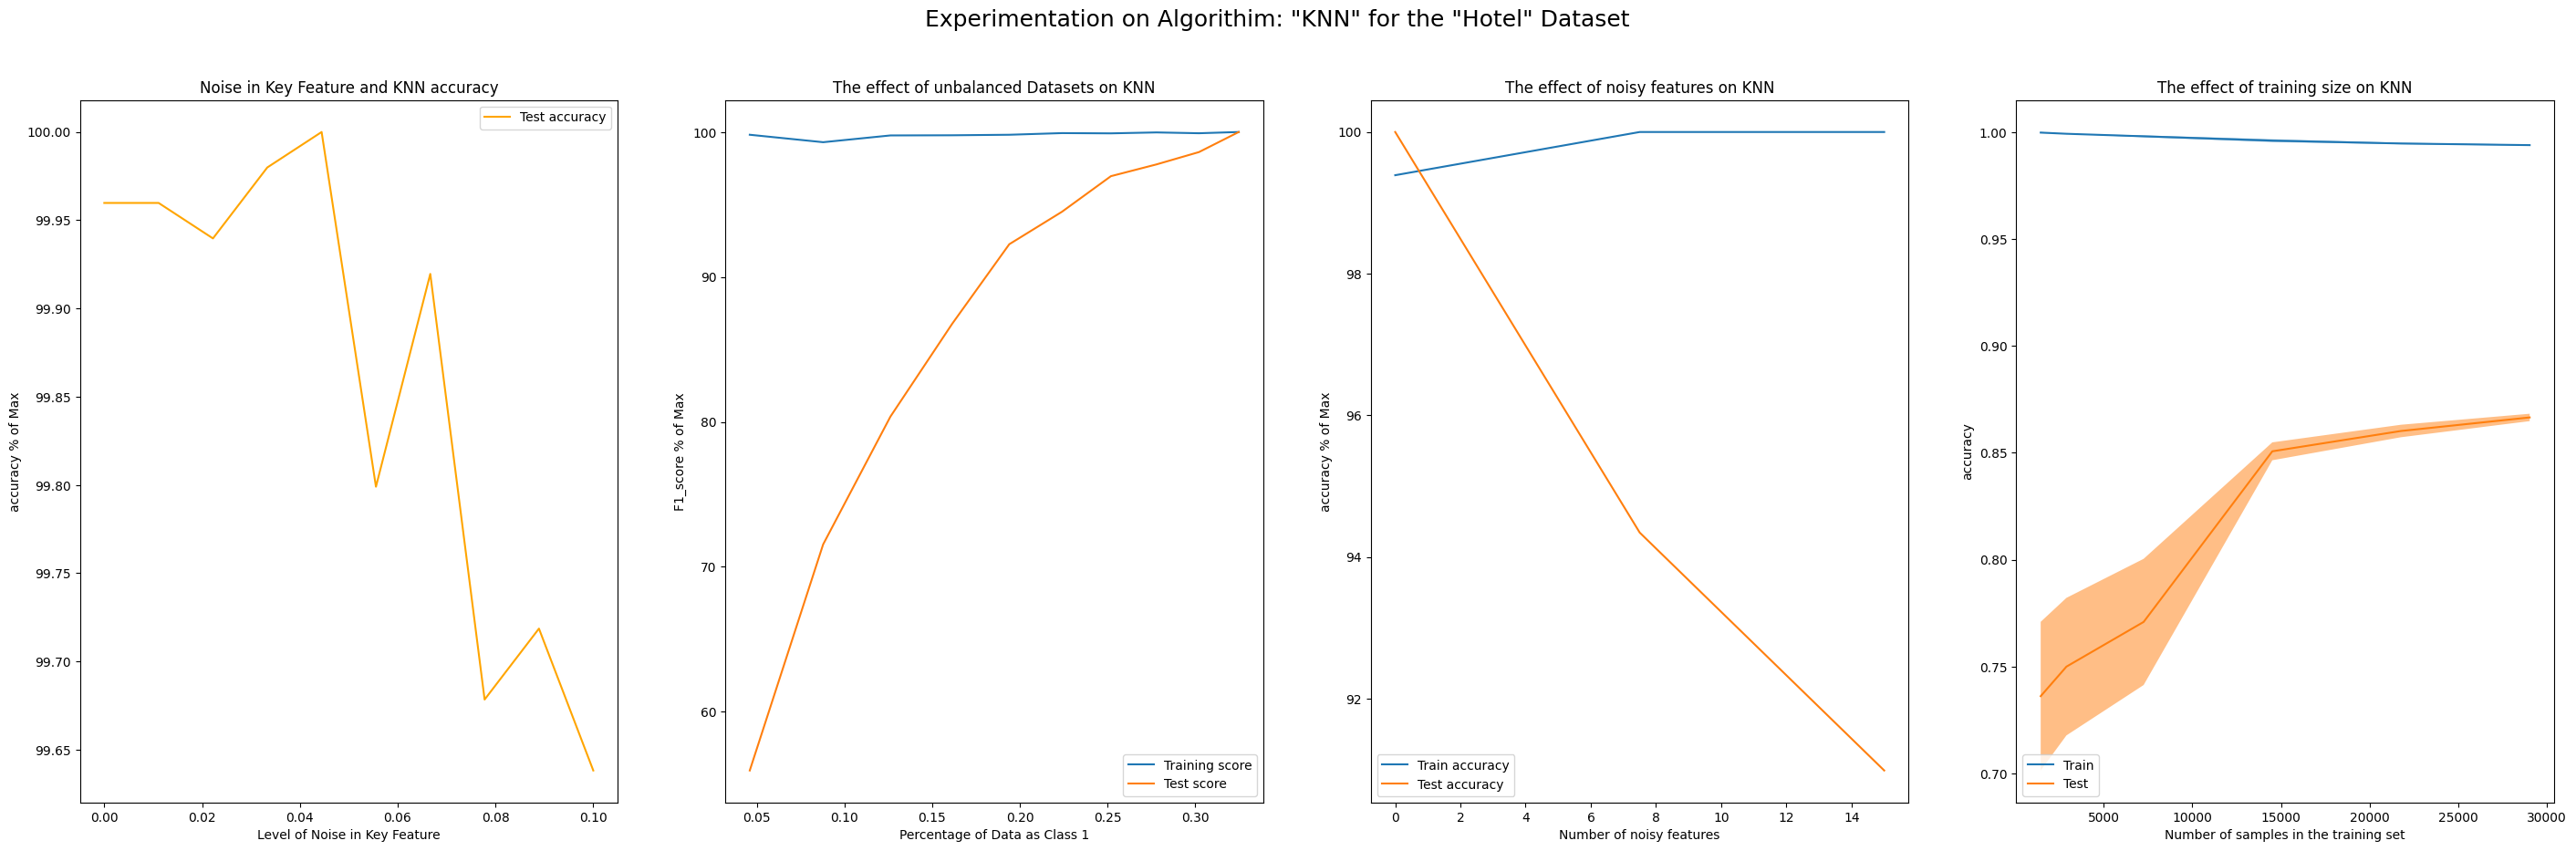

In [86]:
#Hotel Experimentation
param_dicts={'n_neighbors':[5,10],'weights':['distance'],'p':[1]}

experiment_algorithim(data=train_hotel_standardized,X=X_hotel,Y=Y_hotel,params=param_dicts,dataset='Hotel',col_index=col_index_hotel,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='KNN',algorithim=KNeighborsClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

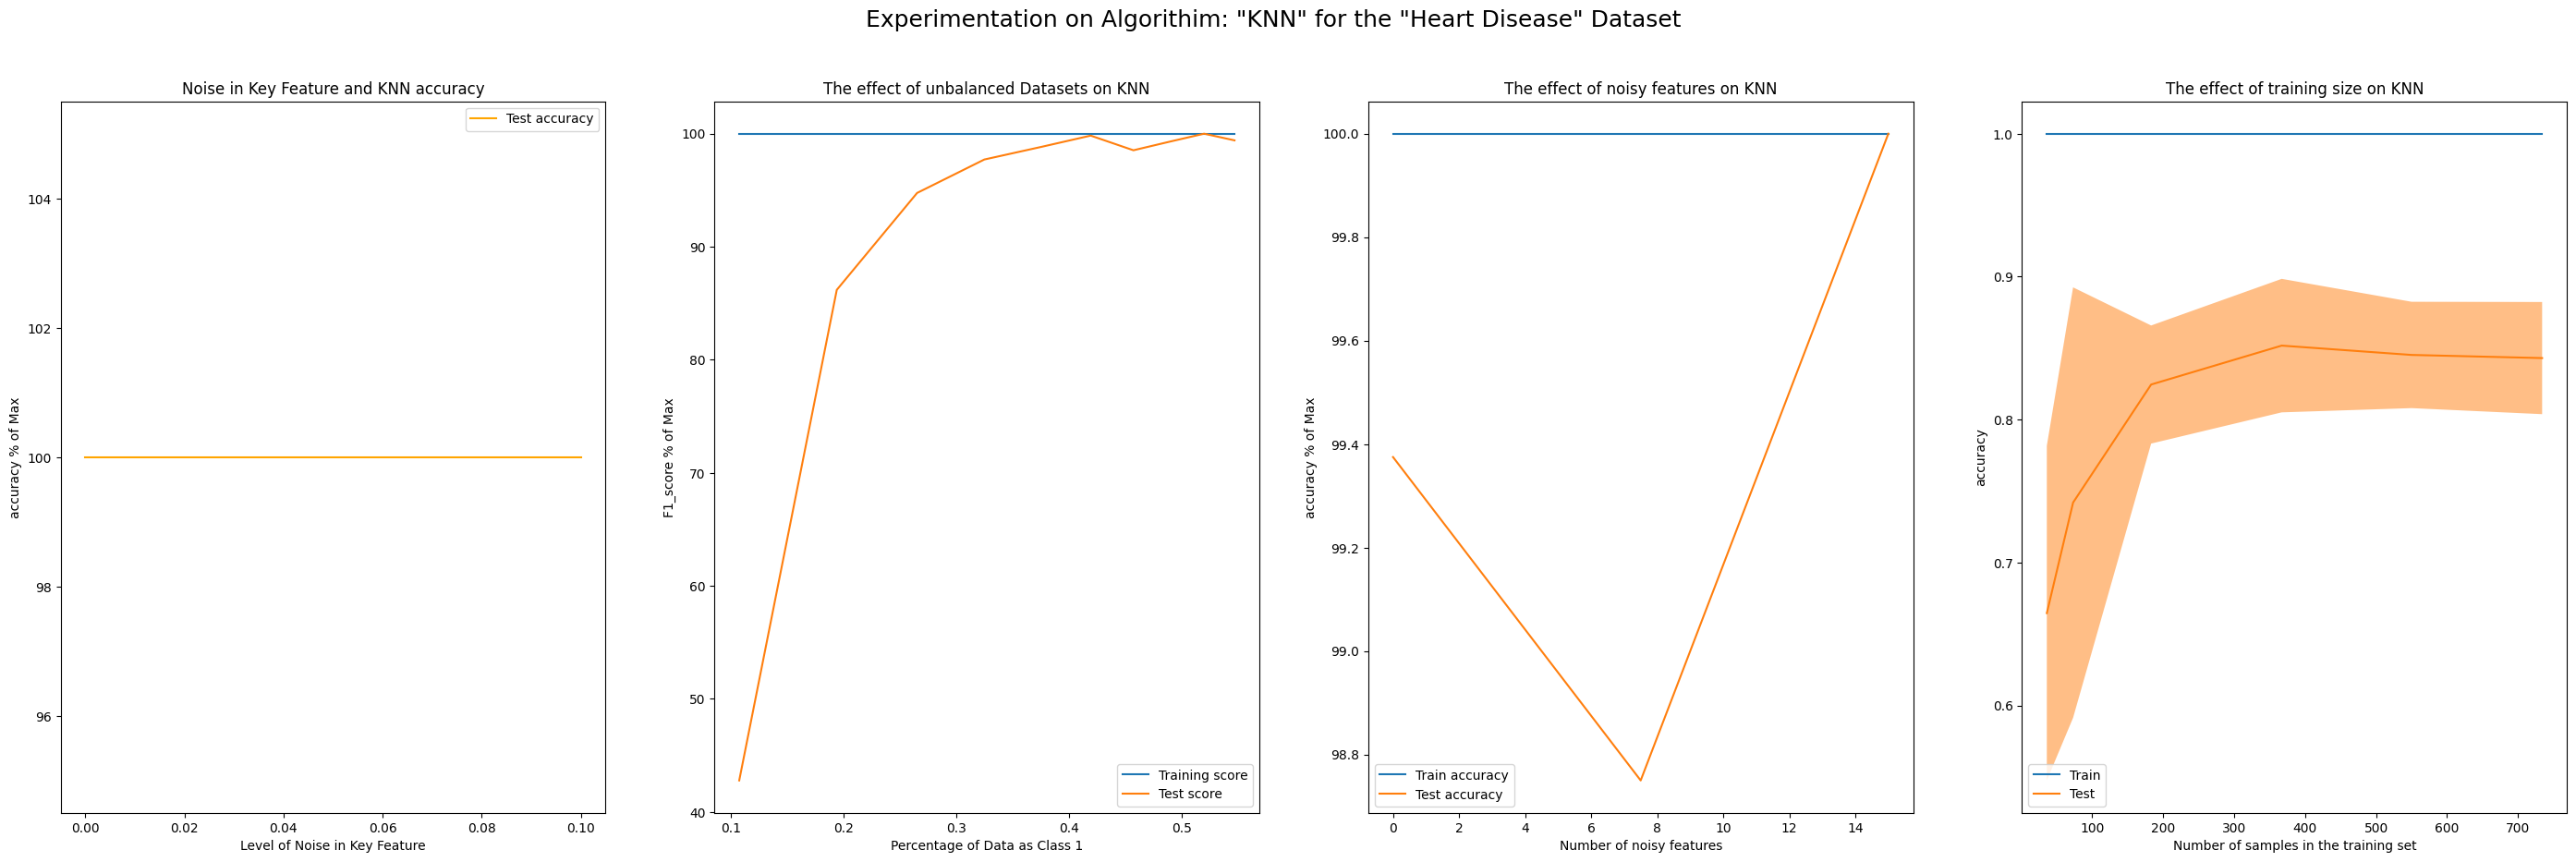

In [106]:
#Heart Experimentation
param_dicts={'n_neighbors':[10,25],'weights':['distance'],'p':[1,2,4]}

experiment_algorithim(data=train_heart_standardized,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='KNN',algorithim=KNeighborsClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

# SVM

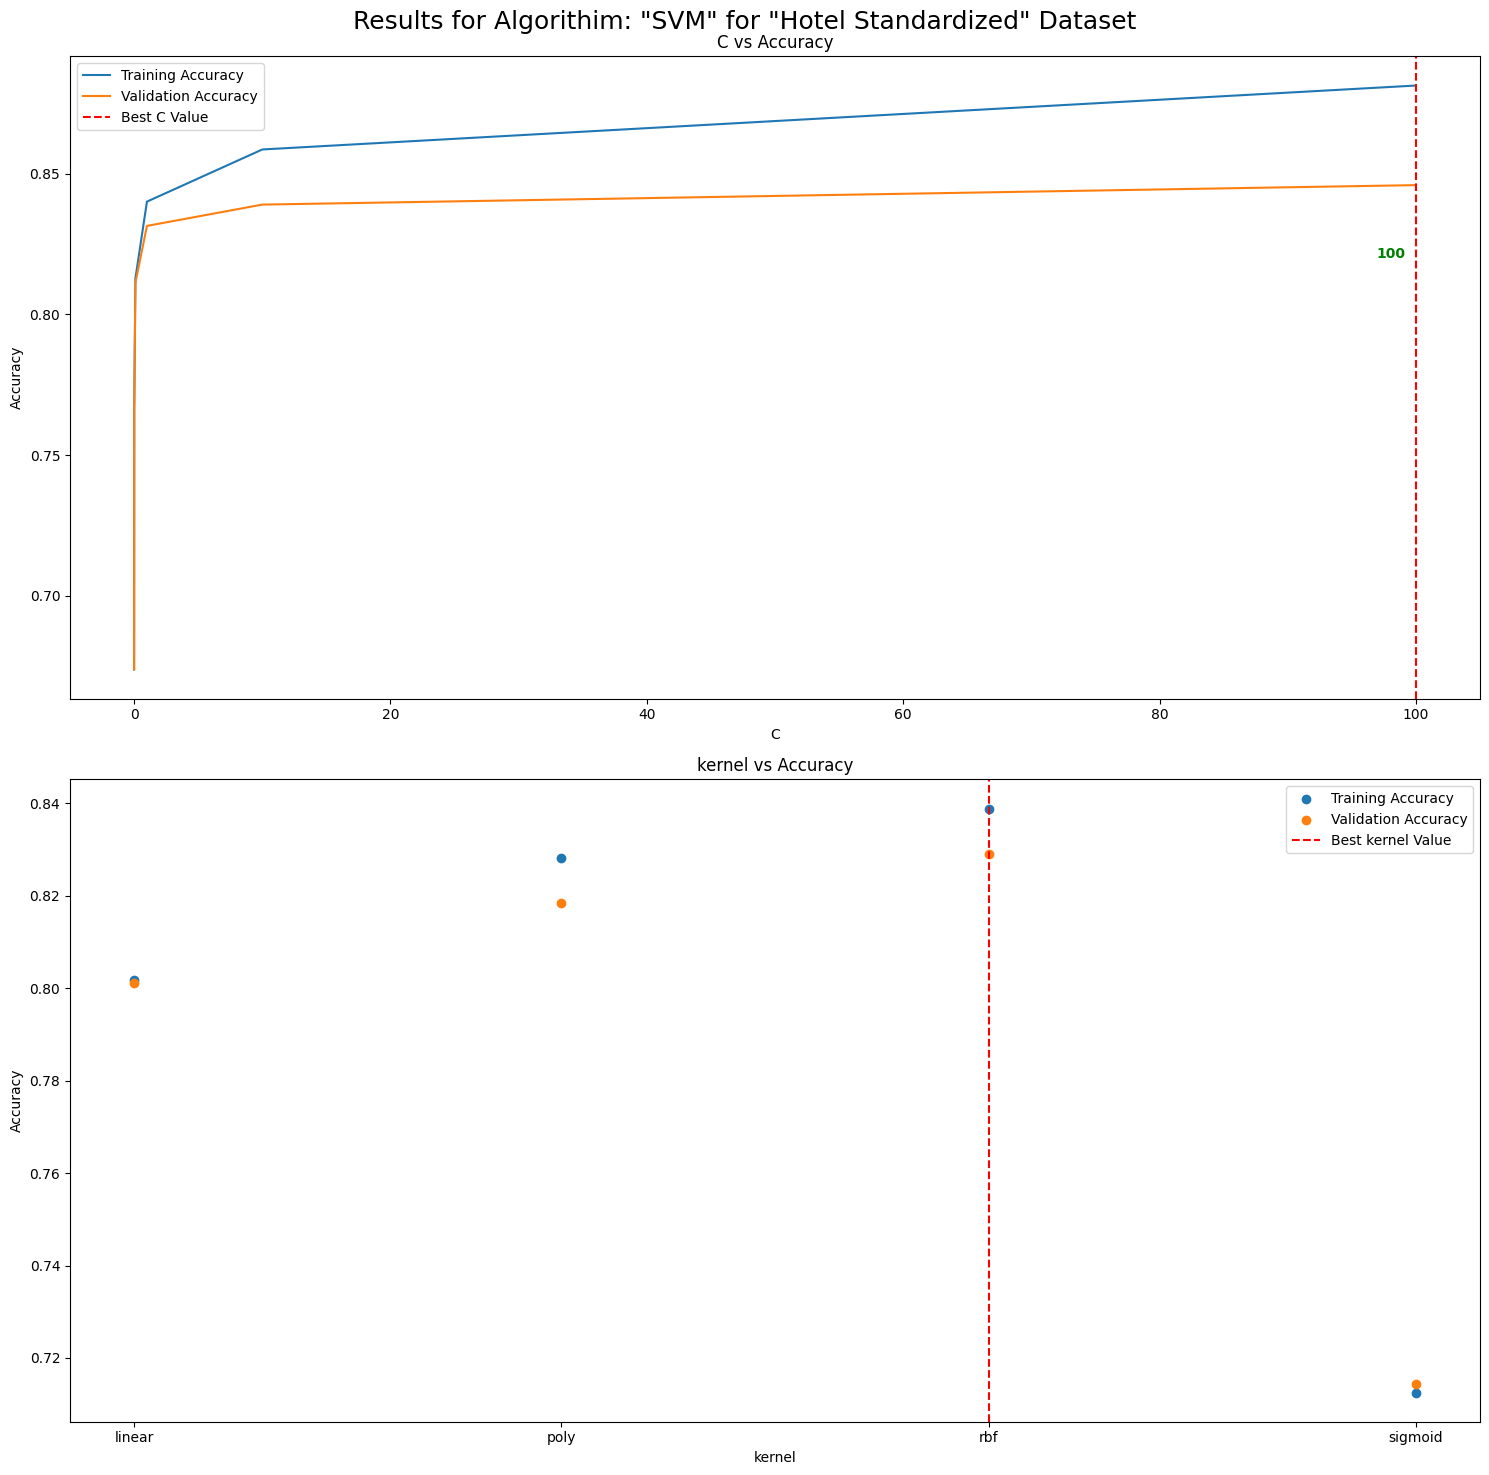

In [187]:
#Hotel  
param_dicts={'C':[0.0001,0.01,0.1,1,10,100],'kernel':['linear','poly','rbf','sigmoid'],}
deal_algorithim(train_hotel_standardized,param_dicts,'Hotel Standardized','SVM',SVC)

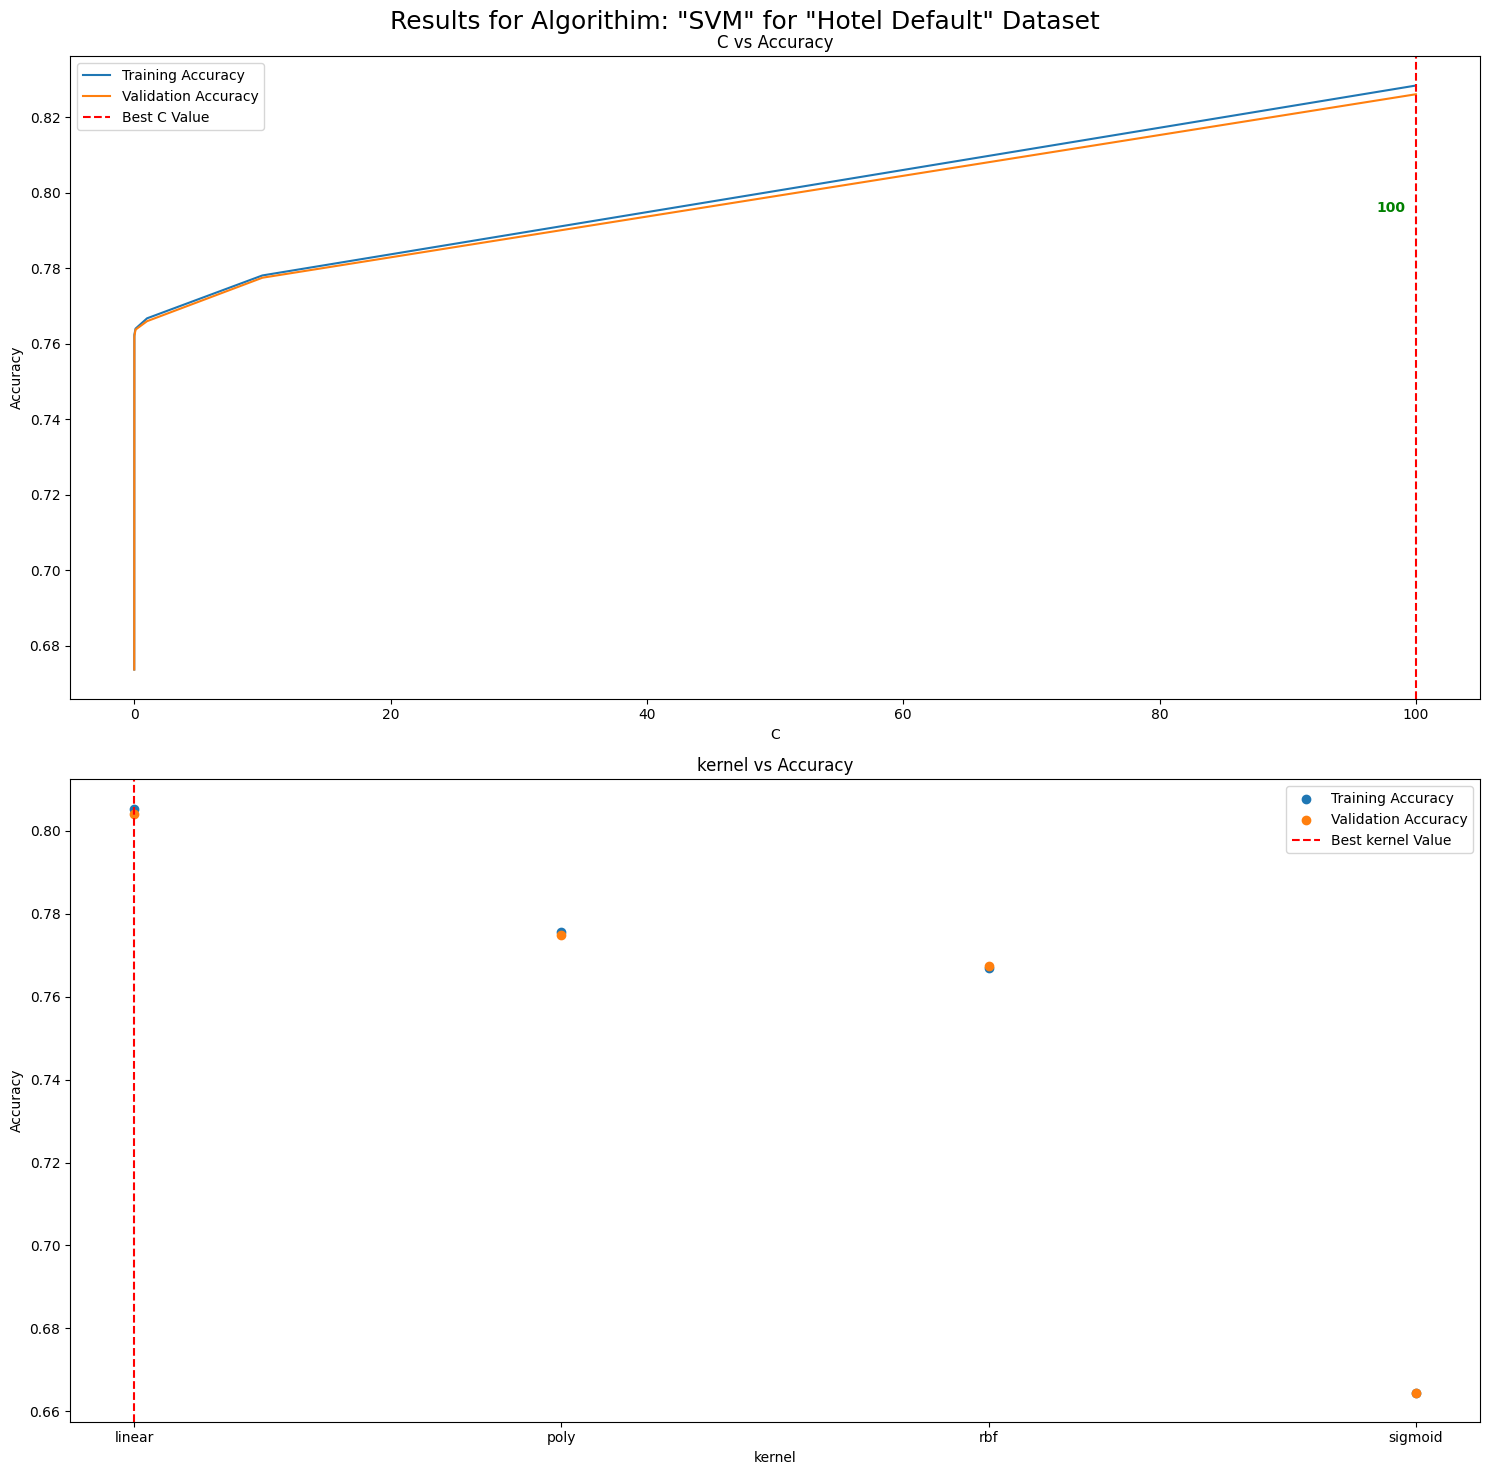

In [188]:
#Hotel Unstandardized
param_dicts={'C':[0.0001,0.01,0.1,1,10,100],'kernel':['linear','poly','rbf','sigmoid'],}
deal_algorithim(train_hotel_unstandardized,param_dicts,'Hotel Default','SVM',SVC)

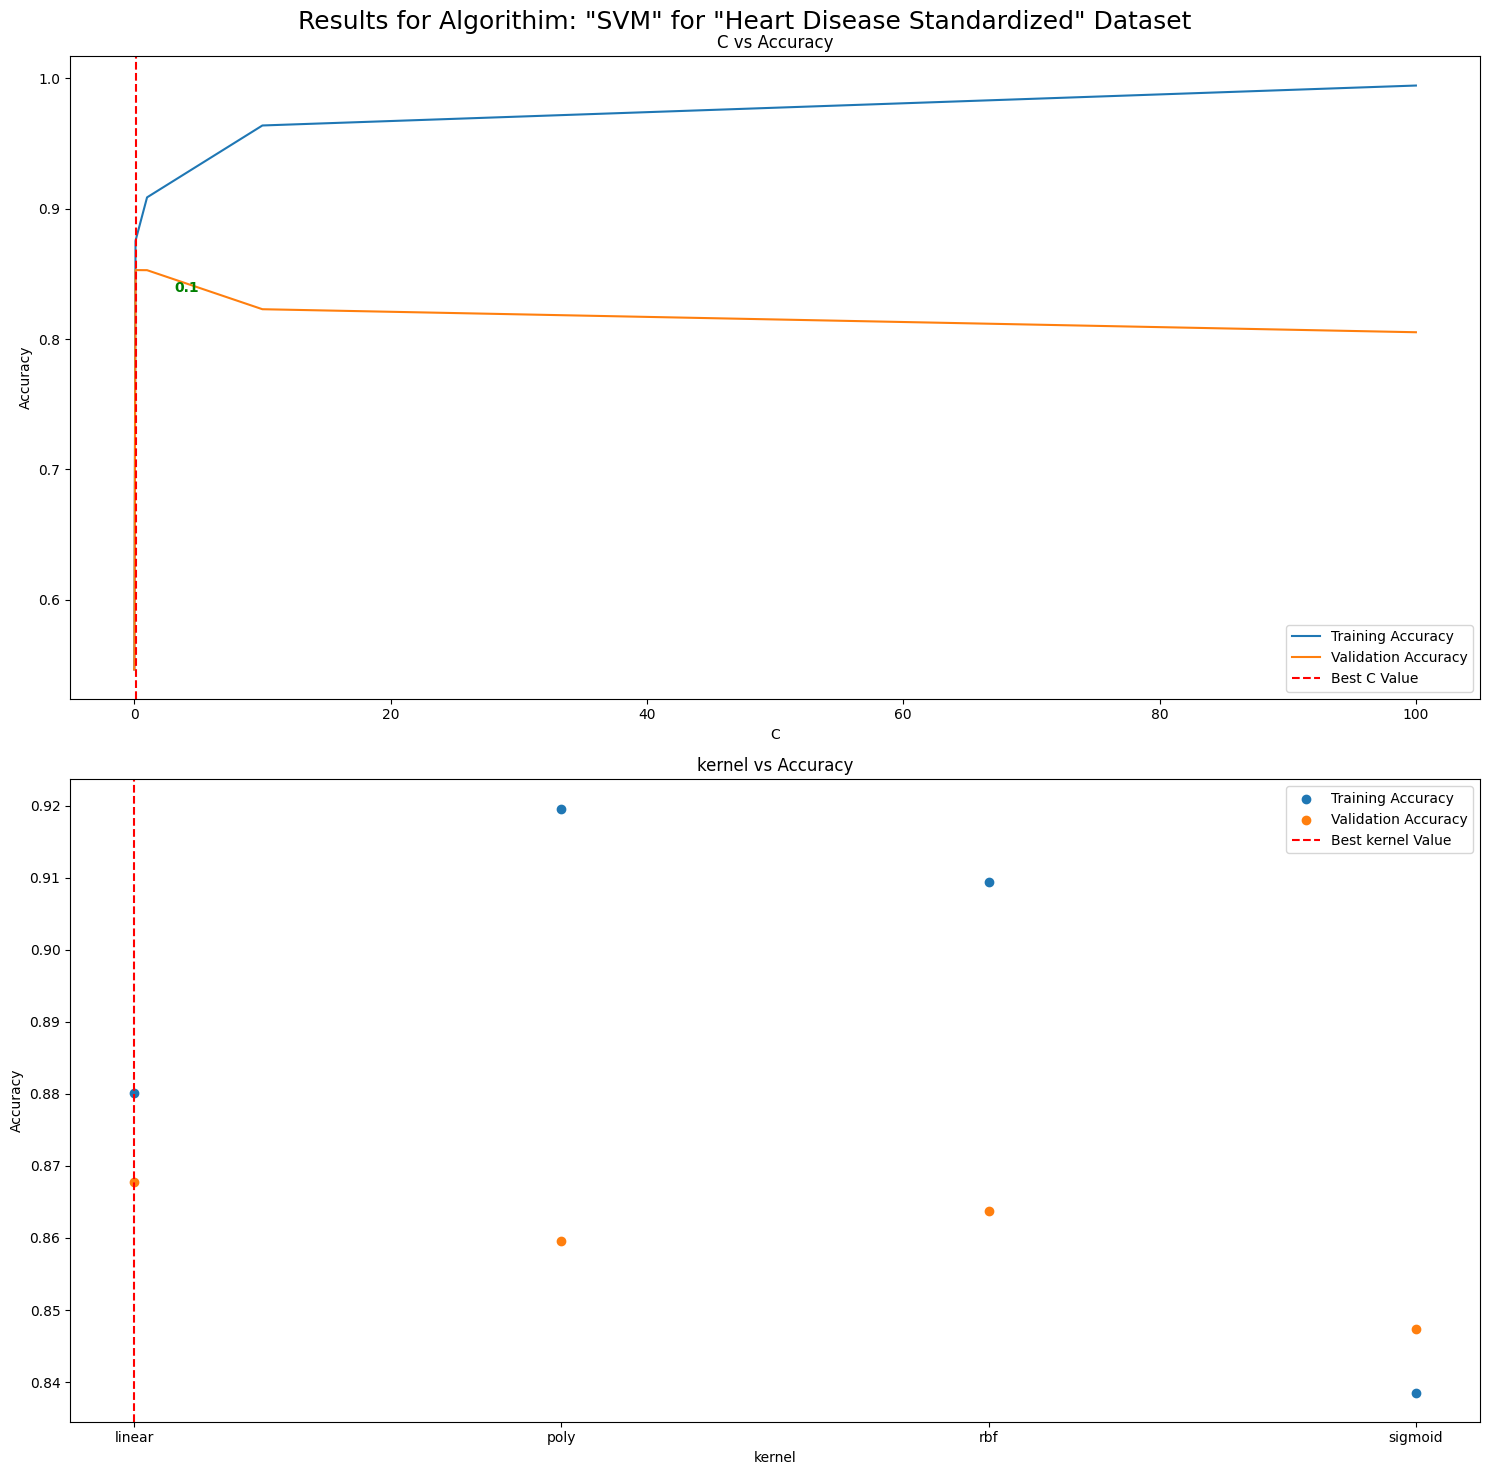

In [23]:
#Heart Disease
param_dicts={'C':[0.0001,0.01,0.1,1,10,100],'kernel':['linear','poly','rbf','sigmoid']}
deal_algorithim(train_heart_standardized,param_dicts,'Heart Disease Standardized','SVM',SVC)

### Scoring

In [208]:
#Hotel Dataset Scoring
param_dicts={'C':[10,100],'gamma':['scale','auto'],'kernel':['rbf']}
score_algorithim(X=X_hotel,Y=Y_hotel,dataset_name='Hotel Dataset',algorithim_name='SVM',algorithim=SVC(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Hotel Dataset Final Results


{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


Average time to train the ideal SVM was 42.310 seconds
Average time to infer the ideal SVM was 4.201 seconds


The result on the training data for the ideal SVM algorithim is a 0.8780151619572708 accuracy score
The result on the test data for the ideal SVM algorithim is a 0.8556857339765679 accuracy score


In [24]:
#Heart Disease Scoring
param_dicts={'C':[0.1,1,5],'gamma':['scale','auto'],'kernel':['rbf','linear']}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='SVM',algorithim=SVC(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Heart Disease Dataset Final Results


{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


Average time to train the ideal SVM was 0.370 seconds
Average time to infer the ideal SVM was 0.001 seconds


The result on the training data for the ideal SVM algorithim is a 0.8773841961852861 accuracy score
The result on the test data for the ideal SVM algorithim is a 0.8586956521739131 accuracy score


### Experimenting

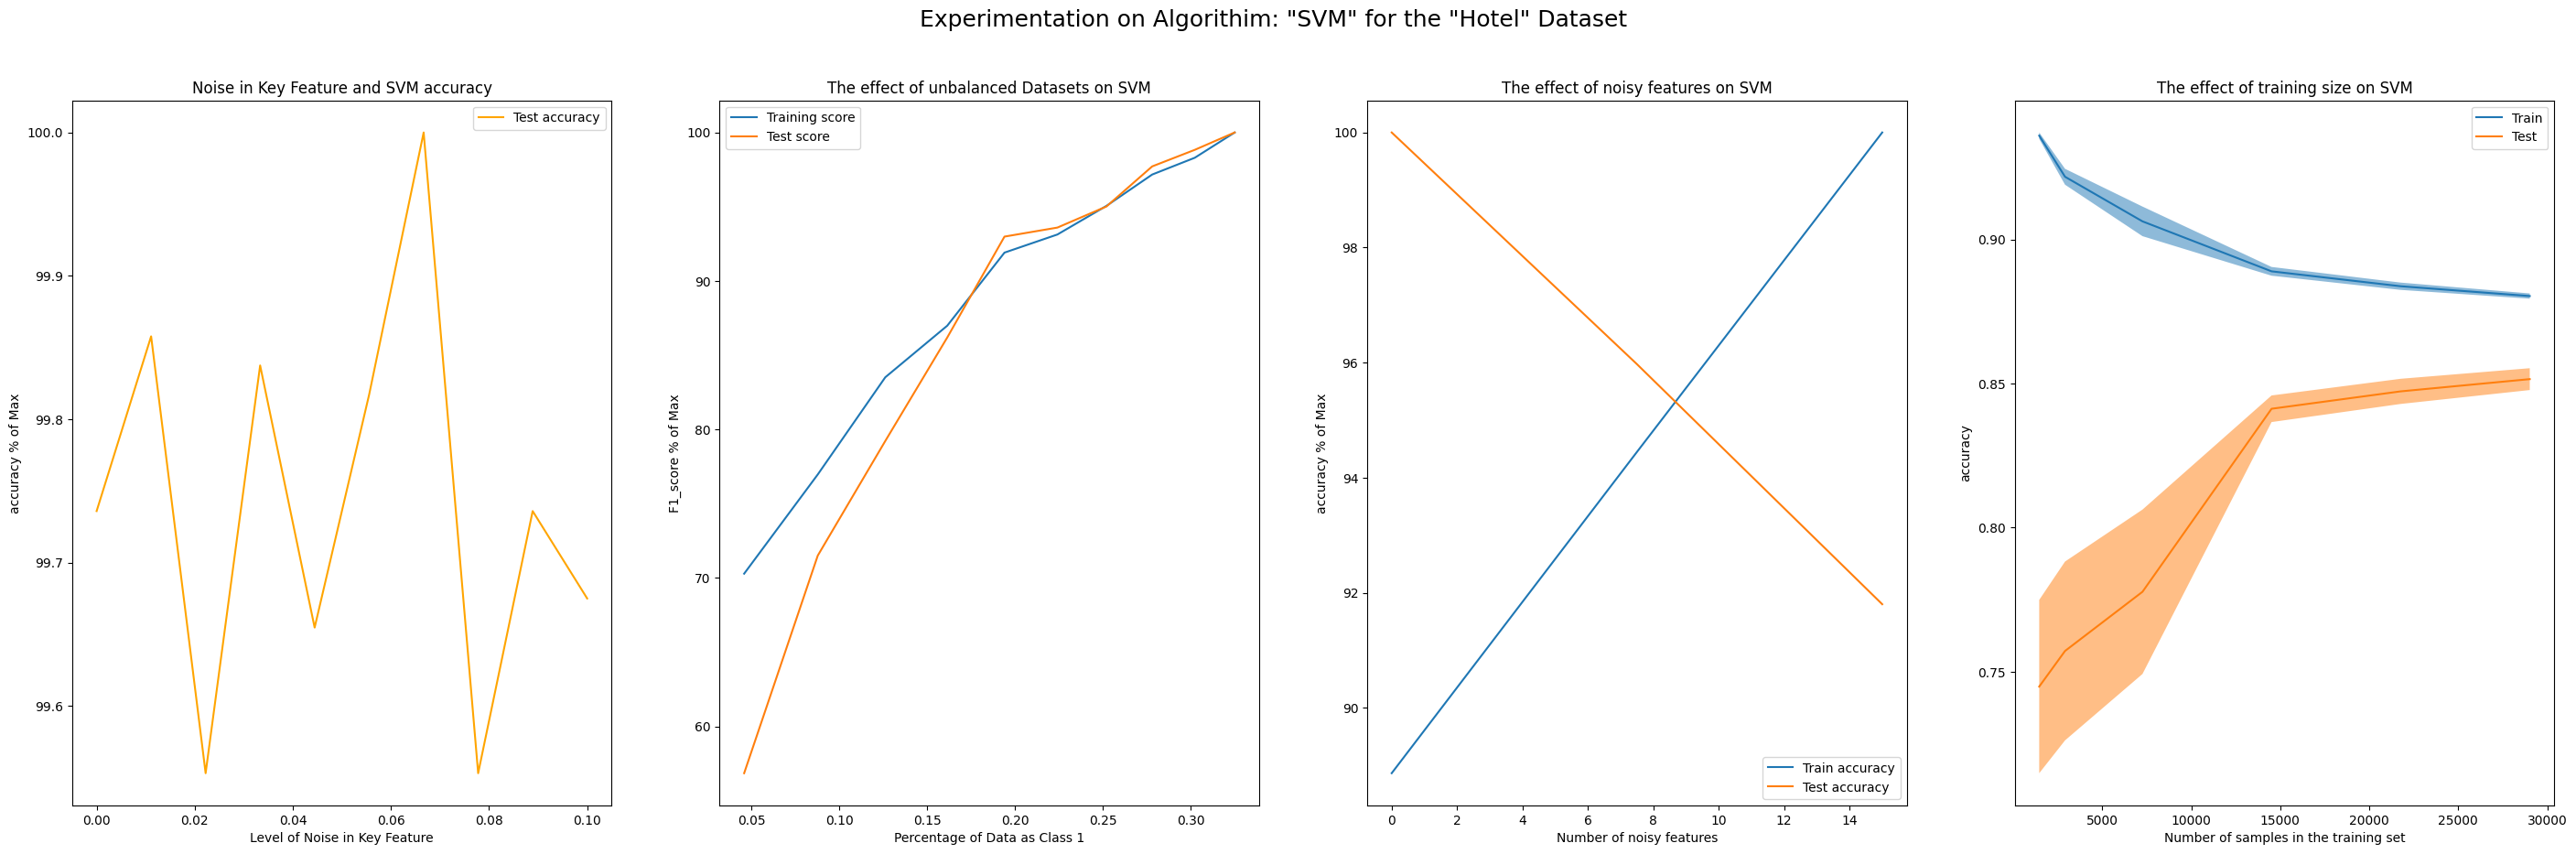

In [90]:
#Experiment Hotel Data
param_dicts={'C':[100],'gamma':['scale','auto'],'kernel':['rbf']}
experiment_algorithim(data=train_hotel_standardized,X=X_hotel,Y=Y_hotel,params=param_dicts,dataset='Hotel',col_index=col_index_hotel,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='SVM',algorithim=SVC(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

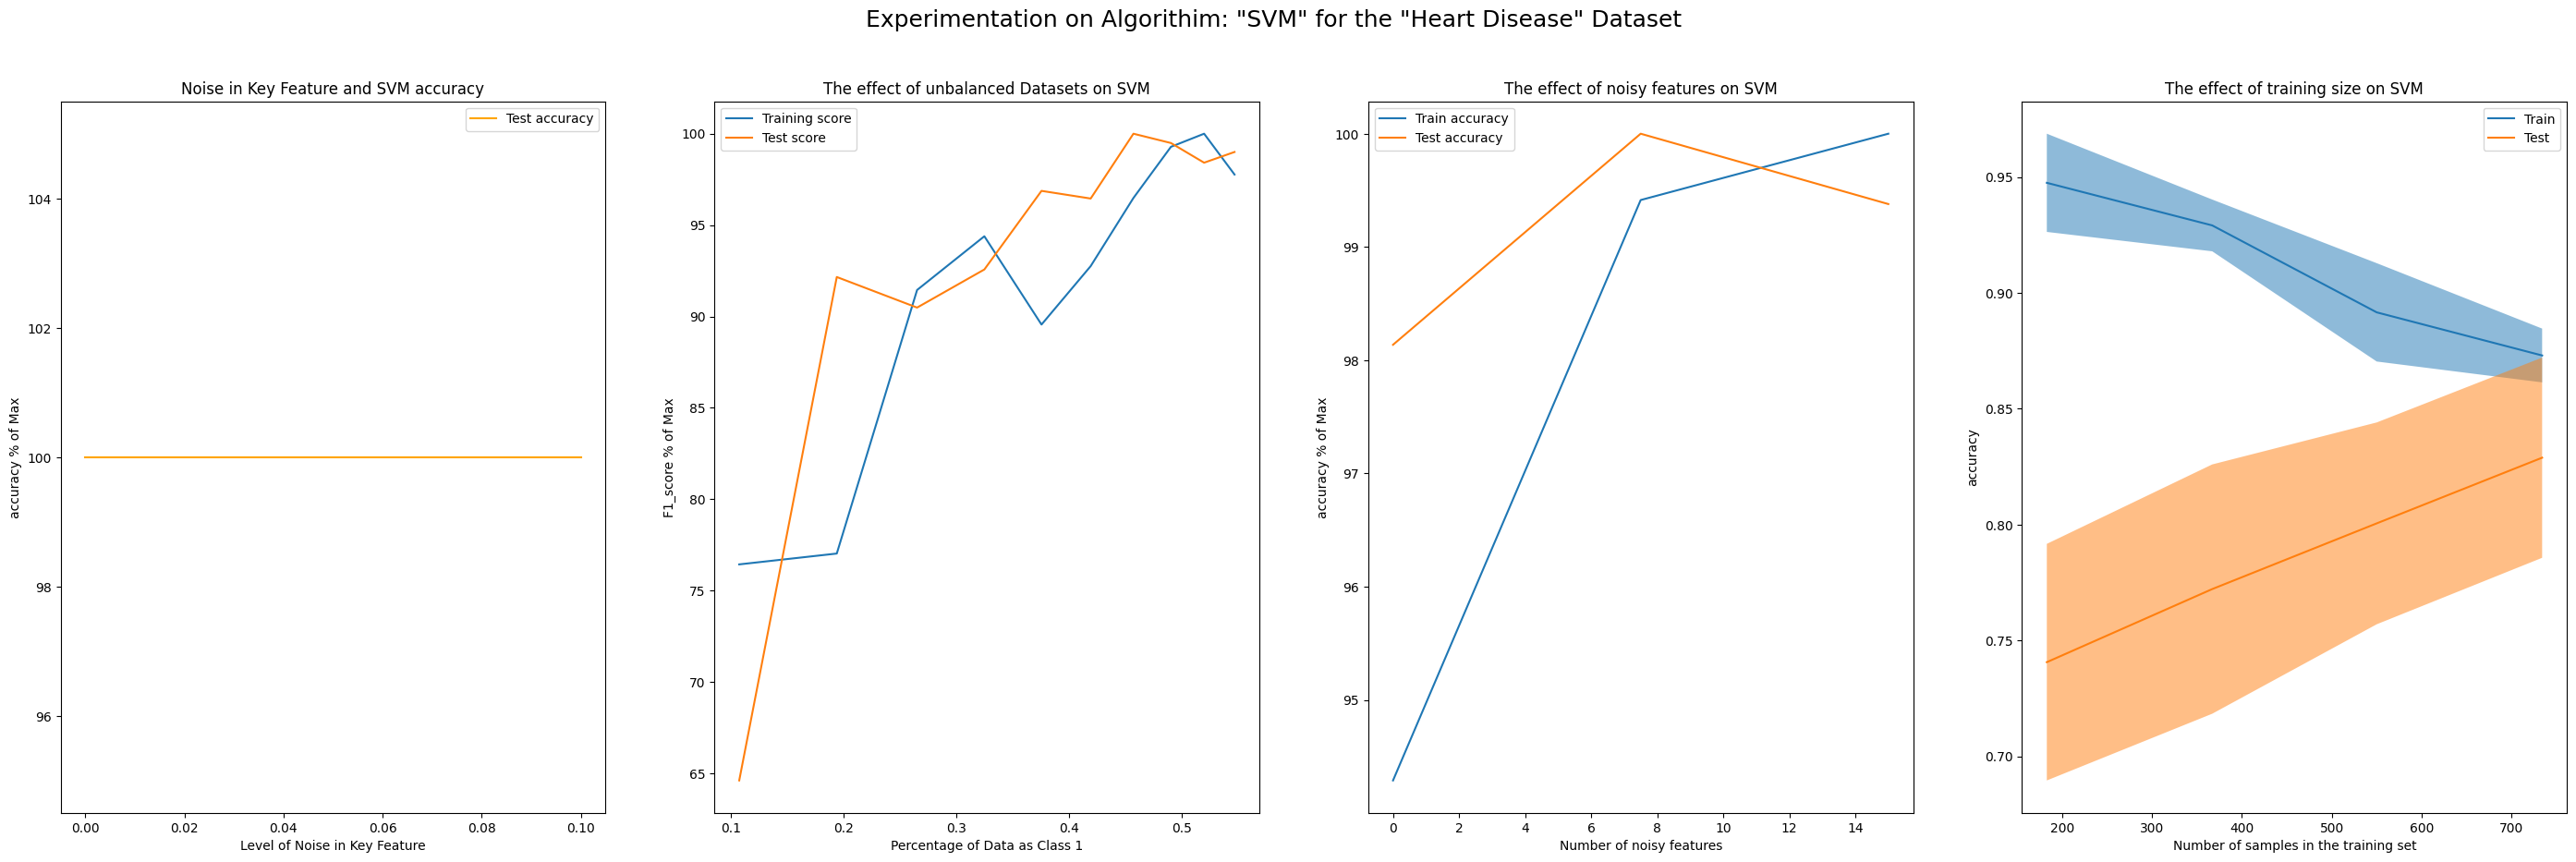

In [104]:
#Experimenting Heart Data
param_dicts={'C':[0.1,1],'gamma':['scale','auto'],'kernel':['rbf','linear']}
experiment_algorithim(data=train_heart_standardized,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='SVM',algorithim=SVC(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

# Neural Network

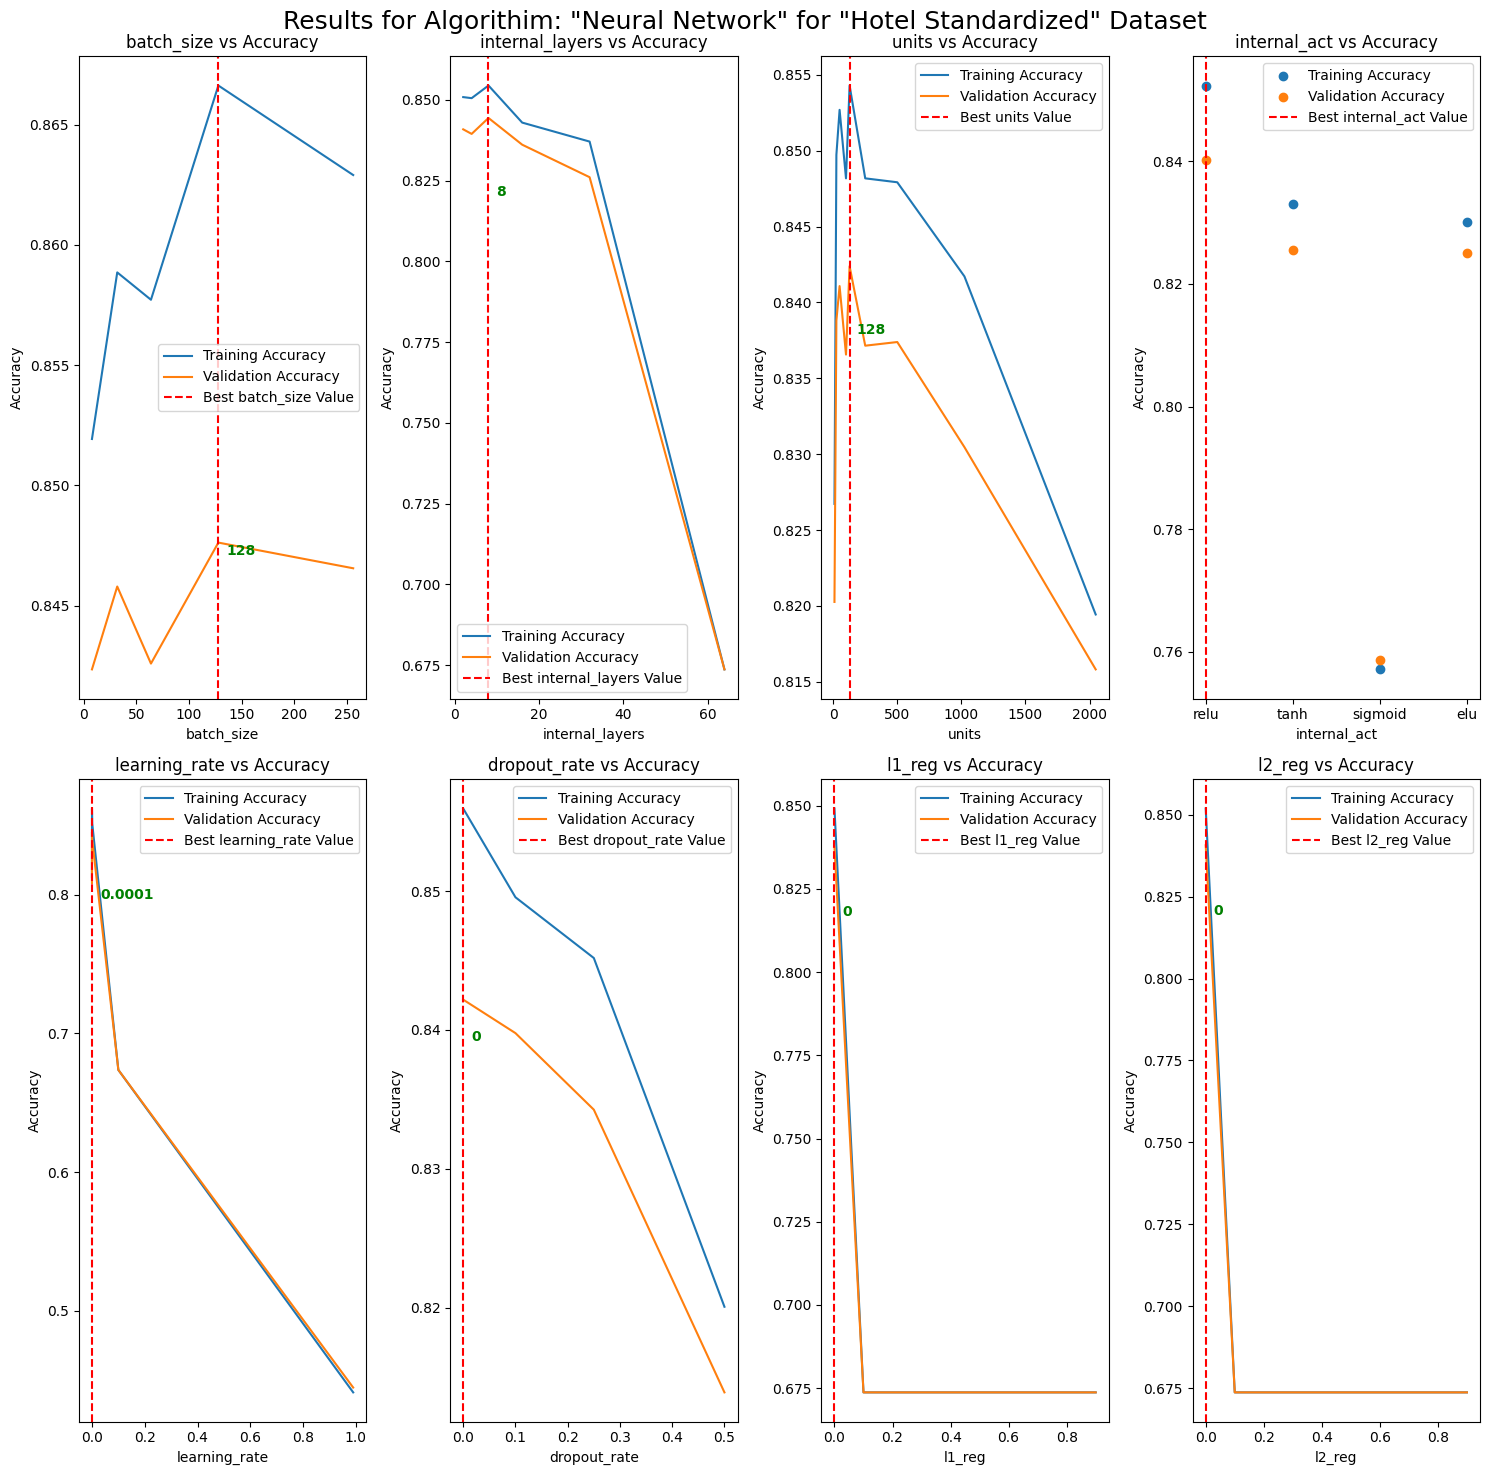

In [27]:
#Hotel Standardized

param_dicts={'batch_size':[8,32,64,128,256],'internal_layers':[2,4,8,16,32,64],'units':[10,25,50,100,128,250,500,1024,2048],'internal_act':['relu','tanh','sigmoid','elu'],'learning_rate':[0.00001,0.0001,0.001,0.1,0.99],'dropout_rate':[0,0.1,0.25,0.5],'l1_reg':[0,0.1,0.25,0.5,0.75,0.9],'l2_reg':[0,0.1,0.25,0.5,0.75,0.9]}

deal_algorithim(train_hotel_standardized,param_dicts,'Hotel Standardized','Neural Network',NNnet)

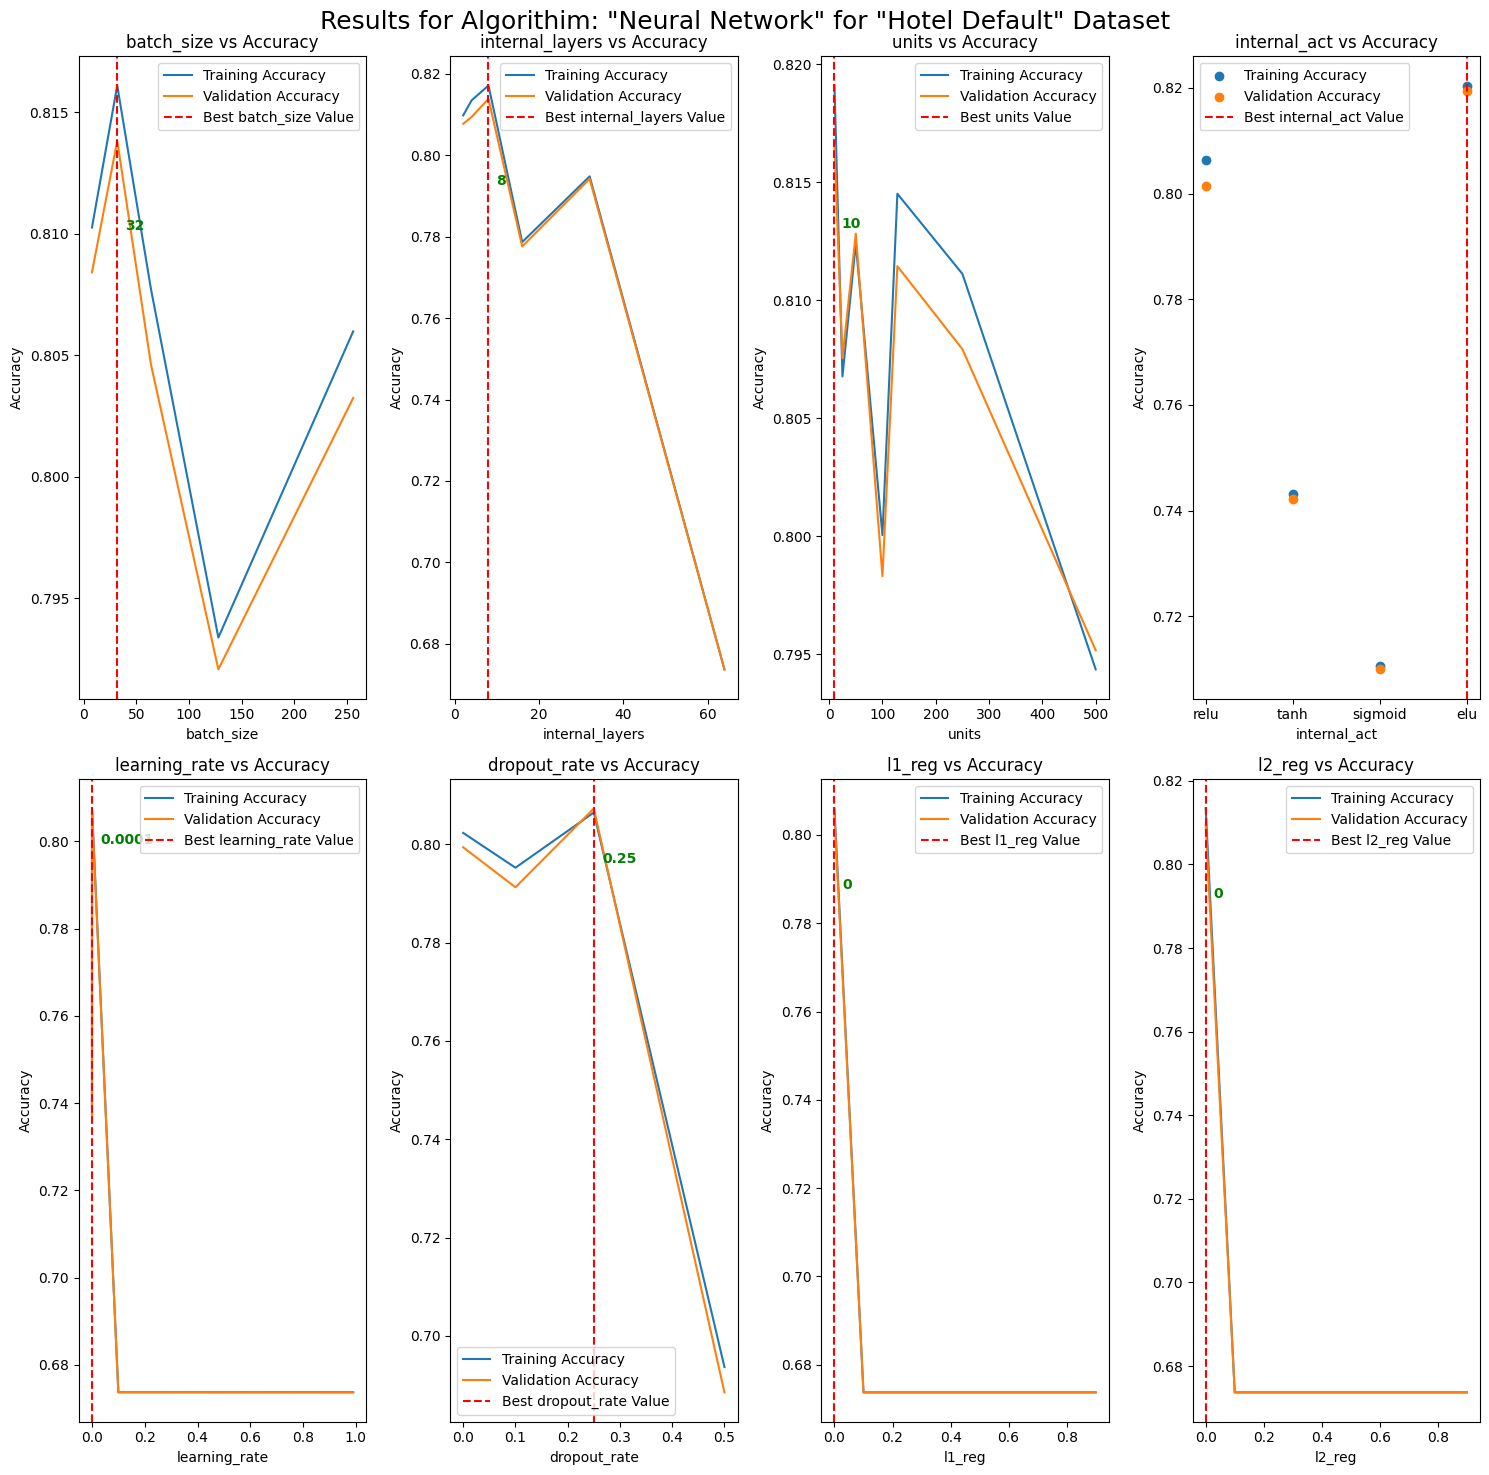

In [28]:
#Hotel Unstandardized
param_dicts={'batch_size':[8,32,64,128,256],'internal_layers':[2,4,8,16,32,64],'units':[10,25,50,100,128,250,500],'internal_act':['relu','tanh','sigmoid','elu'],'learning_rate':[0.00001,0.0001,0.001,0.1,0.99],'dropout_rate':[0,0.1,0.25,0.5],'l1_reg':[0,0.1,0.25,0.5,0.75,0.9],'l2_reg':[0,0.1,0.25,0.5,0.75,0.9]}
deal_algorithim(train_hotel_unstandardized,param_dicts,'Hotel Default','Neural Network',NNnet)

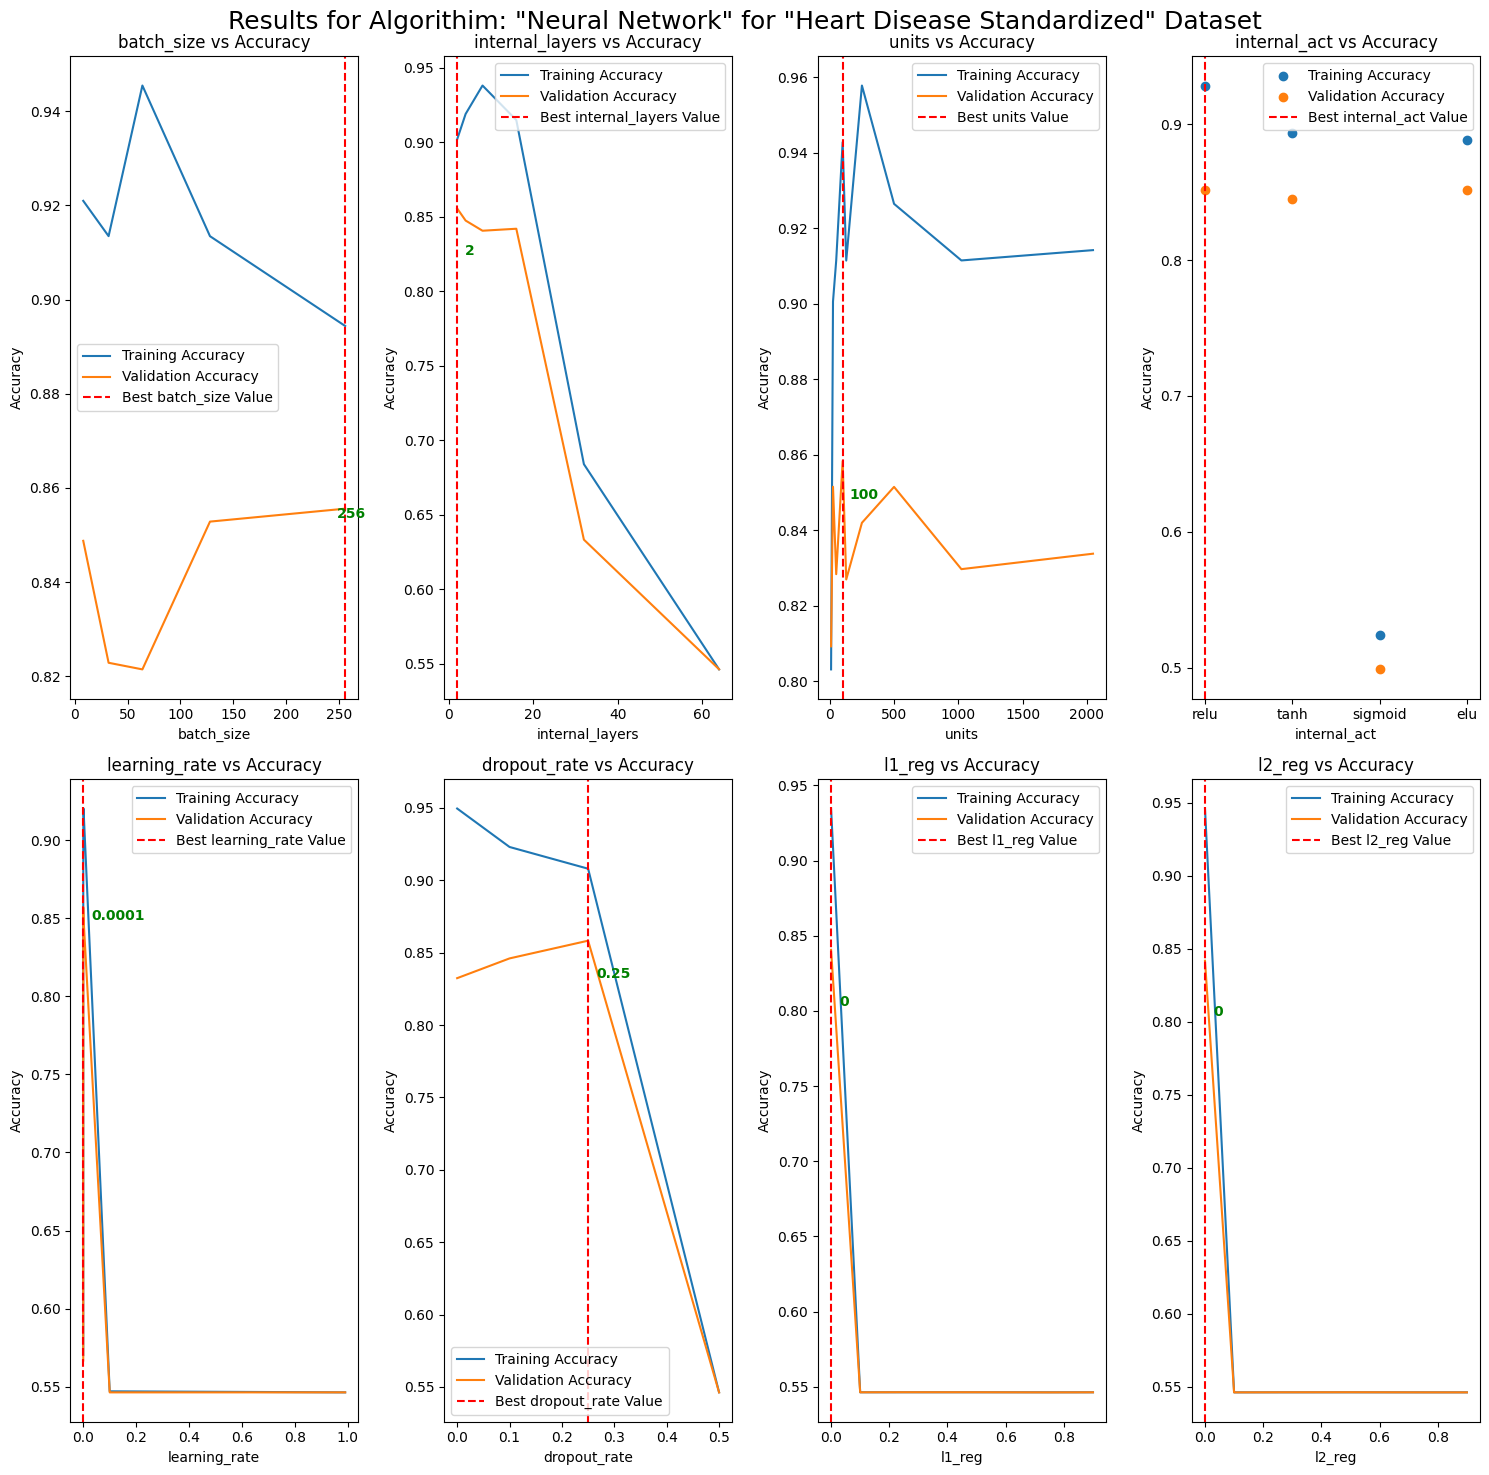

In [30]:
#Heart Standardized
param_dicts={'batch_size':[8,32,64,128,256],'internal_layers':[2,4,8,16,32,64],'units':[10,25,50,100,128,250,500,1024,2048],'internal_act':['relu','tanh','sigmoid','elu'],'learning_rate':[0.00001,0.0001,0.001,0.1,0.99],'dropout_rate':[0,0.1,0.25,0.5],'l1_reg':[0,0.1,0.25,0.5,0.75,0.9],'l2_reg':[0,0.1,0.25,0.5,0.75,0.9]}
deal_algorithim(train_heart_standardized,param_dicts,'Heart Disease Standardized','Neural Network',NNnet)

### Scoring

In [33]:
#Final Hotel Dataset Results

param_dicts={'internal_layers':[4,8],'units':[128,256],'learning_rate':[0.0001,0.001],'dropout_rate':[0,0.1]}

score_algorithim(X_hotel,Y_hotel,'Hotel Dataset','Neural Network',NNnet(input_dims=30),param_dicts)

Hotel Dataset Final Results


{'dropout_rate': 0, 'internal_layers': 8, 'learning_rate': 0.0001, 'units': 256}


Average time to train the ideal Neural Network was 102.492 seconds
Average time to infer the ideal Neural Network was 0.487 seconds


The result on the training data for the ideal Neural Network algorithim is a 0.9555823569951757 accuracy score
The result on the test data for the ideal Neural Network algorithim is a 0.8683666436940042 accuracy score


In [34]:
#Final Heart Disease Dataset Results

param_dicts={'internal_layers':[4,8,16,32],'units':[100,128],'learning_rate':[0.00001,0.0001],'dropout_rate':[0,0.1,0.2],'internal_act':['relu','elu']}

score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='Neural Network',algorithim=NNnet(input_dims=20),params=param_dicts)

Heart Disease Dataset Final Results


{'dropout_rate': 0.2, 'internal_act': 'elu', 'internal_layers': 4, 'learning_rate': 0.0001, 'units': 100}


Average time to train the ideal Neural Network was 52.674 seconds
Average time to infer the ideal Neural Network was 0.104 seconds


The result on the training data for the ideal Neural Network algorithim is a 0.8787465940054496 accuracy score
The result on the test data for the ideal Neural Network algorithim is a 0.8586956521739131 accuracy score


### Experiment

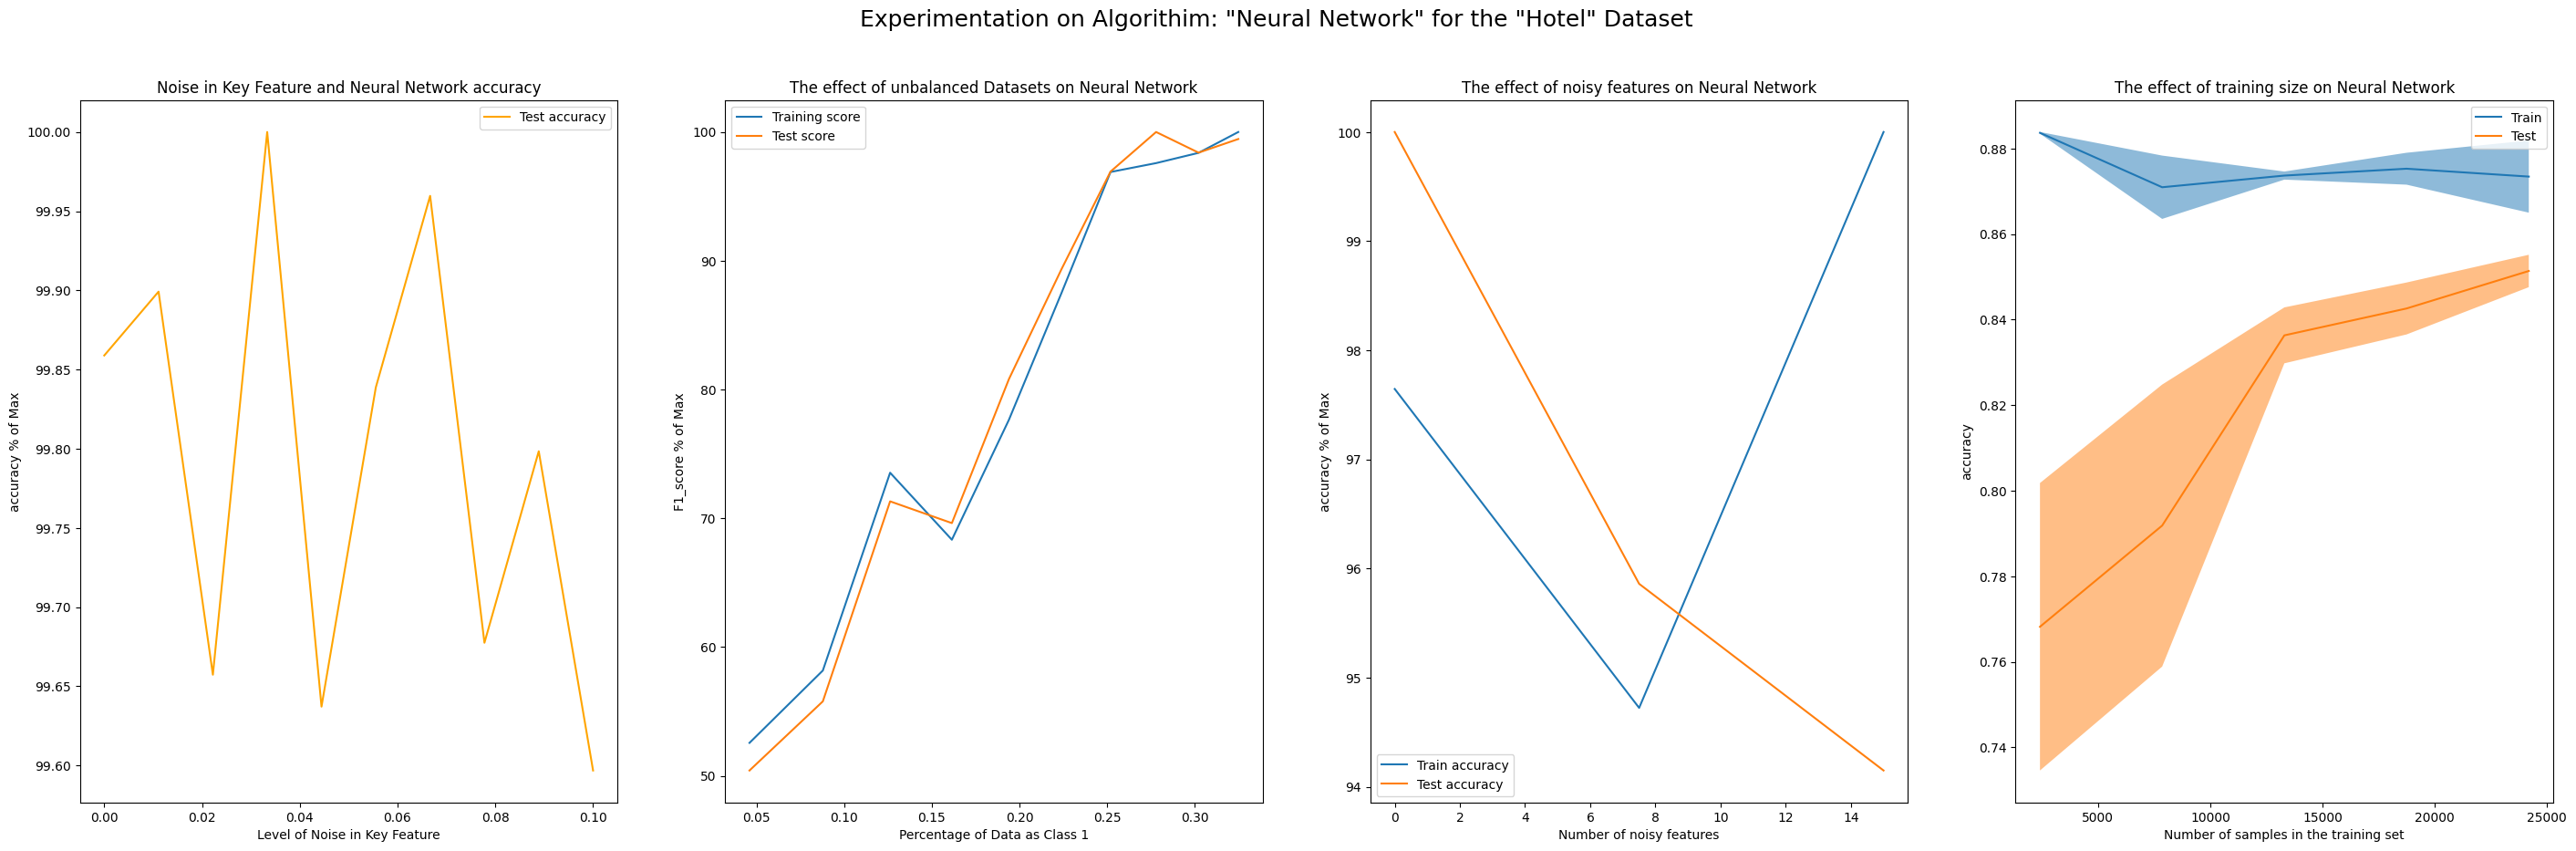

In [88]:
#Experiment Hotel Data

param_dicts={'internal_layers': 8, 'learning_rate': 0.0001, 'units': 256}

experiment_algorithim(data=train_hotel_standardized,X=X_hotel,Y=Y_hotel,params=param_dicts,dataset='Hotel',col_index=col_index_hotel,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Neural Network',algorithim=NNnet(input_dims=30),predictor_metric_name='accuracy',search=False,LD_scoring=ld_accuracy_scorer())

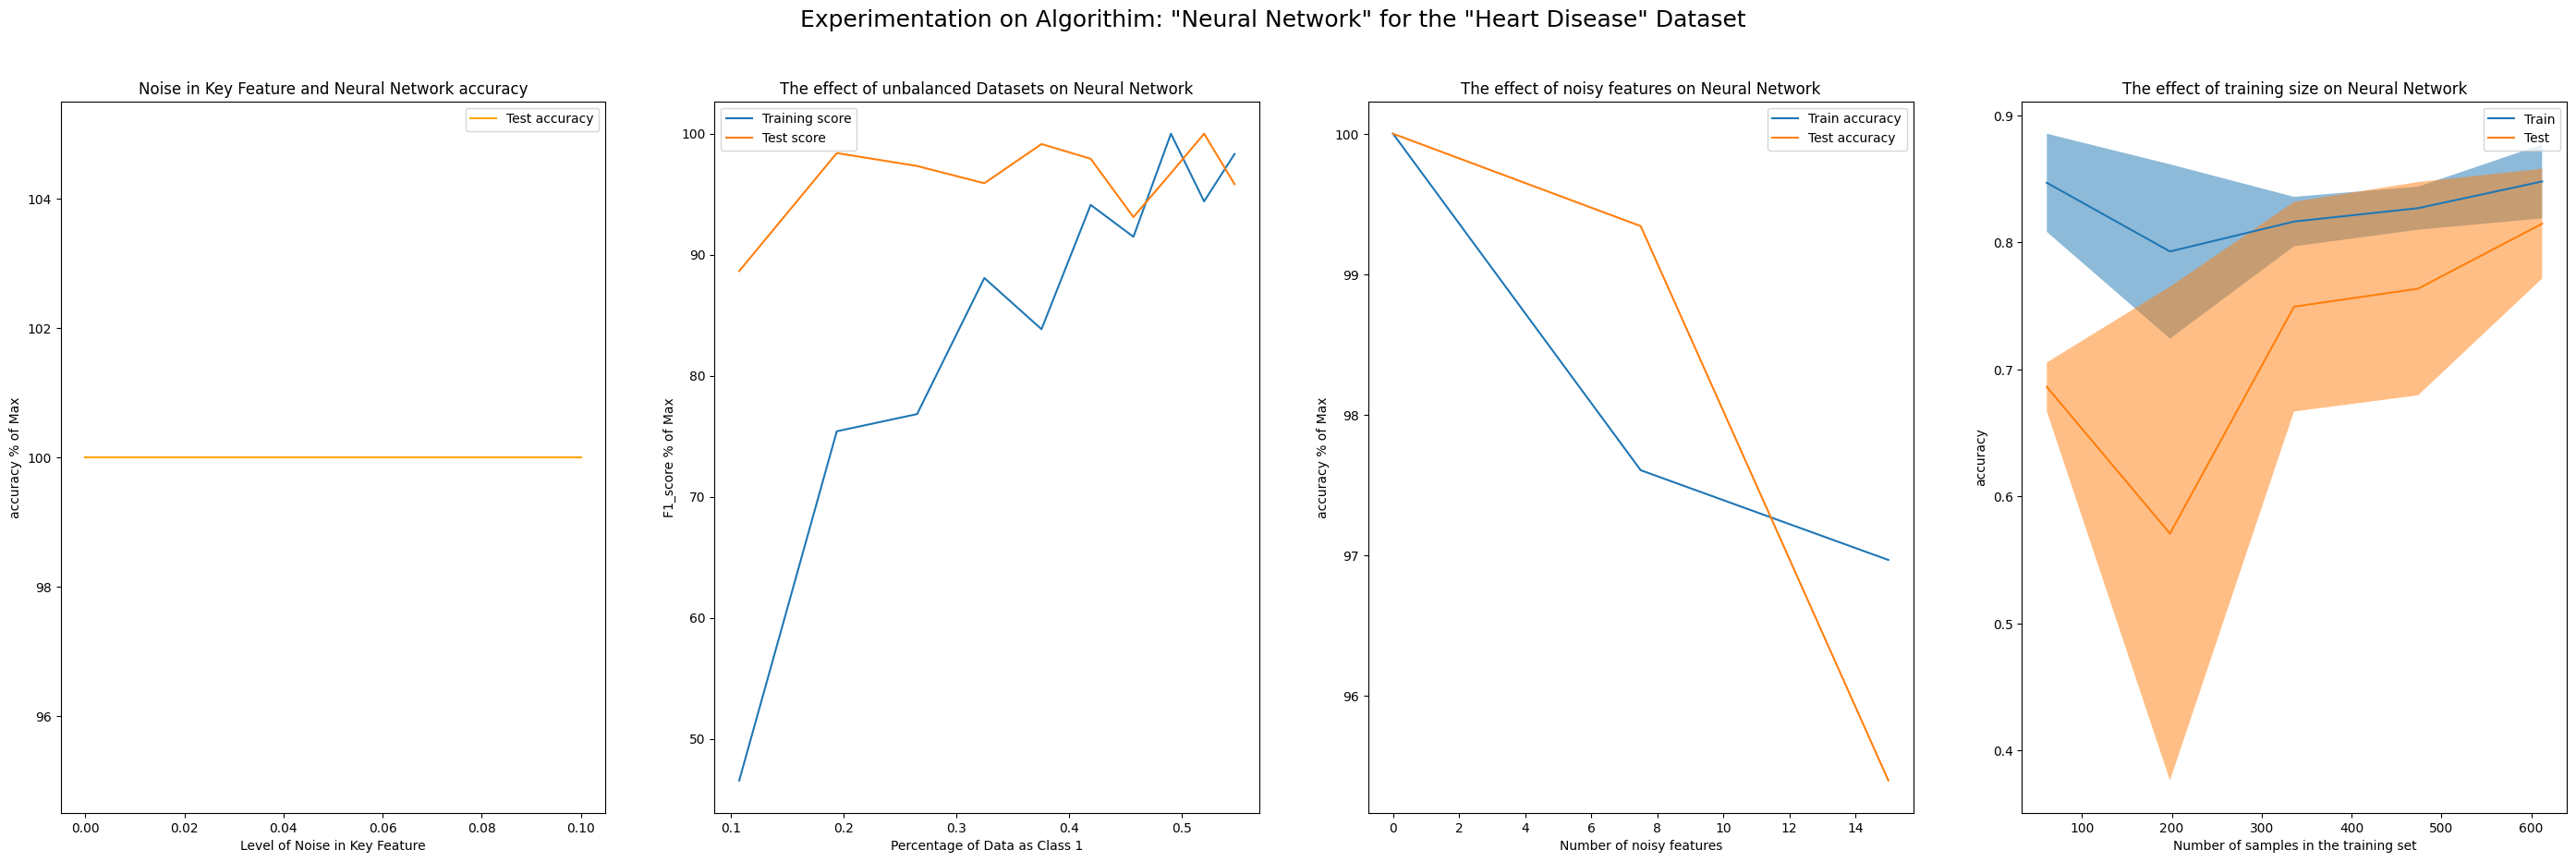

In [97]:
#Experiment Heart Data
param_dicts={'internal_layers':4,'units':100,'learning_rate':0.0001,'dropout_rate':0.1,'batch_size':256,'internal_act':'elu'}

experiment_algorithim(data=train_heart_standardized,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Neural Network',algorithim=NNnet(input_dims=20),predictor_metric_name='accuracy',search=False,LD_scoring=ld_accuracy_scorer())

### Epochs & Score

In [ ]:
#Hotel Dataset
params={'dropout_rate': 0, 'internal_layers': 8, 'learning_rate': 0.0001, 'units': 256,'input_dims':30,'early_stopping_tol':0}
model=NNnet(**params).internal_model
train_hotel_standardized_2,valid_hotel_standardized_2=split_data(train_hotel_standardized[0],train_hotel_standardized[1],standardize=False,valid=False)
history_1=model.fit(train_hotel_standardized_2[0],train_hotel_standardized_2[1],verbose=0,epochs=100,validation_data=valid_hotel_standardized_2)

#Heart Dataset
params={'dropout_rate': 0.2, 'internal_act': 'elu', 'internal_layers': 4, 'learning_rate': 0.0001, 'units': 100,'input_dims':20,'early_stopping_tol':0}
model=NNnet(**params).internal_model
train_heart_standardized_2,valid_heart_standardized_2=split_data(train_heart_standardized[0],train_heart_standardized[1],standardize=False,valid=False)
history_2=model.fit(train_heart_standardized_2[0],train_heart_standardized_2[1],verbose=0,epochs=100,validation_data=valid_heart_standardized_2)

Text(0.5, 1.0, 'Heart Disease Dataset Epochs vs Loss')

<Figure size 640x480 with 0 Axes>

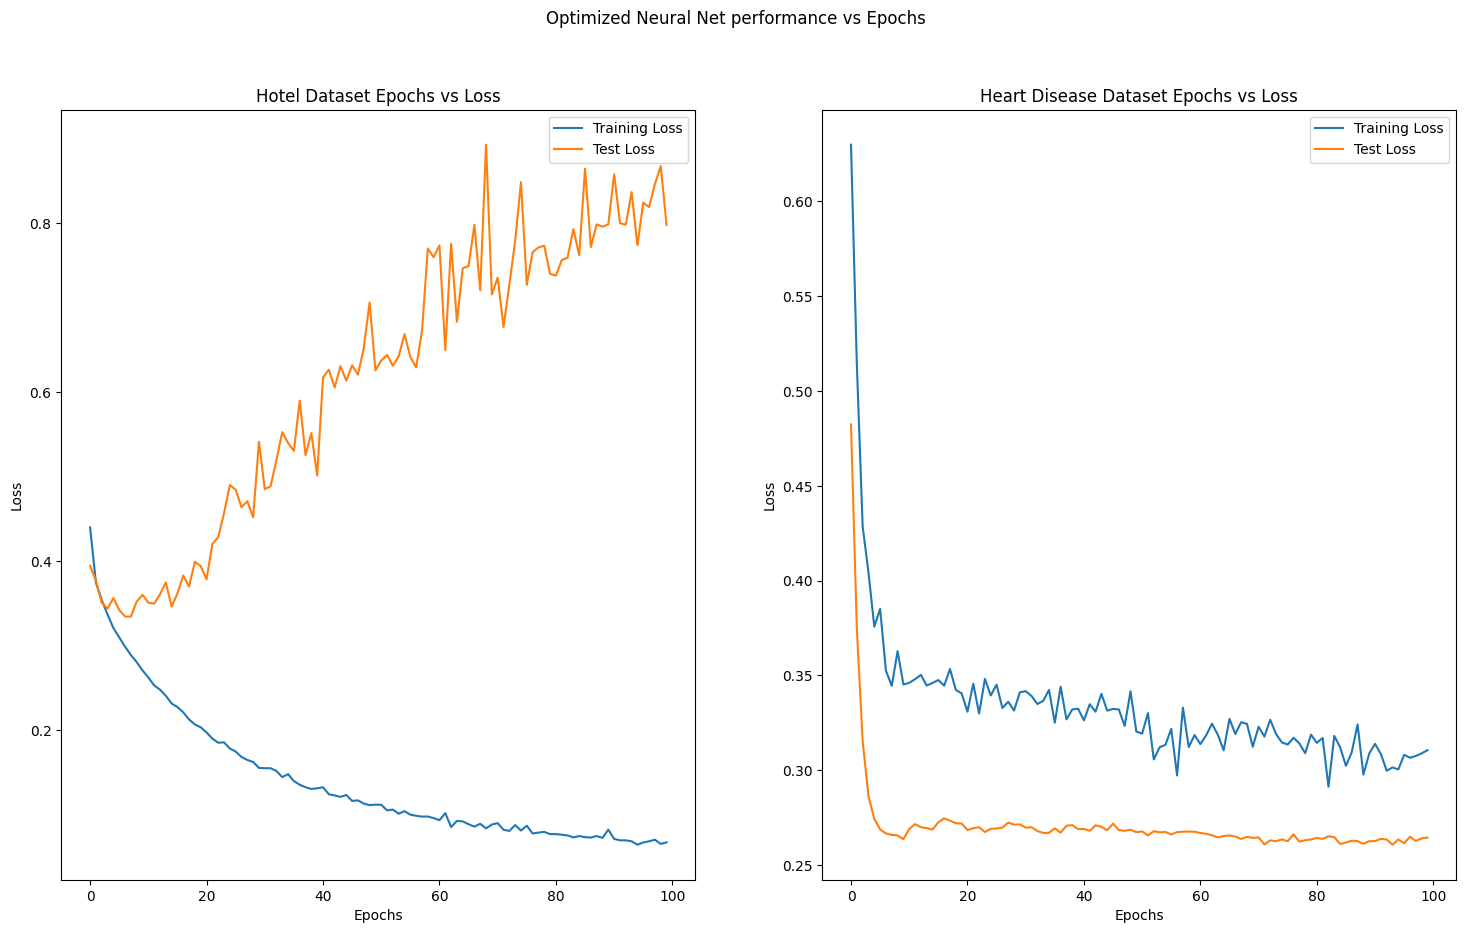

In [21]:
#Plotting
plt.figure()
fig,axes=plt.subplots(1,2)
fig.set_size_inches(18,10)

plt.suptitle('Optimized Neural Net performance vs Epochs')

#Hotel
axes[0].plot(history_1.history['loss'],label='Training Loss')
axes[0].plot(history_1.history['val_loss'],label='Test Loss')

axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend()
axes[0].set_title('Hotel Dataset Epochs vs Loss');

#Heart
axes[1].plot(history_2.history['loss'],label='Training Loss')
axes[1].plot(history_2.history['val_loss'],label='Test Loss')

axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].legend()
axes[1].set_title('Heart Disease Dataset Epochs vs Loss')

# Final Scoring

In [73]:
#Comparison of inference and test times
algorithim_name = ['Decision Tree','Gradient Boosted Tree','KNN','SVM','Neural Net']

#Hotel

hotel_training_time =[0.109,49.762,0.352,42.310,102.492]
hotel_test_time=[0.001,0.181,0.594,4.201,0.487]

hotel_train_accuracy=[0.8763611302549965,0.943039283252929,0.9939007580978635,0.8780151619572708,0.9555823569951757]
hotel_test_accuracy=[0.8665747760165403,0.875947622329428,0.8698828394210889,0.8556857339765679,0.8683666436940042]

#Heart

heart_training_time=[0.005,0.456,0.007,0.370,52.674]
heart_test_time=[0.000,0.000,0.013,0.001,0.104]

heart_train_accuracy=[0.8637602179836512,0.9223433242506812,1.0,0.8773841961852861,0.8787465940054496]
heart_test_accuracy=[0.8478260869565217,0.8695652173913043,0.8641304347826086,0.8586956521739131,0.8586956521739131]

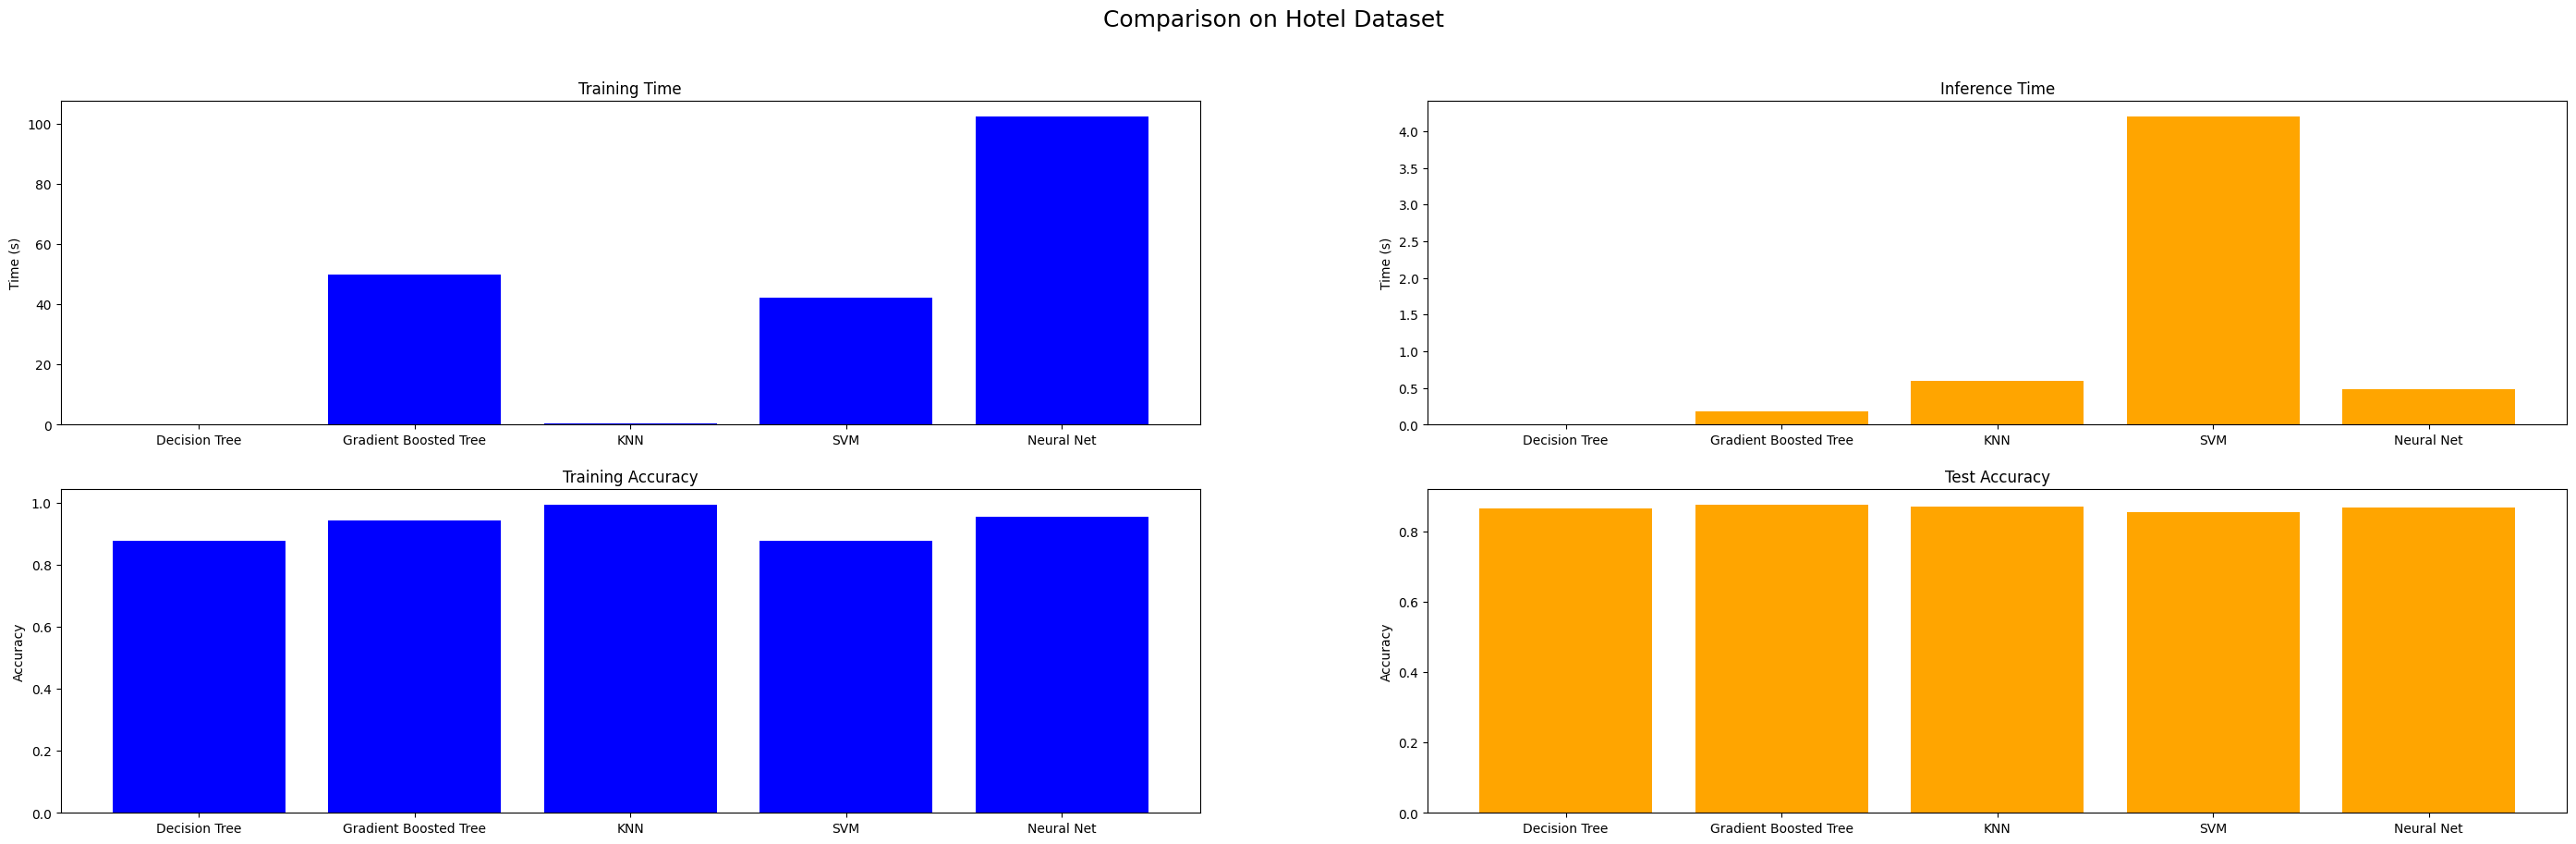

In [74]:
fig,axes=plt.subplots(2,2)
fig.set_size_ainches(35,10)
plt.suptitle('Comparison on Hotel Dataset',fontsize=18)

#Training Time
axes[0,0].set_title('Training Time')
axes[0,0].bar(algorithim_name,hotel_training_time,color='blue')
axes[0,0].set_ylabel('Time (s)')

#Test Time
axes[0,1].set_title('Inference Time')
axes[0,1].bar(algorithim_name,hotel_test_time,color='orange')
axes[0,1].set_ylabel('Time (s)')

#Training Acccuracy
axes[1,0].set_title('Training Accuracy')
axes[1,0].bar(algorithim_name,hotel_train_accuracy,color='blue')
axes[1,0].set_ylabel('Accuracy');

#Test Acccuracy
axes[1,1].set_title('Test Accuracy')
axes[1,1].bar(algorithim_name,hotel_test_accuracy,color='orange')
axes[1,1].set_ylabel('Accuracy');

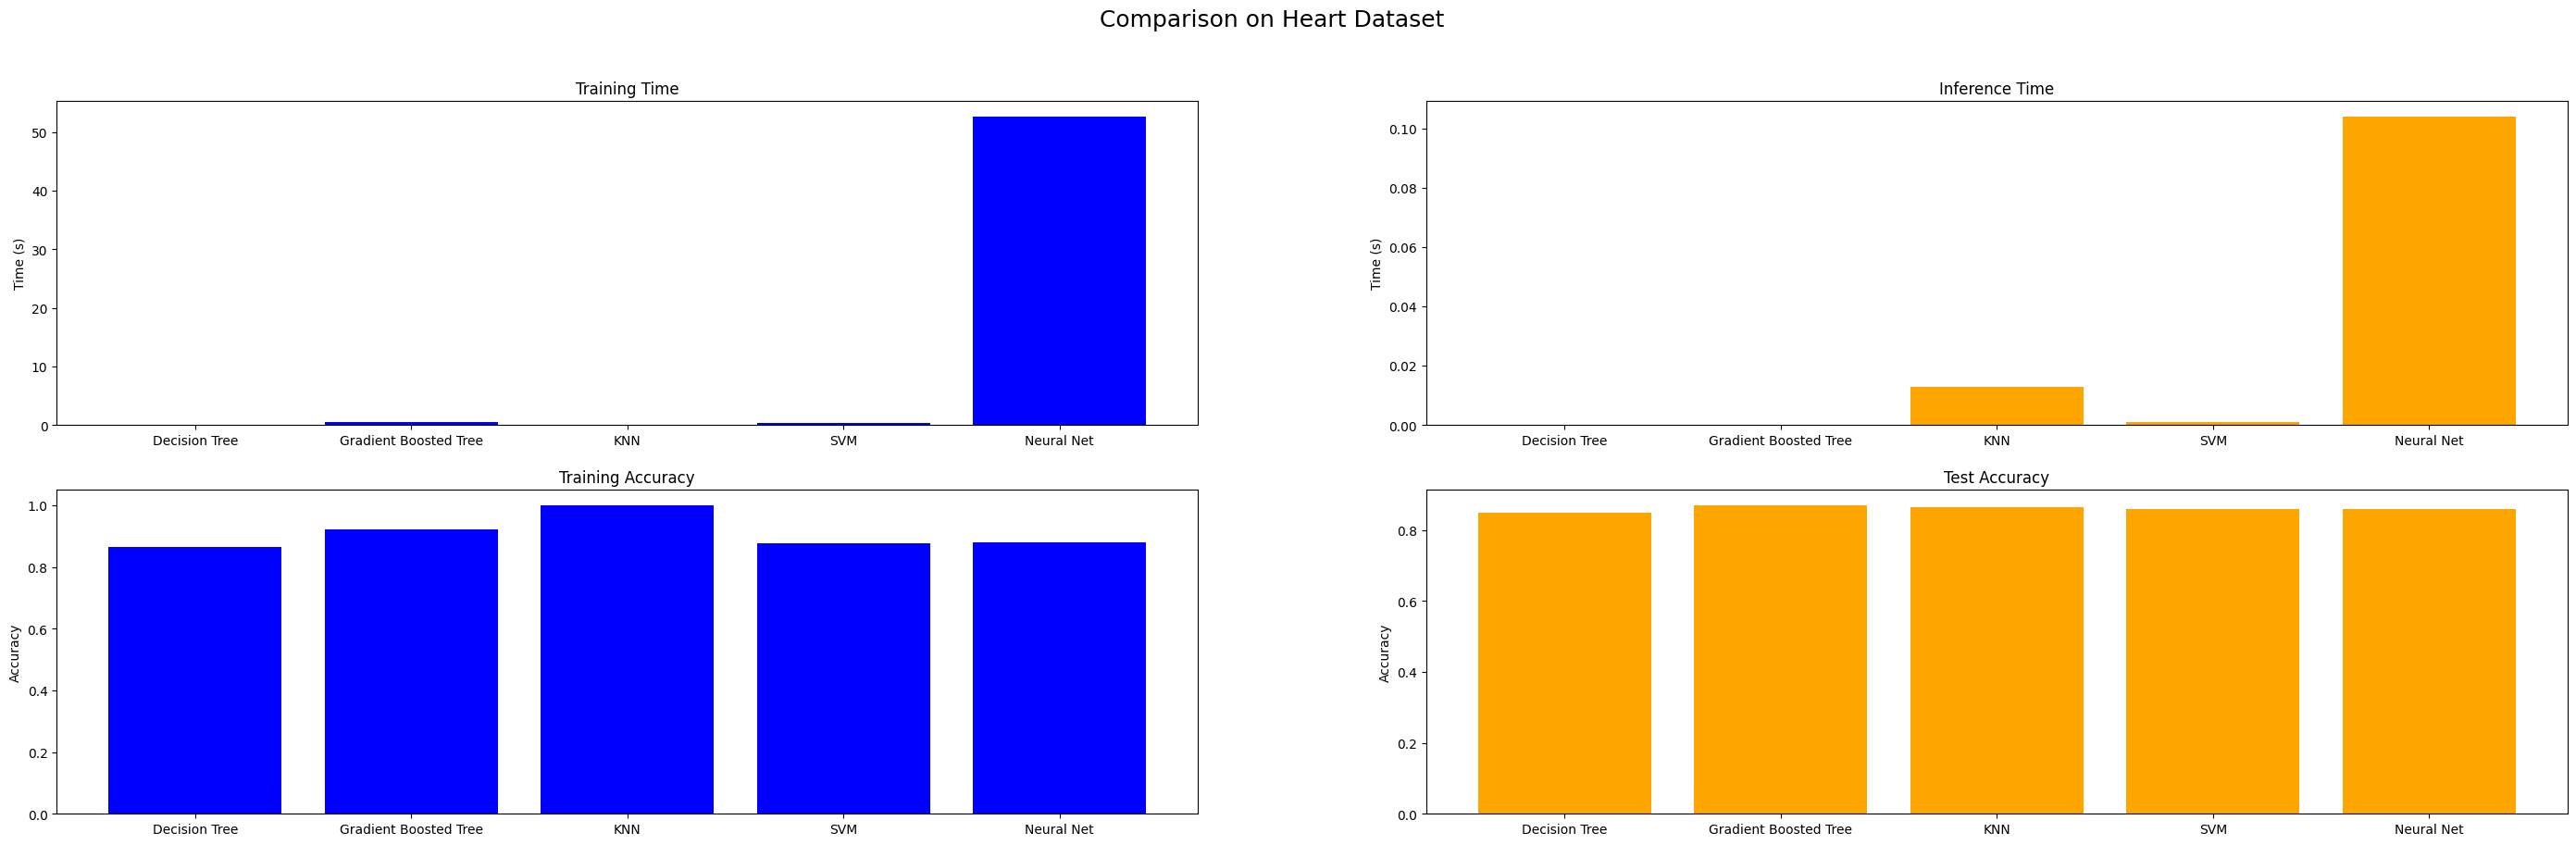

In [79]:
fig,axes=plt.subplots(2,2)
fig.set_size_inches(35,10)
plt.suptitle('Comparison on Heart Dataset',fontsize=18)

#Training Time
axes[0,0].set_title('Training Time')
axes[0,0].bar(algorithim_name,heart_training_time,color='blue')
axes[0,0].set_ylabel('Time (s)')

#Test Time
axes[0,1].set_title('Inference Time')
axes[0,1].bar(algorithim_name,heart_test_time,color='orange')
axes[0,1].set_ylabel('Time (s)')

#Training Acccuracy
axes[1,0].set_title('Training Accuracy')
axes[1,0].bar(algorithim_name,heart_train_accuracy,color='blue')
axes[1,0].set_ylabel('Accuracy');

#Test Acccuracy
axes[1,1].set_title('Test Accuracy')
axes[1,1].bar(algorithim_name,heart_test_accuracy,color='orange')
axes[1,1].set_ylabel('Accuracy');